In [85]:
from Scripts.cluster_scripts import *
from Scripts.jup_plot import *
import Scripts.extrapolate as extrapolate

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
plt.rcParams['font.family'] = 'Arial'

In [87]:
import matplotlib.font_manager

fonts = sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))

for font in fonts:
    print(font)


Abyssinica SIL
Ani
AnjaliOldLipi
C059
Chandas
Chilanka
D050000L
DejaVu Sans
DejaVu Sans Display
DejaVu Sans Mono
DejaVu Serif
DejaVu Serif Display
Droid Sans Fallback
Dyuthi
FreeMono
FreeSans
FreeSerif
Gargi
Garuda
Gayathri
Gubbi
Jamrul
KacstArt
KacstBook
KacstDecorative
KacstDigital
KacstFarsi
KacstLetter
KacstNaskh
KacstOffice
KacstOne
KacstPen
KacstPoster
KacstQurn
KacstScreen
KacstTitle
KacstTitleL
Kalapi
Kalimati
Karumbi
Keraleeyam
Khmer OS
Khmer OS System
Kinnari
LKLUG
Laksaman
Liberation Mono
Liberation Sans
Liberation Sans Narrow
Liberation Serif
Likhan
Lohit Assamese
Lohit Bengali
Lohit Devanagari
Lohit Gujarati
Lohit Gurmukhi
Lohit Kannada
Lohit Malayalam
Lohit Odia
Lohit Tamil
Lohit Tamil Classical
Lohit Telugu
Loma
Manjari
Meera
Mitra Mono
Mukti Narrow
Nakula
Navilu
Nimbus Mono PS
Nimbus Roman
Nimbus Sans
Nimbus Sans Narrow
Norasi
Noto Mono
Noto Sans CJK JP
Noto Serif CJK JP
OpenSymbol
P052
Padauk
Padauk Book
Pagul
Phetsarath OT
Pothana2000
Purisa
Rachana
RaghuMalayalamSans

# Multireference character

In [2]:



def radar_factory(num_vars, frame='circle',rotation=0):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False) 

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')
            self.set_theta_offset(rotation)


        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k",orientation=rotation)
                # return RegularPolygon((0.5, 0.5), num_vars,
                #                       radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                # spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                #                     + self.transAxes)
                spine.set_transform(Affine2D().rotate(rotation).scale(.5).translate(.5, .5)
                                    + self.transAxes)
                # print(spine)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [3]:
# MR character for Au4, Ag4, Cu4, Au6, Ag6, Cu6, Au8, Cu8, Ag8, Au20

mr_character = {x: [] for x in ['Au4', 'Ag4', 'Cu4', 'Au6', 'Ag6', 'Cu6', 'Au8', 'Cu8', 'Ag8', 'Au20']}
mr_t1_character = {x: [] for x in ['Au4', 'Ag4', 'Cu4', 'Au6', 'Ag6', 'Cu6', 'Au8', 'Cu8', 'Ag8', 'Au20']}
mr_d1_character = {x: [] for x in ['Au4', 'Ag4', 'Cu4', 'Au6', 'Ag6', 'Cu6', 'Au8', 'Cu8', 'Ag8', 'Au20']}


for i in ['Au4', 'Ag4', 'Cu4', 'Au6', 'Ag6', 'Cu6', 'Au8', 'Cu8', 'Ag8']:
    for j in [1,2,3,4]:

        a1 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/1/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsd')
        a2 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/2/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsd')
        a3 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/3/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsd')
        diff = a1 - a2
        dummy1 = extrapolate.get_cbs(0,a1,0,a2,X=3,Y=4,family='mixcc',output=False)

        a1 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/1/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsdt')
        a2 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/2/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsdt')
        a3 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/3/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsdt')
        diff = a1 - a2
        dummy2 = extrapolate.get_cbs(0,a1,0,a2,X=3,Y=4,family='mixcc',output=False)
        mr_character[i] += [100*dummy1[-1]/dummy2[-1]]
        t1_diagnostic = []
        d1_diagnostic = []
        f = open('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/3/mrcc.out'.format(i,j))
        Lines = f.readlines()
        for line in Lines:
            if 'T1 diagnostic' in line:
                t1_diagnostic += [float(line.split()[2])]
                d1_diagnostic += [float(line.split()[-1])]

                # print(line.split()[2])
        mr_t1_character[i] += [np.average(t1_diagnostic)]
        mr_d1_character[i] += [np.average(d1_diagnostic)]
        f.close()

for i in [1,2]:
    a1 = find_energy('Data/04-M20_MgO/CC/{0}/1/mrcc.out'.format(i),code_format='mrcc',typ='ccsd')
    a2 = find_energy('Data/04-M20_MgO/CC/{0}/1/mrcc.out'.format(i),code_format='mrcc',typ='ccsdt')
    mr_character['Au20'] += [100* a1/a2]
    f = open('Data/04-M20_MgO/CC/{0}/1/mrcc.out'.format(i))
    Lines = f.readlines()
    for line in Lines:
        if 'T1 diagnostic' in line:
            t1_diagnostic += [float(line.split()[2])]
            d1_diagnostic += [float(line.split()[-1])]

            # print(line.split()[2])
    mr_t1_character['Au20'] += [np.average(t1_diagnostic)]
    mr_d1_character['Au20'] += [np.average(d1_diagnostic)]
    f.close()

mr_t1_character['Au20'] += ['N/A']
mr_d1_character['Au20'] += ['N/A']
mr_t1_character['Au20'] += ['N/A']
mr_d1_character['Au20'] += ['N/A']
mr_character['Au20'] += ['N/A']
mr_character['Au20'] += ['N/A']

In [4]:
import pandas as pd

df = pd.DataFrame(mr_t1_character)
df = df.round(3)
df.to_clipboard(sep=',', index=False)  

In [5]:
df = pd.DataFrame(mr_d1_character)
df = df.round(3)
df.to_clipboard(sep=',', index=False)  

In [6]:
df = pd.DataFrame(mr_character)
df = df.round(1)
df.to_clipboard(sep=',', index=False)  

In [7]:
# MR character for Au4, Ag4, Cu4, Au6, Ag6, Cu6, Au8, Cu8, Ag8, Au20

mr_character = {x: [] for x in ['Au4', 'Ag4', 'Cu4', 'Au6', 'Ag6', 'Cu6', 'Au8', 'Cu8', 'Ag8', 'Au20']}

for i in ['Au4', 'Ag4', 'Cu4', 'Au6', 'Ag6', 'Cu6', 'Au8', 'Cu8', 'Ag8']:
    for j in [1,2,3,4]:

        a1 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/1/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsd')
        a2 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/2/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsd')
        a3 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/3/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsd')
        diff = a1 - a2
        dummy1 = extrapolate.get_cbs(0,a1,0,a2,X=3,Y=4,family='mixcc',output=False)

        a1 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/1/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsdt')
        a2 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/2/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsdt')
        a3 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/3/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsdt')
        diff = a1 - a2
        dummy2 = extrapolate.get_cbs(0,a1,0,a2,X=3,Y=4,family='mixcc',output=False)
        mr_character[i] += [100*dummy1[-1]/dummy2[-1]]

# for i in ['Au4', 'Ag4', 'Cu4', 'Au6', 'Ag6', 'Cu6', 'Au8', 'Cu8', 'Ag8']:
#     for j in [1,2,3,4]:

#         a1 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/1/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsd')
#         a2 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/2/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsd')
#         a3 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/3/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsd')
#         diff = a1 - a2
#         dummy1 = extrapolate.get_cbs(0,a1,0,a2,X=3,Y=4,family='mixcc',output=False)

#         a1 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/1/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsdt')
#         a2 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/2/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsdt')
#         a3 = find_energy('Data/01-Gas_Cluster/cWFT/CC/{0}/{1}/3/mrcc.out'.format(i,j),code_format='mrcc',typ='ccsdt')
#         diff = a1 - a2
#         dummy2 = extrapolate.get_cbs(0,a1,0,a2,X=3,Y=4,family='mixcc',output=False)
#         mr_character[i] += [100* dummy1[-1]/dummy2[-1]]

for i in [1,2]:
    a1 = find_energy('Data/04-M20_MgO/CC/{0}/1/mrcc.out'.format(i),code_format='mrcc',typ='ccsd')
    a2 = find_energy('Data/04-M20_MgO/CC/{0}/1/mrcc.out'.format(i),code_format='mrcc',typ='ccsdt')
    mr_character['Au20'] += [100* a1/a2]


In [8]:
mr_character

{'Au4': [95.56179384369337,
  95.65976682859466,
  95.66046666371015,
  95.61151798560994],
 'Ag4': [96.00939382219119,
  96.0574928456446,
  96.07388723295858,
  96.03462948068552],
 'Cu4': [95.9500278396253,
  96.03051307399554,
  96.11197656342345,
  95.88271763053048],
 'Au6': [95.52251658081818,
  95.42015879383234,
  95.40438706271472,
  95.3892105639305],
 'Ag6': [95.93918256014919,
  95.8741936713352,
  95.87828044406892,
  95.89304148728702],
 'Cu6': [95.8704367254089,
  95.80254843332598,
  95.74228247398052,
  95.7138750431928],
 'Au8': [95.51425495297795,
  95.32073913377134,
  95.40803278523548,
  95.27320510637597],
 'Cu8': [95.85232871564737,
  95.66255525251482,
  95.76027706830536,
  95.62624230046251],
 'Ag8': [95.93731370968327,
  95.78886791474825,
  95.87650575325766,
  95.74476686689857],
 'Au20': [95.51858541743839, 95.4826743268487]}

# Figure 4

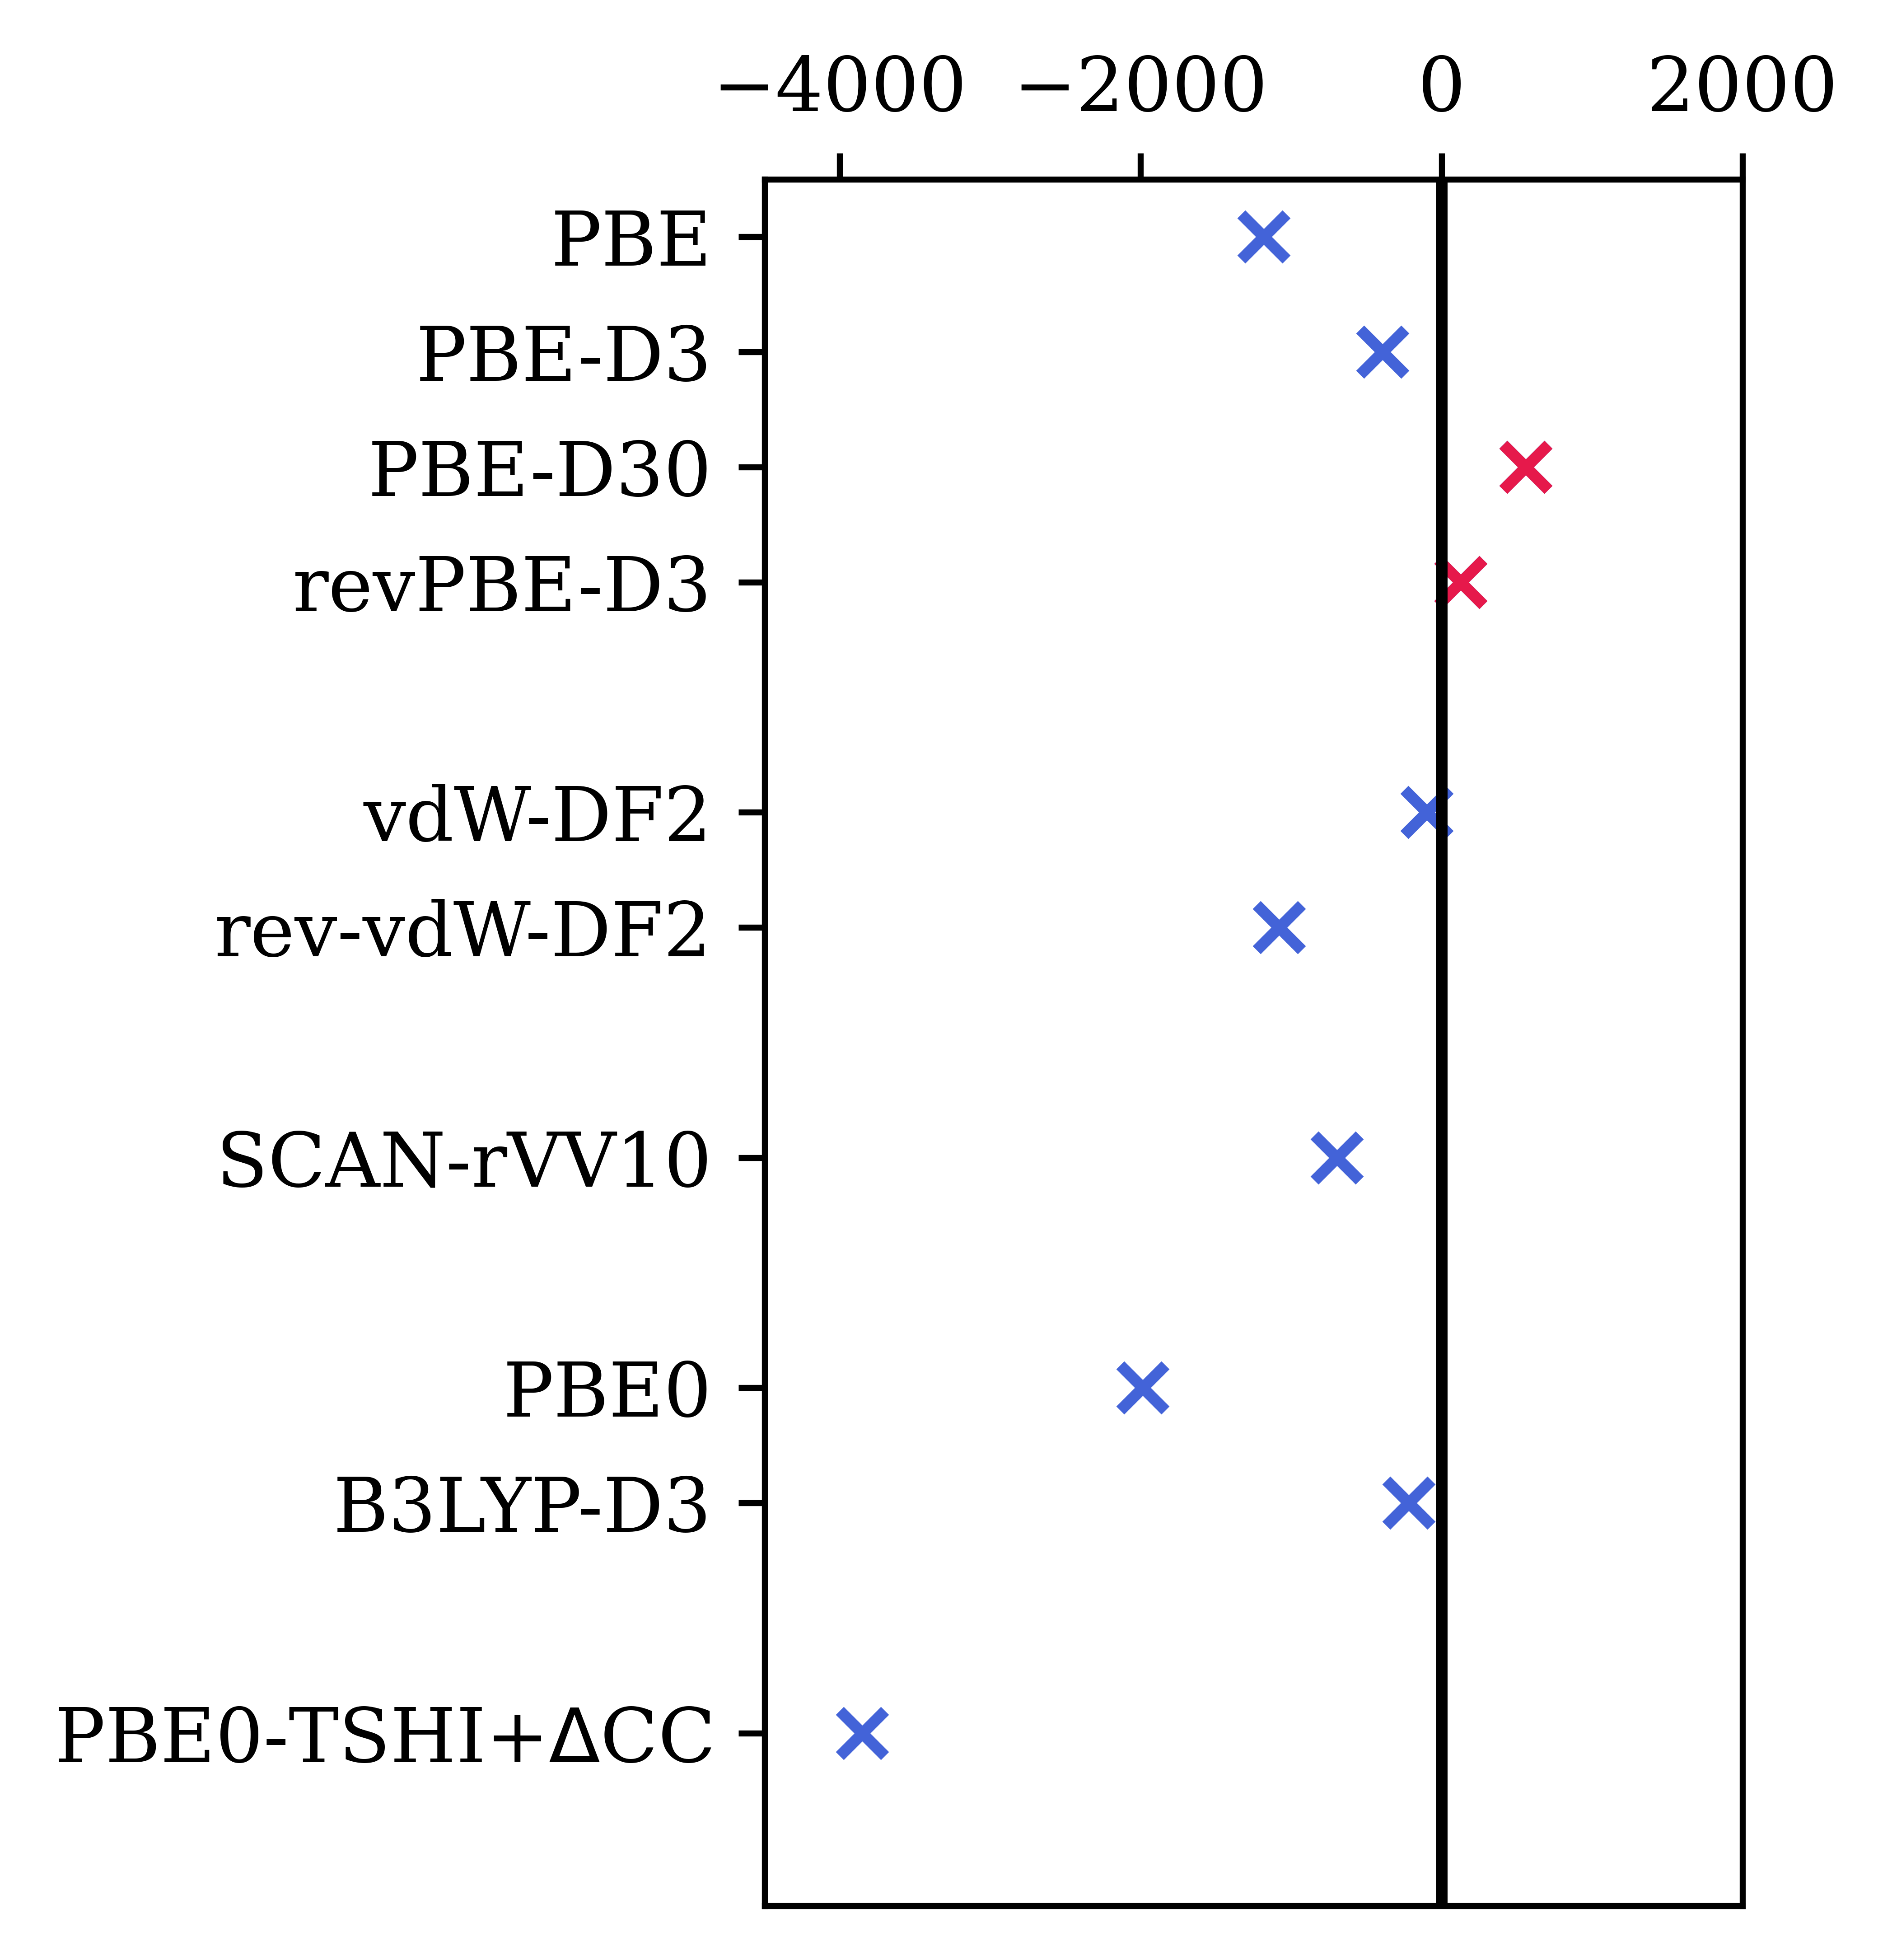

In [25]:
xc_functional_list = ['PBE','PBE-D2','PBE-D2-Ne','PBE-DDSC','PBE-D3','PBE-D30','PBE-TS','PBE-TSHI','PBE-D4','PBE-MBDHI','PBE-MBDFI','revPBE','revPBE-D3','revPBE-D4','PBEsol','PBEsol-D3','PBEsol-D4','vdW-DF','vdW-DF2','optB86b-vdW','rev-vdW-DF2','R2SCAN','R2SCAN-D3','R2SCAN-D4','SCAN-rVV10','PBE0','PBE0-D3','PBE0-D4','PBE0-TSHI','HSE06','HSE06-D4','B3LYP','B3LYP-D2','B3LYP-D3','B3LYP-D4','m06l']

full_methods_list = xc_functional_list + ['B2PLYP','HF','MP2','CCSD','CCSD(T)']

xc_rel_ene_list = {x: 0 for x in xc_functional_list}
ad_xc_rel_ene_list = {x: 0 for x in xc_functional_list}


# xc_rel_ene_list = { x:  {z : [] for z in full_methods_list} for x in ['Au','Ag','Cu']}
# xc_bind_ene_list = { x:  {z : [] for z in full_methods_list}   for x in ['Au','Ag','Cu']}

# xc_rel_ene_mad = { x:  {z : [] for z in full_methods_list}  for x in ['Au','Ag','Cu','Total']}
# xc_bind_ene_mad = { x:  {z : [] for z in full_methods_list}  for x in ['Au','Ag','Cu']}


# ene_au_clus_dft = []
# ene_au_clus_cc = []

for k in xc_functional_list:
    if k == 'optB86b-vdW':
        func_name = 'optB86b-vdw'
    elif k == 'rev-vdW-DF2':
        func_name = 'rev-vdw-DF2'
    elif k == 'PBE-D2-Ne':
        func_name = 'PBE-D2'.lower()
    elif k == 'PBE-D30':
        func_name = 'pbe-d3-0damp'
    elif k == 'B3LYP-D2-Ne':
        func_name = 'B3LYP-D2-Ne'.lower()
    else:
        func_name = k.lower()
    a1 = find_energy('Data/04-M20_MgO/DFT/1/{0}/AD_SLAB/OUTCAR'.format(func_name),code_format='vasp')
    a2 = find_energy('Data/04-M20_MgO/DFT/2/{0}/AD_SLAB/OUTCAR'.format(func_name),code_format='vasp')
    xc_rel_ene_list[k] = (a1-a2)*1000

    if k == 'PBE-TSHI':
        continue
    a1 = find_energy('Data/04-M20_MgO/DFT/1/{0}/AD/OUTCAR'.format(func_name),code_format='vasp')
    a2 = find_energy('Data/04-M20_MgO/DFT/2/{0}/AD/OUTCAR'.format(func_name),code_format='vasp')
    ad_xc_rel_ene_list[k] = (a1-a2)*1000

func_list_ordered = ['PBE','PBE-D3','PBE-D30','revPBE-D3','vdW-DF2','rev-vdW-DF2','SCAN-rVV10','PBE0','B3LYP-D3']
func_list_ene_ordered = []
func_list_val_ordered = [0,1,2,3,5,6,8,10,11]

for i in func_list_ordered:
    func_list_ene_ordered += [xc_rel_ene_list[i]]


fig, axs = plt.subplots(figsize=(3.375,3.5),dpi=1200,constrained_layout=True)

axs.scatter(func_list_ene_ordered,func_list_val_ordered,marker='x',color=color_dict['blue'])
axs.scatter(func_list_ene_ordered[2:4],func_list_val_ordered[2:4],marker='x',color=color_dict['red'])
axs.scatter([func_list_ene_ordered[-2] + -1865.12541],[13],marker='x',color=color_dict['blue'])


axs.vlines(0,-1,15,color=color_dict['black'])

axs.set_ylim([14.5,-0.5])
# axs.set_xlabel(r'Difference between 2D and 3D structures (meV)')
axs.xaxis.set_label_position('top') 
axs.xaxis.tick_top()
# axs.set_xticks([1000,0,])
axs.set_xlim([-4500,2000])

axs.set_yticks(func_list_val_ordered + [13])
axs.set_yticklabels(func_list_ordered + [r'PBE0-TSHI+$\Delta$CC'])

plt.savefig('Figures/Fig_04.png')

In [26]:
func_list_ene_ordered

[-1181.3905499998327,
 -392.3160500003178,
 560.4502299997876,
 127.2444500000347,
 -96.98157000002539,
 -1080.1192000001265,
 -696.3187199999084,
 -1986.1268599997857,
 -217.2094699999434]

In [27]:
a1 = find_energy('Data/04-M20_MgO/CC/1/1/mrcc.out'.format(func_name),code_format='mrcc',typ = 'lccsdt_tot')
a2 = find_energy('Data/04-M20_MgO/CC/2/1/mrcc.out'.format(func_name),code_format='mrcc',typ = 'lccsdt_tot')
print(a1,a2)
ad_xc_rel_ene_list['CC'] = (a1-a2)*1000*Hartree

-2711.738284213131 -2711.572188057733


In [28]:
ad_xc_rel_ene_list

{'PBE': -1897.9976399999998,
 'PBE-D2': -4443.598430000002,
 'PBE-D2-Ne': -4443.598430000002,
 'PBE-DDSC': -2572.68122,
 'PBE-D3': -2957.8783499999945,
 'PBE-D30': -3113.004680000003,
 'PBE-TS': -2397.2993600000054,
 'PBE-TSHI': 0,
 'PBE-D4': -3086.832179999995,
 'PBE-MBDHI': -2709.4348899999973,
 'PBE-MBDFI': -3112.5830800000003,
 'revPBE': -1255.1795800000036,
 'revPBE-D3': -3402.495090000002,
 'revPBE-D4': -3329.430959999996,
 'PBEsol': -2833.691309999999,
 'PBEsol-D3': -3561.149649999997,
 'PBEsol-D4': -3300.2253400000045,
 'vdW-DF': -1726.2044500000009,
 'vdW-DF2': -1284.4394599999998,
 'optB86b-vdW': -3164.6453,
 'rev-vdW-DF2': -2978.5498000000002,
 'R2SCAN': -2630.565639999986,
 'R2SCAN-D3': -2958.8882900000044,
 'R2SCAN-D4': -2883.7734299999056,
 'SCAN-rVV10': -2904.4204099998296,
 'PBE0': -2537.832690000002,
 'PBE0-D3': -3672.5812300000057,
 'PBE0-D4': -3613.026050000002,
 'PBE0-TSHI': -2987.07658,
 'HSE06': -2441.027609999999,
 'HSE06-D4': -3499.1092399999957,
 'B3LYP': -1242

In [29]:
xc_rel_ene_list

{'PBE': -1181.3905499998327,
 'PBE-D2': -648.5108199999559,
 'PBE-D2-Ne': -648.5108199999559,
 'PBE-DDSC': -660.8502999997654,
 'PBE-D3': -392.3160500003178,
 'PBE-D30': 560.4502299997876,
 'PBE-TS': 725.6341500001326,
 'PBE-TSHI': -755.6538700000601,
 'PBE-D4': -1039.1252899999017,
 'PBE-MBDHI': 0.0,
 'PBE-MBDFI': 0.0,
 'revPBE': -1251.9178000002285,
 'revPBE-D3': 127.2444500000347,
 'revPBE-D4': -1078.3474999998361,
 'PBEsol': -1394.6003500000188,
 'PBEsol-D3': -333.86250000012296,
 'PBEsol-D4': -1000.3221299998586,
 'vdW-DF': -521.4161199999126,
 'vdW-DF2': -96.98157000002539,
 'optB86b-vdW': -966.774740000119,
 'rev-vdW-DF2': -1080.1192000001265,
 'R2SCAN': -1152.2188399994775,
 'R2SCAN-D3': -556.5174700004718,
 'R2SCAN-D4': -848.4969700002694,
 'SCAN-rVV10': -696.3187199999084,
 'PBE0': -1986.1268599997857,
 'PBE0-D3': -1087.9156099999818,
 'PBE0-D4': 0.0,
 'PBE0-TSHI': 2981989.1568,
 'HSE06': 2839923.19833,
 'HSE06-D4': -1676.7796199997065,
 'B3LYP': -1314.5255699996596,
 'B3LYP-

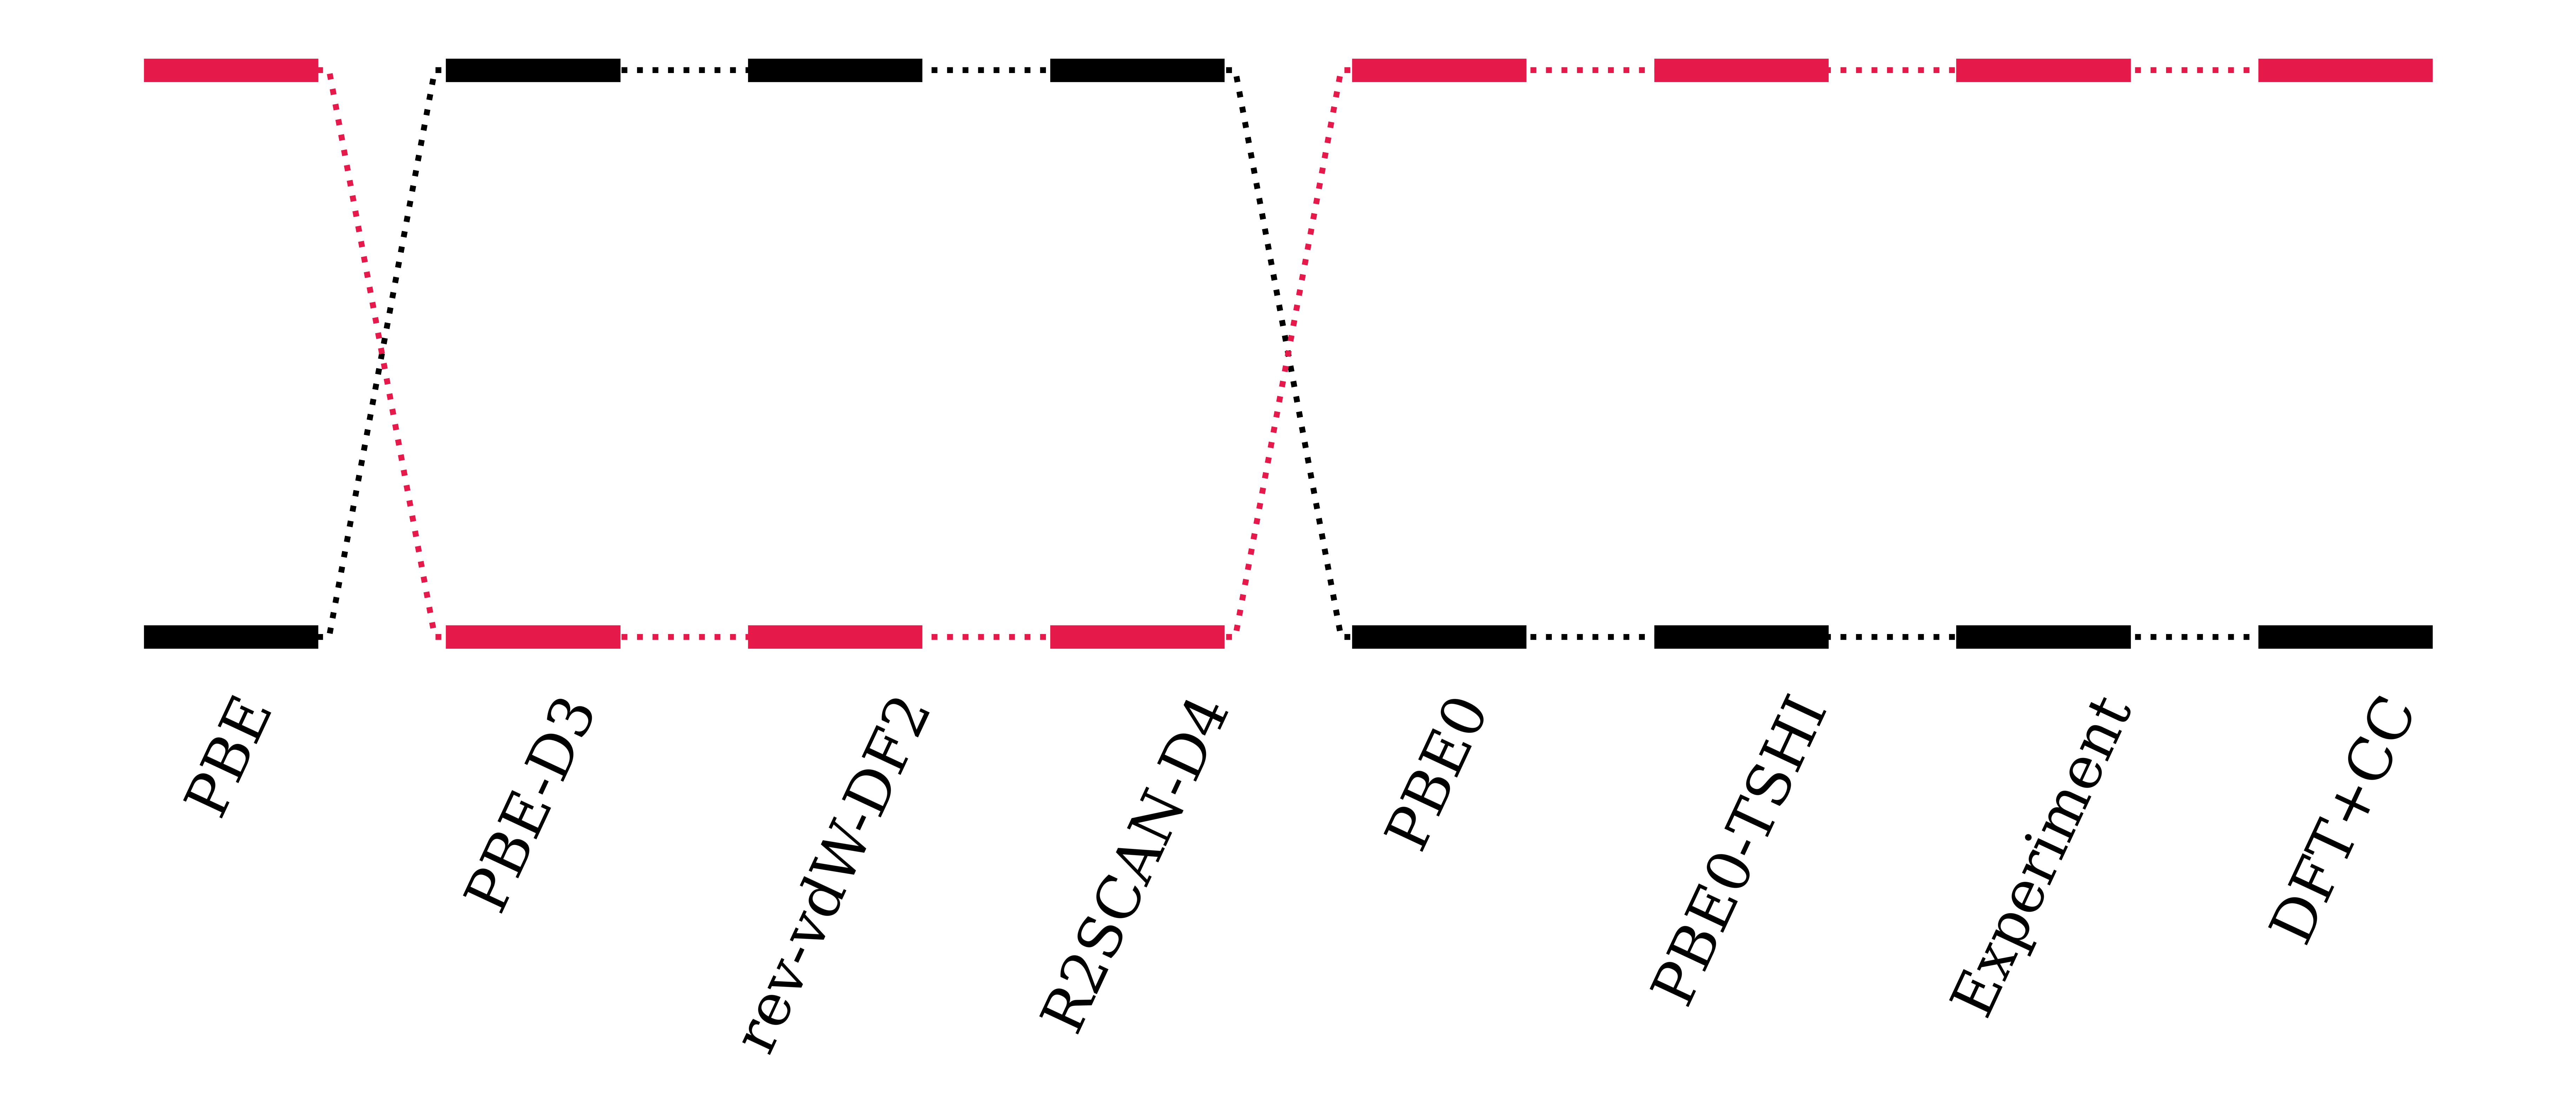

In [30]:
# Making Figure 1

fig, axs = plt.subplots(figsize=(6,2.5),dpi=1200, sharey=True,sharex=True,constrained_layout=True)

width = 0.5

functional_order = {
    'PBE': [1,2,3,4],
    'PBE-D3': [2,1,3,4],
    'rev-vdW-DF2': [2,1,4,3],
    'R2SCAN-D4': [2,1,3,4],
    'PBE0': [1,2,4,3],
    'PBE0-TSHI': [1,2,3,4],
    'Experiment': [1,2,3,4],
    'DFT+CC': [1,2,3,4]
}

order_1 = []
order_2 = []
order_3 = []
order_4 = []

for i in functional_order:
    order_1 += [functional_order[i].index(1)]
    order_2 += [functional_order[i].index(2)]
    order_3 += [functional_order[i].index(3)]
    order_4 += [functional_order[i].index(4)]


functional_start_location = list(range(1,len(order_1)+1))
functional_order_location = [1,1.5,2,2.5]

order_1_doubled = []
order_2_doubled = []
order_3_doubled = []
order_4_doubled = []
order_locations = []

super_width = width+0.15

for i in range(len(order_1)):
    for j in [-super_width/2,super_width/2]:
        order_1_doubled += [functional_order_location[order_1[i]]]
        order_2_doubled += [functional_order_location[order_2[i]]]
        order_3_doubled += [functional_order_location[order_3[i]]]
        order_4_doubled += [functional_order_location[order_4[i]]]
        order_locations += [functional_start_location[i] + j]


order_locations[0] = order_locations[0] + 0.2
order_locations[-1] = order_locations[-1] - 0.2


axs.plot(order_locations,order_1_doubled,':',color=color_dict['black'],linewidth=1)
axs.plot(order_locations,order_2_doubled,':',color=color_dict['red'],linewidth=1)

# axs.plot(order_3_doubled,order_locations,':',color=color_dict['blue'],linewidth=1)
# axs.plot(order_4_doubled,order_locations,':',color=color_dict['green'],linewidth=1)

for i in range(8):
    axs.plot([functional_start_location[i] + width/2,functional_start_location[i]-width/2],[functional_order_location[order_1[i]], functional_order_location[order_1[i]]],color=color_dict['black'],linewidth=4)
    axs.plot([functional_start_location[i] + width/2,functional_start_location[i]-width/2],[functional_order_location[order_2[i]], functional_order_location[order_2[i]]],color=color_dict['red'],linewidth=4)
#     axs.plot([functional_order_location[order_3[i]], functional_order_location[order_3[i]]],[functional_start_location[i] + width/2,functional_start_location[i]-width/2],color=color_dict['blue'],linewidth=4)
#     axs.plot([functional_order_location[order_4[i]], functional_order_location[order_4[i]]],[functional_start_location[i] + width/2,functional_start_location[i]-width/2],color=color_dict['green'],linewidth=4)

axs.set_xticks(functional_start_location)
axs.set_xticklabels([x for x in functional_order],rotation=65)

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_yticks([])
axs.xaxis.set_tick_params(length=0)


# axs.set_ylim([8,0])

plt.savefig('Figures/Fig_01.png')



In [31]:
# # Making Figure 1

# fig, axs = plt.subplots(figsize=(3.375,4),dpi=1200, sharey=True,sharex=True,constrained_layout=True)

# width = 0.5

# functional_order = {
#     'DFT+CC': [1,2,3,4],
#     'PBE': [1,2,3,4],
#     'PBE-D3': [2,1,3,4],
#     'rev-vdW-DF2': [2,1,4,3],
#     'R2SCAN-rVV10': [2,1,3,4],
#     'PBE0': [1,4,2,3],
#     'PBE0-TSHI': [1,3,2,4]
# }

# order_1 = []
# order_2 = []
# order_3 = []
# order_4 = []

# for i in functional_order:
#     order_1 += [functional_order[i].index(1)]
#     order_2 += [functional_order[i].index(2)]
#     order_3 += [functional_order[i].index(3)]
#     order_4 += [functional_order[i].index(4)]


# functional_start_location = list(range(1,len(order_1)+1))
# functional_order_location = [1,1.5,2,2.5]

# order_1_doubled = []
# order_2_doubled = []
# order_3_doubled = []
# order_4_doubled = []
# order_locations = []

# super_width = width+0.15

# for i in range(len(order_1)):
#     for j in [-super_width/2,super_width/2]:
#         order_1_doubled += [functional_order_location[order_1[i]]]
#         order_2_doubled += [functional_order_location[order_2[i]]]
#         order_3_doubled += [functional_order_location[order_3[i]]]
#         order_4_doubled += [functional_order_location[order_4[i]]]
#         order_locations += [functional_start_location[i] + j]


# order_locations[0] = order_locations[0] + 0.2
# order_locations[-1] = order_locations[-1] - 0.2


# axs.plot(order_1_doubled,order_locations,':',color=color_dict['black'],linewidth=1)
# axs.plot(order_2_doubled,order_locations,':',color=color_dict['red'],linewidth=1)

# axs.plot(order_3_doubled,order_locations,':',color=color_dict['blue'],linewidth=1)
# axs.plot(order_4_doubled,order_locations,':',color=color_dict['green'],linewidth=1)

# for i in range(7):
#     axs.plot([functional_order_location[order_1[i]], functional_order_location[order_1[i]]],[functional_start_location[i] + width/2,functional_start_location[i]-width/2],color=color_dict['black'],linewidth=4)
#     axs.plot([functional_order_location[order_2[i]], functional_order_location[order_2[i]]],[functional_start_location[i] + width/2,functional_start_location[i]-width/2],color=color_dict['red'],linewidth=4)
#     axs.plot([functional_order_location[order_3[i]], functional_order_location[order_3[i]]],[functional_start_location[i] + width/2,functional_start_location[i]-width/2],color=color_dict['blue'],linewidth=4)
#     axs.plot([functional_order_location[order_4[i]], functional_order_location[order_4[i]]],[functional_start_location[i] + width/2,functional_start_location[i]-width/2],color=color_dict['green'],linewidth=4)

# axs.set_yticks(functional_start_location)
# axs.set_yticklabels([x for x in functional_order])

# axs.spines['right'].set_visible(False)
# axs.spines['top'].set_visible(False)
# axs.spines['bottom'].set_visible(False)
# axs.spines['left'].set_visible(False)
# axs.set_xticks([])
# axs.yaxis.set_tick_params(length=0)


# axs.set_ylim([8,0])

# plt.savefig('Figures/Fig_01.png')



In [32]:
[1,2,3,4].index(4)

3

In [33]:
order_locations


[0.875,
 1.325,
 1.675,
 2.325,
 2.675,
 3.325,
 3.675,
 4.325,
 4.675,
 5.325,
 5.675,
 6.325,
 6.675,
 7.325,
 7.675,
 8.125]

In [34]:
# Looking at the Au tetramer on MgO system

xc_functional_list = ['PBE','PBE-D2','PBE-D2-Ne','PBE-DDSC','PBE-D3','PBE-TS','PBE-TSHI','PBE-D4','PBE-MBDHI','PBE-MBDFI','revPBE','revPBE-D3','revPBE-D4','PBEsol','PBEsol-D3','PBEsol-D4','vdW-DF','vdW-DF2','optB86b-vdW','rev-vdW-DF2','R2SCAN','R2SCAN-D3','R2SCAN-D4','SCAN-rVV10','PBE0','PBE0-D3','PBE0-D4','PBE0-TSHI','HSE06','HSE06-D4','B3LYP-D2','B3LYP-D2-Ne','B3LYP-D3','B3LYP-D4']

full_methods_list = xc_functional_list + ['B2PLYP','HF','MP2','CCSD','CCSD(T)']

xc_rel_ene_list = { x:  {z : [] for z in full_methods_list} for x in ['Au','Ag','Cu']}
xc_bind_ene_list = { x:  {z : [] for z in full_methods_list}   for x in ['Au','Ag','Cu']}

xc_rel_ene_mad = { x:  {z : [] for z in full_methods_list}  for x in ['Au','Ag','Cu','Total']}
xc_bind_ene_mad = { x:  {z : [] for z in full_methods_list}  for x in ['Au','Ag','Cu']}


ene_au_clus_dft = []
ene_au_clus_cc = []

for i in ['Au']: #,'Ag','Cu']:   
    for j in [1,2,3,4]:
        for k in xc_functional_list:
            if k == 'optB86b-vdW':
                func_name = 'optB86b-vdw'
            elif k == 'rev-vdW-DF2':
                func_name = 'rev-vdw-DF2'
            elif k == 'PBE-D2-Ne':
                func_name = 'PBE-D2'.lower()
            elif k == 'B3LYP-D2-Ne':
                func_name = 'B3LYP-D2'.lower()
            else:
                func_name = k.lower()
            a = find_energy('Data/03-M4_MgO/DFT/{0}4/{1}/{2}/AD_SLAB/OUTCAR'.format(i,j,func_name),code_format='vasp')
            a0 = find_energy('Data/03-M4_MgO/DFT/{0}4/1/{1}/AD_SLAB/OUTCAR'.format(i,func_name),code_format='vasp')
            xc_rel_ene_list[i][k] += [(a-a0)*1000]

        ene_hf = []
        ene_mp2 = []
        ene_ccsd = []
        ene_ccsdt = []
        ene_dft = []
        ene_b2plyp = [] 
        for m in [1,3,2]:
            root_folder = 'Data/03-M4_MgO/cWFT/CCSDT/{0}/{1}/{2}/AD_SLAB/mrcc.out'.format(i,j,m)
            root_folder_b2plyp = 'Data/03-M4_MgO/cWFT/B2PLYP/{0}/{1}/{2}/mrcc.out'.format(i,j,m)

            ene_hf += [find_energy(root_folder,code_format='mrcc',typ='hf')]
            ene_mp2 += [find_energy(root_folder,code_format='mrcc',typ='lmp2')]
            ene_ccsd += [find_energy(root_folder,code_format='mrcc',typ='lccsd')]
            ene_ccsdt += [find_energy(root_folder,code_format='mrcc',typ='lccsdt')]
            ene_dft += [find_energy(root_folder_b2plyp,code_format='mrcc',typ='hf')]
            ene_b2plyp += [find_energy(root_folder_b2plyp,code_format='mrcc',typ='B2PLYP')]


        dummy_dict ={
            'MP2': extrapolate.get_cbs(ene_hf[0],ene_mp2[0],ene_hf[1],ene_mp2[1],X=3,Y=4,family='mixcc',\
            convert_Hartree=False ,shift=0.0,output=False),
            'CCSD': extrapolate.get_cbs(ene_hf[0],ene_ccsd[0],ene_hf[1],ene_ccsd[1],X=3,Y=4,family='mixcc',\
            convert_Hartree=False ,shift=0.0,output=False),
            'CCSD(T)': extrapolate.get_cbs(ene_hf[0],ene_ccsdt[0],ene_hf[1],ene_ccsdt[1],X=3,Y=4,family='mixcc',\
            convert_Hartree=False ,shift=0.0,output=False),
            'B2PLYP': extrapolate.get_cbs(ene_dft[0],ene_b2plyp[0],ene_dft[1],ene_b2plyp[1],X=3,Y=4,family='mixcc',\
            convert_Hartree=False ,shift=0.0,output=False)
        }
        # print(dummy_dict)
        xc_bind_ene_list[i]['HF'] += [dummy_dict['MP2'][0]]
        xc_bind_ene_list[i]['MP2'] += [dummy_dict['MP2'][-1] + ene_mp2[-1] - ene_mp2[0]]
        xc_bind_ene_list[i]['CCSD'] += [dummy_dict['CCSD'][-1] + ene_ccsd[-1] - ene_ccsd[0]]
        xc_bind_ene_list[i]['CCSD(T)'] += [dummy_dict['CCSD(T)'][-1] + ene_ccsdt[-1] - ene_ccsdt[0]]
        xc_bind_ene_list[i]['B2PLYP'] += [dummy_dict['B2PLYP'][-1] + ene_b2plyp[-1] - ene_b2plyp[0]]

        # xc_rel_ene_list[i][j]['HF'] += [(dummy_dict['MP2'][0] - xc_bind_ene_list[i][j]['HF'][0])*1000]

        for m in ['HF','MP2','CCSD','CCSD(T)','B2PLYP']:
            xc_rel_ene_list[i][m] += [(xc_bind_ene_list[i][m][-1]- xc_bind_ene_list[i][m][0])*1000*Hartree]

        ene_hf = []
        ene_ccsdt = []
        
        for m in [1,3,2]:
            root_folder = 'Data/03-M4_MgO/cWFT/CCSDT/Cluster_Corr/{0}/{1}/{2}/mrcc.out'.format(i,j,m)

            ene_hf += [find_energy(root_folder,code_format='mrcc',typ='hf')]
            ene_ccsdt += [find_energy(root_folder,code_format='mrcc',typ='lccsdt')]

        dummy_dict_cc_clus = extrapolate.get_cbs(ene_hf[0],ene_ccsdt[0],ene_hf[1],ene_ccsdt[1],X=3,Y=4,family='mixcc',\
            convert_Hartree=False ,shift=0.0,output=False)
        
        if j == 1:
            ene_clus_cc0 = (dummy_dict_cc_clus[-1] + ene_ccsdt[-1] - ene_ccsdt[0])*Hartree*1000

        ene_clus_cc = (dummy_dict_cc_clus[-1] + ene_ccsdt[-1] - ene_ccsdt[0])*Hartree*1000 
        ene_clus_cc_delta = ene_clus_cc - ene_clus_cc0
        for k in xc_functional_list: # ['PBE','vdW-DF','R2SCAN','PBE0-TSHI']:
            if k == 'optB86b-vdW':
                func_name = 'optB86b-vdw'
            elif k == 'rev-vdW-DF2':
                func_name = 'rev-vdw-DF2'
            elif k == 'PBE-D2-Ne':
                func_name = 'PBE-D2'.lower()
            elif k == 'B3LYP-D2-Ne':
                func_name = 'B3LYP-D2'.lower()
            else:
                func_name = k.lower()

            if j == 1:
                xc_rel_ene_list[i]['{0}+CC'.format(k)] = []
                xc_rel_ene_mad[i]['{0}+CC'.format(k)] = 0

            a = find_energy('Data/03-M4_MgO/DFT/{0}4/{1}/{2}/AD/OUTCAR'.format(i,j,func_name),code_format='vasp')
            a0 = find_energy('Data/03-M4_MgO/DFT/{0}4/1/{1}/AD/OUTCAR'.format(i,func_name),code_format='vasp')
            ene_clus_delta_pbe0tshi = (a-a0)*1000
            if k == 'PBE':
                ene_au_clus_dft += [ene_clus_delta_pbe0tshi]
                ene_au_clus_cc += [ene_clus_cc_delta]
                # print(ene_clus_cc_deltaene_clus_delta_pbe0tshi)
            delta_correction = ene_clus_cc_delta - ene_clus_delta_pbe0tshi
            # print(ene_clus_cc_delta,ene_clus_delta_pbe0tshi)
            xc_rel_ene_list[i]['{0}+CC'.format(k)] += [xc_rel_ene_list[i][k][-1] + delta_correction]
        # print(dummy_dict)
        # xc_bind_ene_list[i]['HF'] += [dummy_dict['MP2'][0]]
        # xc_bind_ene_list[i]['MP2'] += [dummy_dict['MP2'][-1] + ene_mp2[-1] - ene_mp2[0]]
        # xc_bind_ene_list[i]['CCSD'] += [dummy_dict['CCSD'][-1] + ene_ccsd[-1] - ene_ccsd[0]]
        # xc_bind_ene_list[i]['CCSD(T)'] += [dummy_dict['CCSD(T)'][-1] + ene_ccsdt[-1] - ene_ccsdt[0]]
        # xc_bind_ene_list[i]['B2PLYP'] += [dummy_dict['B2PLYP'][-1] + ene_b2plyp[-1] - ene_b2plyp[0]]


In [35]:
for j in xc_rel_ene_list['Au']: #xc_functional_list + ['B2PLYP','HF','MP2','CCSD','DFT+CC']:
    # print(j)
    for i in ['Au']:
        # print(j,i)
        xc_rel_ene_mad[i][j] = np.sum([abs(xc_rel_ene_list[i][j][l] - xc_rel_ene_list[i]['CCSD(T)'][l]) for l in list(range(1,4))])/3

    # print(np.sum([xc_rel_ene_mad[l]['Total'][j] for l in ['Au','Ag','Cu']])/3,np.sum([xc_rel_ene_mad['Total'][l][j] for l in [4,6,8]])/3)

    # xc_rel_ene_mad['Total']['Total'][j] = np.sum([xc_rel_ene_mad[l]['Total'][j] for l in ['Au','Ag','Cu']])/3

In [36]:
xc_rel_ene_mad['Au']

{'PBE': 191.06407706360358,
 'PBE-D2': 193.40230730556925,
 'PBE-D2-Ne': 193.40230730556925,
 'PBE-DDSC': 178.16508459637396,
 'PBE-D3': 179.75538792953364,
 'PBE-TS': 215.63227459628968,
 'PBE-TSHI': 141.31067039698357,
 'PBE-D4': 163.03302126303413,
 'PBE-MBDHI': 138.0514870635475,
 'PBE-MBDFI': 211.06740126302418,
 'revPBE': 258.59724706361266,
 'revPBE-D3': 281.09701126291645,
 'revPBE-D4': 242.59198792954024,
 'PBEsol': 89.18553706361176,
 'PBEsol-D3': 65.52047397229273,
 'PBEsol-D4': 46.971940396941626,
 'vdW-DF': 292.19391126290054,
 'vdW-DF2': 375.88512459622007,
 'optB86b-vdW': 141.12983459622944,
 'rev-vdW-DF2': 143.34955792953636,
 'R2SCAN': 132.96652706357102,
 'R2SCAN-D3': 92.3206637302324,
 'R2SCAN-D4': 106.82794373024554,
 'SCAN-rVV10': 129.17605269435873,
 'PBE0': 129.42346706363898,
 'PBE0-D3': 103.62605397230918,
 'PBE0-D4': 74.66800459624926,
 'PBE0-TSHI': 83.52135039700006,
 'HSE06': 135.25812039693412,
 'HSE06-D4': 75.99693792947123,
 'B3LYP-D2': 274.62791730561605

In [37]:
xc_rel_ene_list['Au']['CCSD(T)']

[0.0, 709.9699109358797, 1046.8461062989982, 1343.0269165538482]

In [38]:
xc_rel_ene_list['Au']['PBE0-TSHI']

[0.0, 668.2599399998708, 1133.0975999999282, 1220.424329999787]

In [39]:
xc_rel_ene_list['Au']['PBE0-TSHI+CC']

[0.0, 720.0557402517734, 1033.6664912693766, 1463.7623421479411]

In [40]:
ene_au_clus_dft

[0.0, -179.15939999999964, -180.86156999999935, 525.2113999999999]

In [41]:
ene_au_clus_cc

[0.0, -55.42569974809885, -229.6507987305522, 840.1346721481532]

/home/shixubenjamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparency" which is no longer supported as of 3.3 and will become an error in 3.6
/home/shixubenjamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparency" which is no longer supported as of 3.3 and will become an error in 3.6


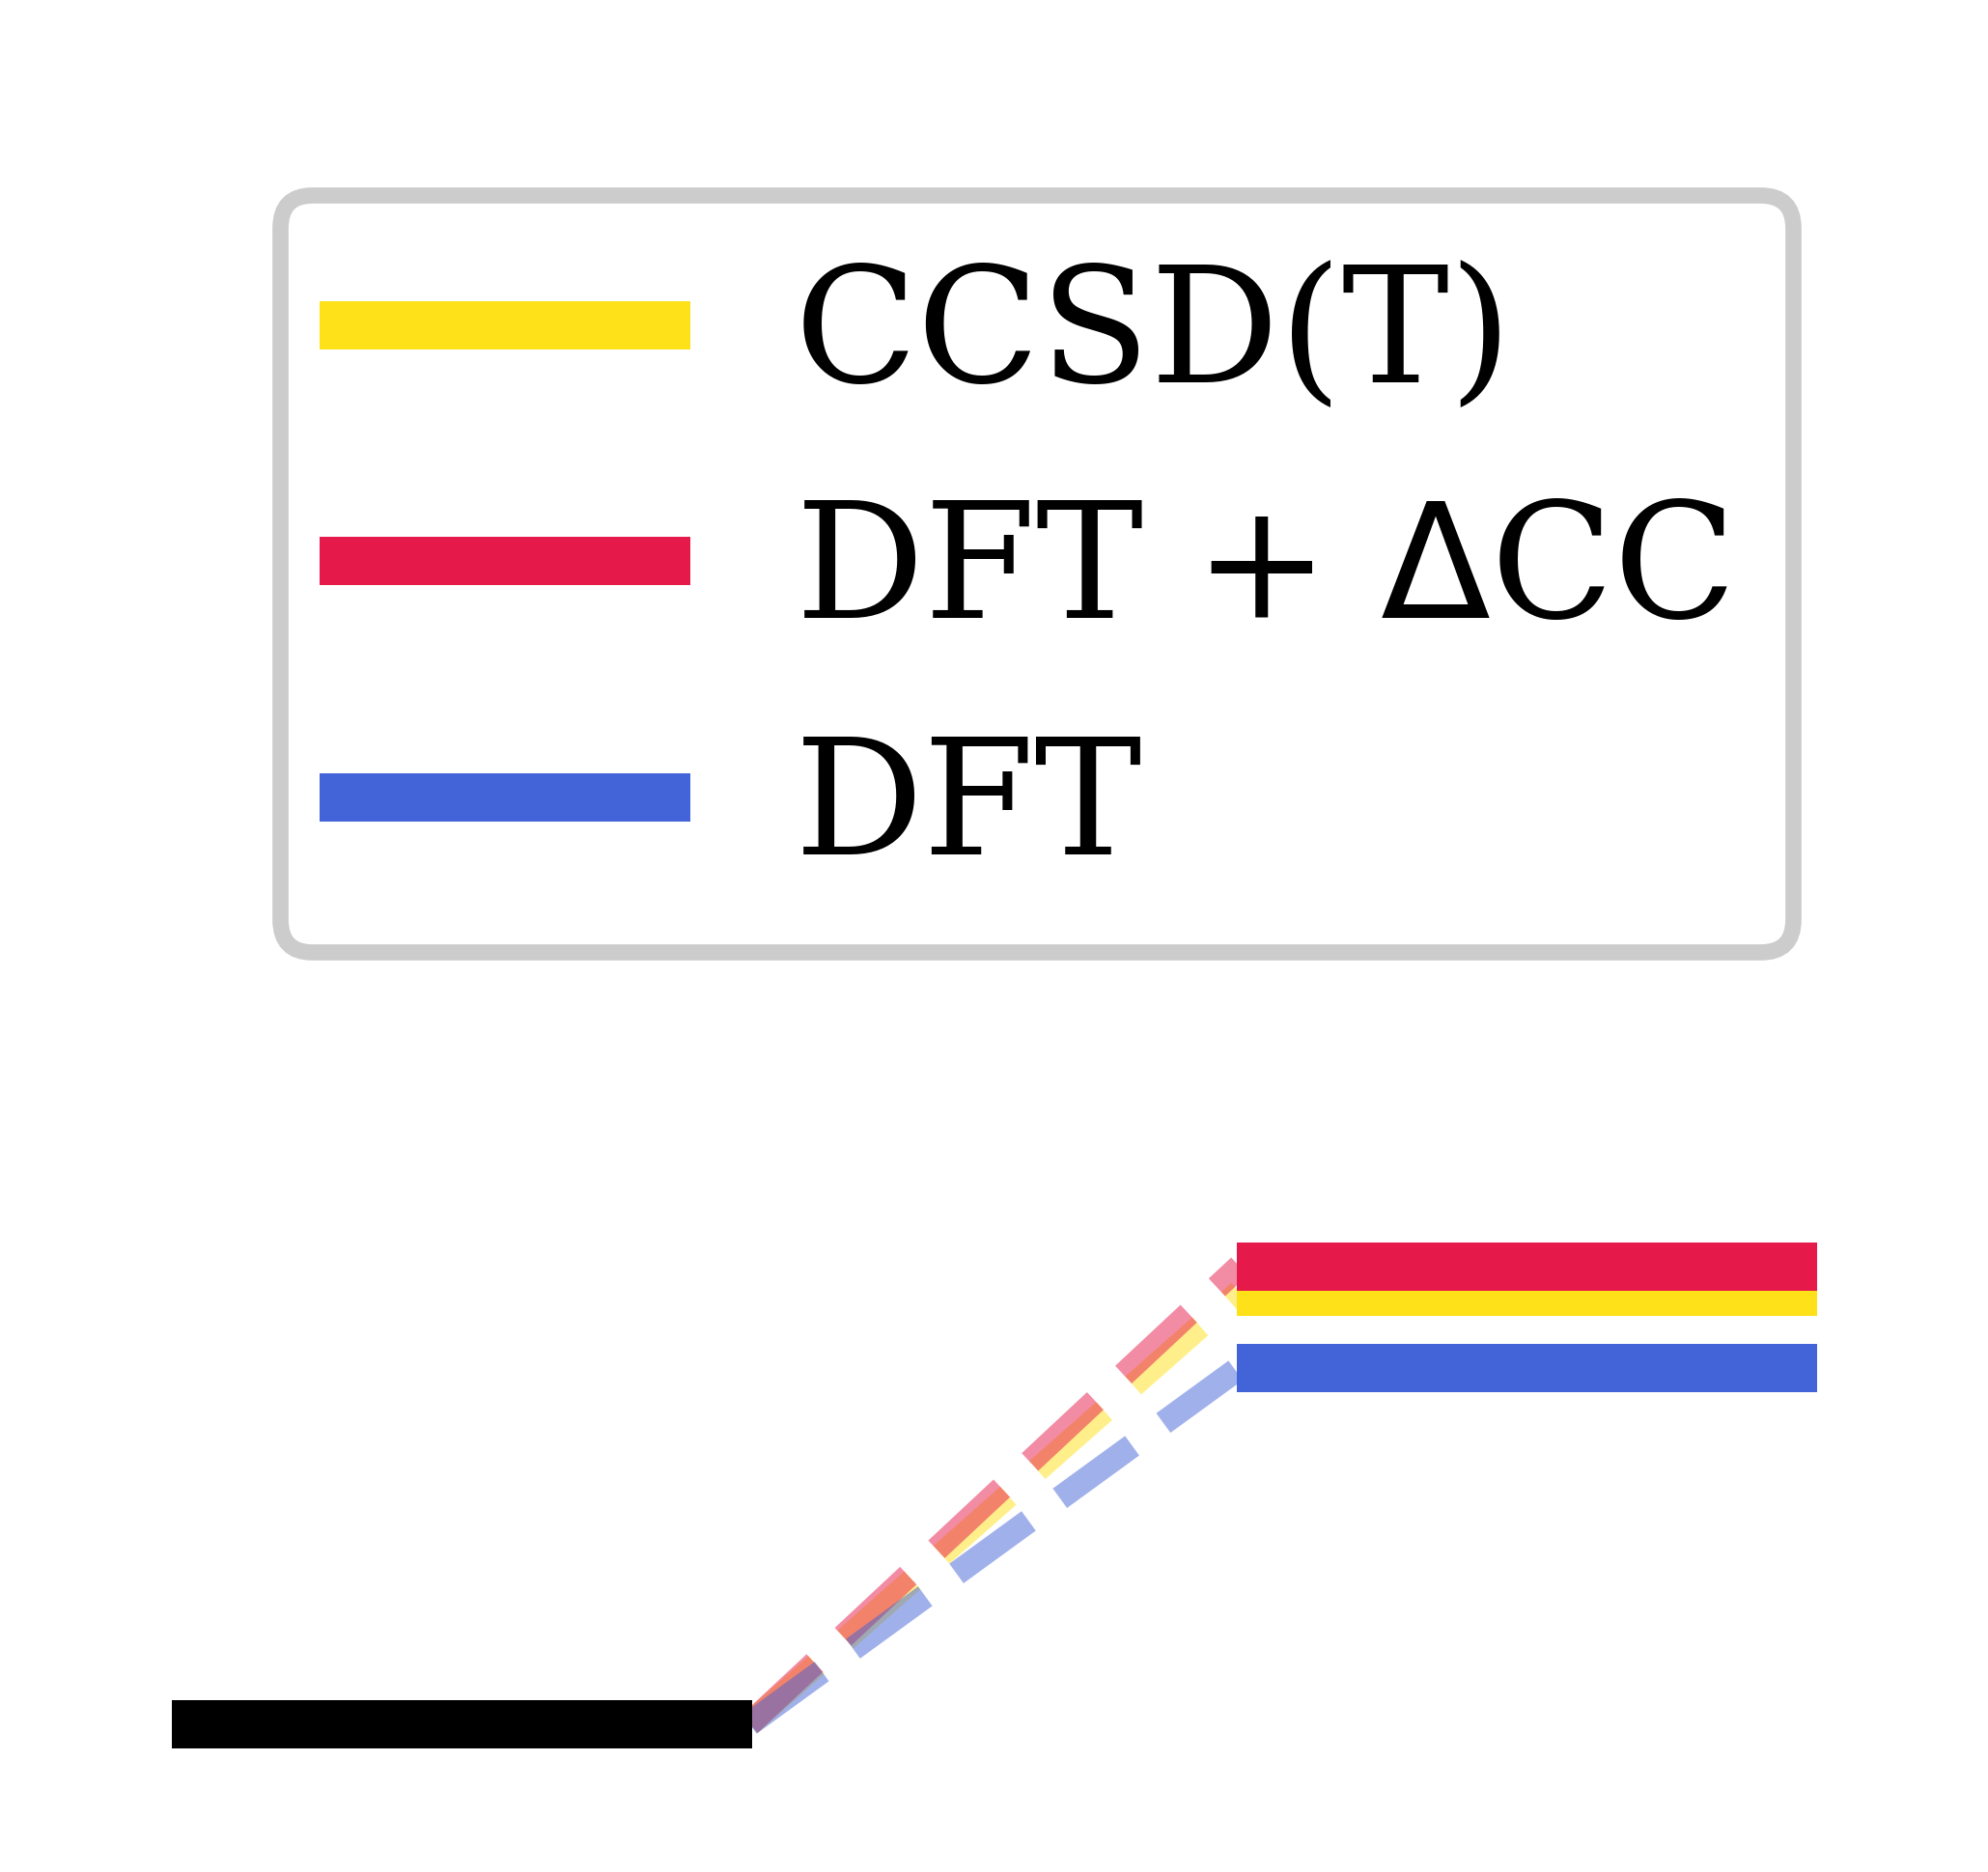

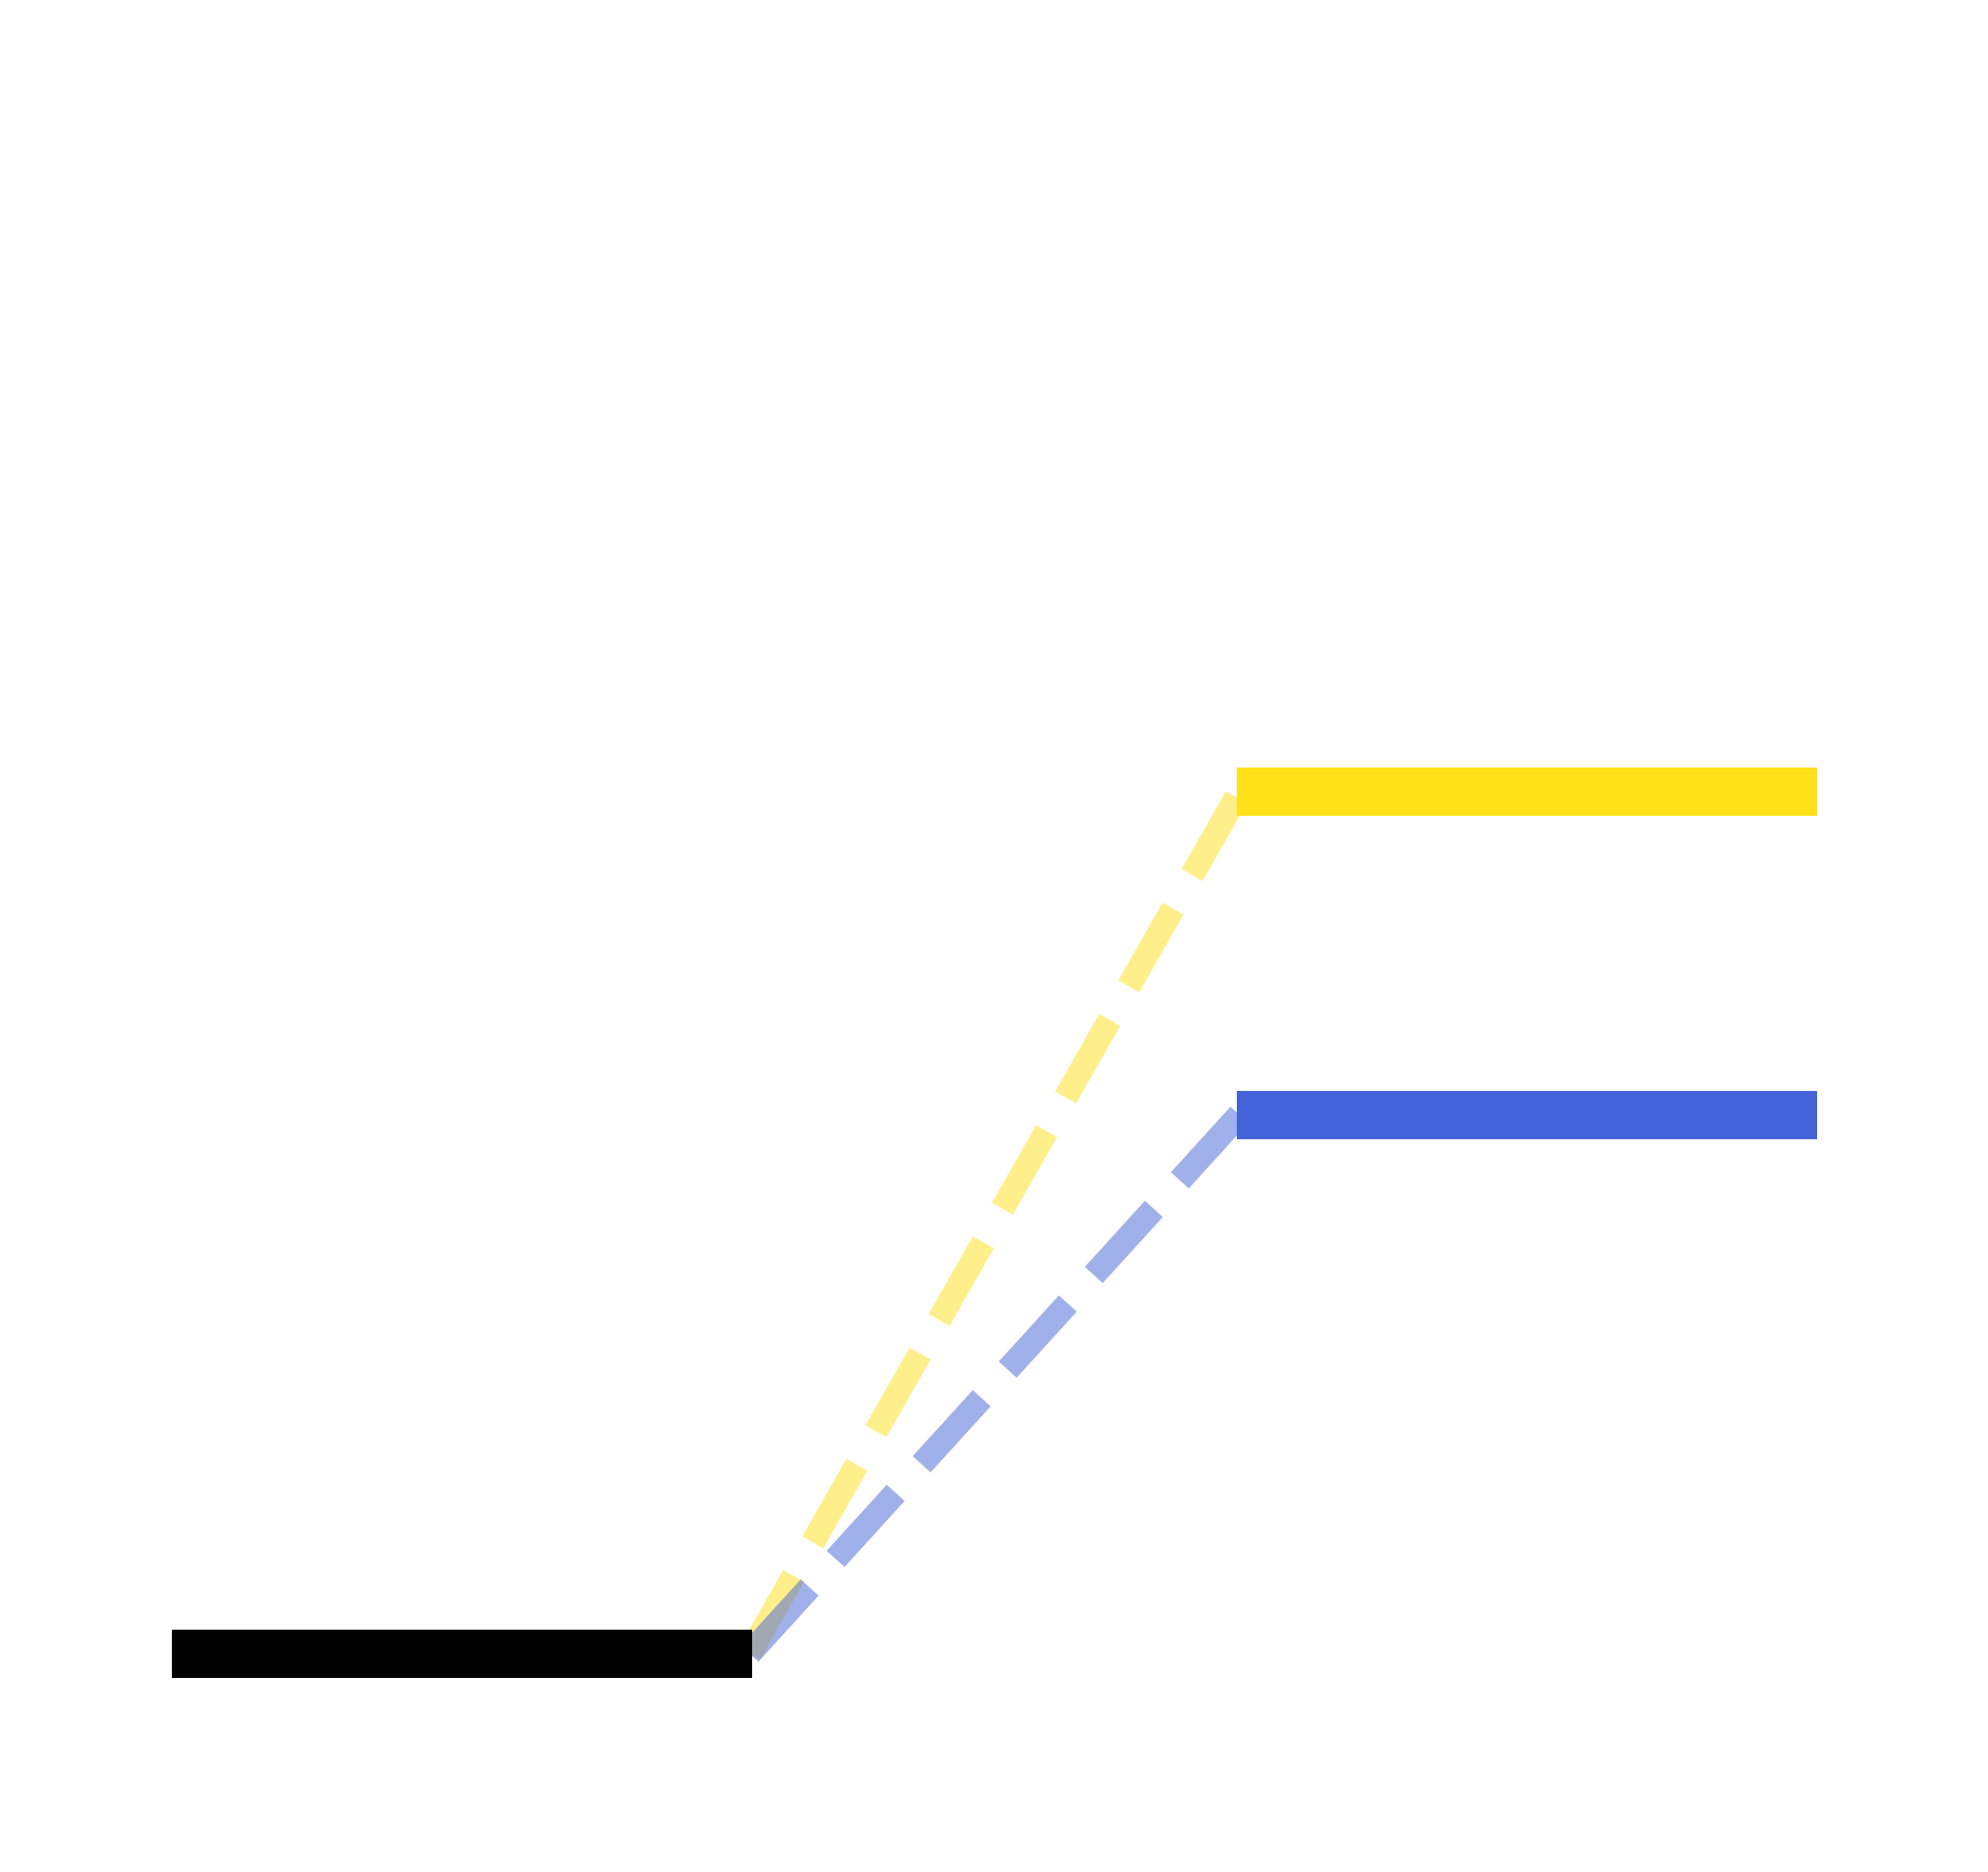

In [42]:
fig, axs = plt.subplots(figsize=(1.6,1.5),dpi=1200,constrained_layout=True)

functional_xc_test = 'PBE'

tetramer_start_x_pos = [1,3,5,3]

linelinewidth = 1.5
barbarwidth = 3

for i in range(4):
    if i < 1:
        width = 0.04
        # axs.plot([tetramer_start_x_pos[i]+1,tetramer_start_x_pos[i]+2],[ene_au_clus_cc[i], ene_au_clus_cc[i+1]],':',color=color_dict['orange'],alpha=0.5,linewidth=1)
        axs.plot([tetramer_start_x_pos[i]+1+width,tetramer_start_x_pos[i]+2 - width],[xc_rel_ene_list['Au']['CCSD(T)'][i], xc_rel_ene_list['Au']['CCSD(T)'][i+3]],'--',color=color_dict['yellow'],alpha=0.5,linewidth=linelinewidth)
        axs.plot([tetramer_start_x_pos[i]+1 + width,tetramer_start_x_pos[i]+2 - width],[xc_rel_ene_list['Au'][functional_xc_test + '+CC'][i], xc_rel_ene_list['Au'][functional_xc_test + '+CC'][i+3]],'--',color=color_dict['red'],alpha=0.5,linewidth=linelinewidth)
        # axs.plot([tetramer_start_x_pos[i]+1,tetramer_start_x_pos[i]+2],[ene_au_clus_dft[i], ene_au_clus_dft[i+1]],':',color=color_dict['blue'],alpha=0.5,linewidth=1)
        axs.plot([tetramer_start_x_pos[i]+1 + width,tetramer_start_x_pos[i]+2 - width],[xc_rel_ene_list['Au'][functional_xc_test][i], xc_rel_ene_list['Au'][functional_xc_test][i+3]],'--',color=color_dict['blue'],alpha=0.5,linewidth=linelinewidth)

    # axs[1].plot([])

    if i == 3:
        # axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[ene_au_clus_cc[i], ene_au_clus_cc[i]],color=color_dict['yellow'],linewidth=barbarwidth)
        # axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[ene_au_clus_dft[i], ene_au_clus_dft[i]],color=color_dict['blue'],linewidth=barbarwidth)

        axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[xc_rel_ene_list['Au']['CCSD(T)'][i], xc_rel_ene_list['Au']['CCSD(T)'][i]],color=color_dict['yellow'],linewidth=barbarwidth,label='CCSD(T)')
        axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[xc_rel_ene_list['Au'][functional_xc_test + '+CC'][i], xc_rel_ene_list['Au'][functional_xc_test + '+CC'][i]],color=color_dict['red'],linewidth=barbarwidth,label=r'DFT + $\Delta$CC')
        # axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[ene_au_clus_dft[i], ene_au_clus_dft[i]],color=color_dict['blue'],linewidth=2)

        # axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[ene_au_clus_cc[i], ene_au_clus_cc[i]],color=color_dict['yellow'],linewidth=2)
        axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[xc_rel_ene_list['Au'][functional_xc_test][i], xc_rel_ene_list['Au'][functional_xc_test][i]],color=color_dict['blue'],linewidth=barbarwidth,label=r'DFT')

axs.plot([1,2],[0,0],color=color_dict['black'],linewidth=barbarwidth)


axs.set_ylim([-100,1500])


axs.set_xticks([])
axs.set_yticks([])
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
# axs[1].set_ylim([-1500,2500])


plt.savefig('Figures/Fig_03_truncated_a.png',transparency=True)
axs.set_ylim([-100,5000])

axs.legend(frameon=True,fontsize=10,framealpha=1.0)
plt.savefig('Figures/Fig_03_truncated_a_leg.png')



fig, axs = plt.subplots(figsize=(1.6,1.5),dpi=1200,constrained_layout=True)

functional_xc_test = 'PBE'

tetramer_start_x_pos = [1,3,5,3]

linelinewidth = 1.5
barbarwidth = 3

for i in range(4):
    if i < 1:
        width = 0.04
        # axs.plot([tetramer_start_x_pos[i]+1,tetramer_start_x_pos[i]+2],[ene_au_clus_cc[i], ene_au_clus_cc[i+1]],':',color=color_dict['orange'],alpha=0.5,linewidth=1)
        axs.plot([tetramer_start_x_pos[i]+1+width,tetramer_start_x_pos[i]+2 - width],[ene_au_clus_cc[i], ene_au_clus_cc[i+3]],'--',color=color_dict['yellow'],alpha=0.5,linewidth=linelinewidth)
        # axs.plot([tetramer_start_x_pos[i]+1 + width,tetramer_start_x_pos[i]+2 - width],[xc_rel_ene_list['Au'][functional_xc_test + '+CC'][i], xc_rel_ene_list['Au'][functional_xc_test + '+CC'][i+3]],'--',color=color_dict['red'],alpha=0.5,linewidth=linelinewidth)
        # axs.plot([tetramer_start_x_pos[i]+1,tetramer_start_x_pos[i]+2],[ene_au_clus_dft[i], ene_au_clus_dft[i+1]],':',color=color_dict['blue'],alpha=0.5,linewidth=1)
        axs.plot([tetramer_start_x_pos[i]+1 + width,tetramer_start_x_pos[i]+2 - width],[ene_au_clus_dft[i], ene_au_clus_dft[i+3]],'--',color=color_dict['blue'],alpha=0.5,linewidth=linelinewidth)

    # axs[1].plot([])

    if i == 3:
        axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[ene_au_clus_cc[i], ene_au_clus_cc[i]],color=color_dict['yellow'],linewidth=barbarwidth)
        axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[ene_au_clus_dft[i], ene_au_clus_dft[i]],color=color_dict['blue'],linewidth=barbarwidth)


axs.plot([1,2],[0,0],color=color_dict['black'],linewidth=barbarwidth)

# axs.legend(frameon=False)
axs.set_xticks([])
axs.set_yticks([])
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_ylim([-100,1500])


plt.savefig('Figures/Fig_03_truncated_b.png',transparency=True)

In [43]:
ene_au_clus_cc

[0.0, -55.42569974809885, -229.6507987305522, 840.1346721481532]

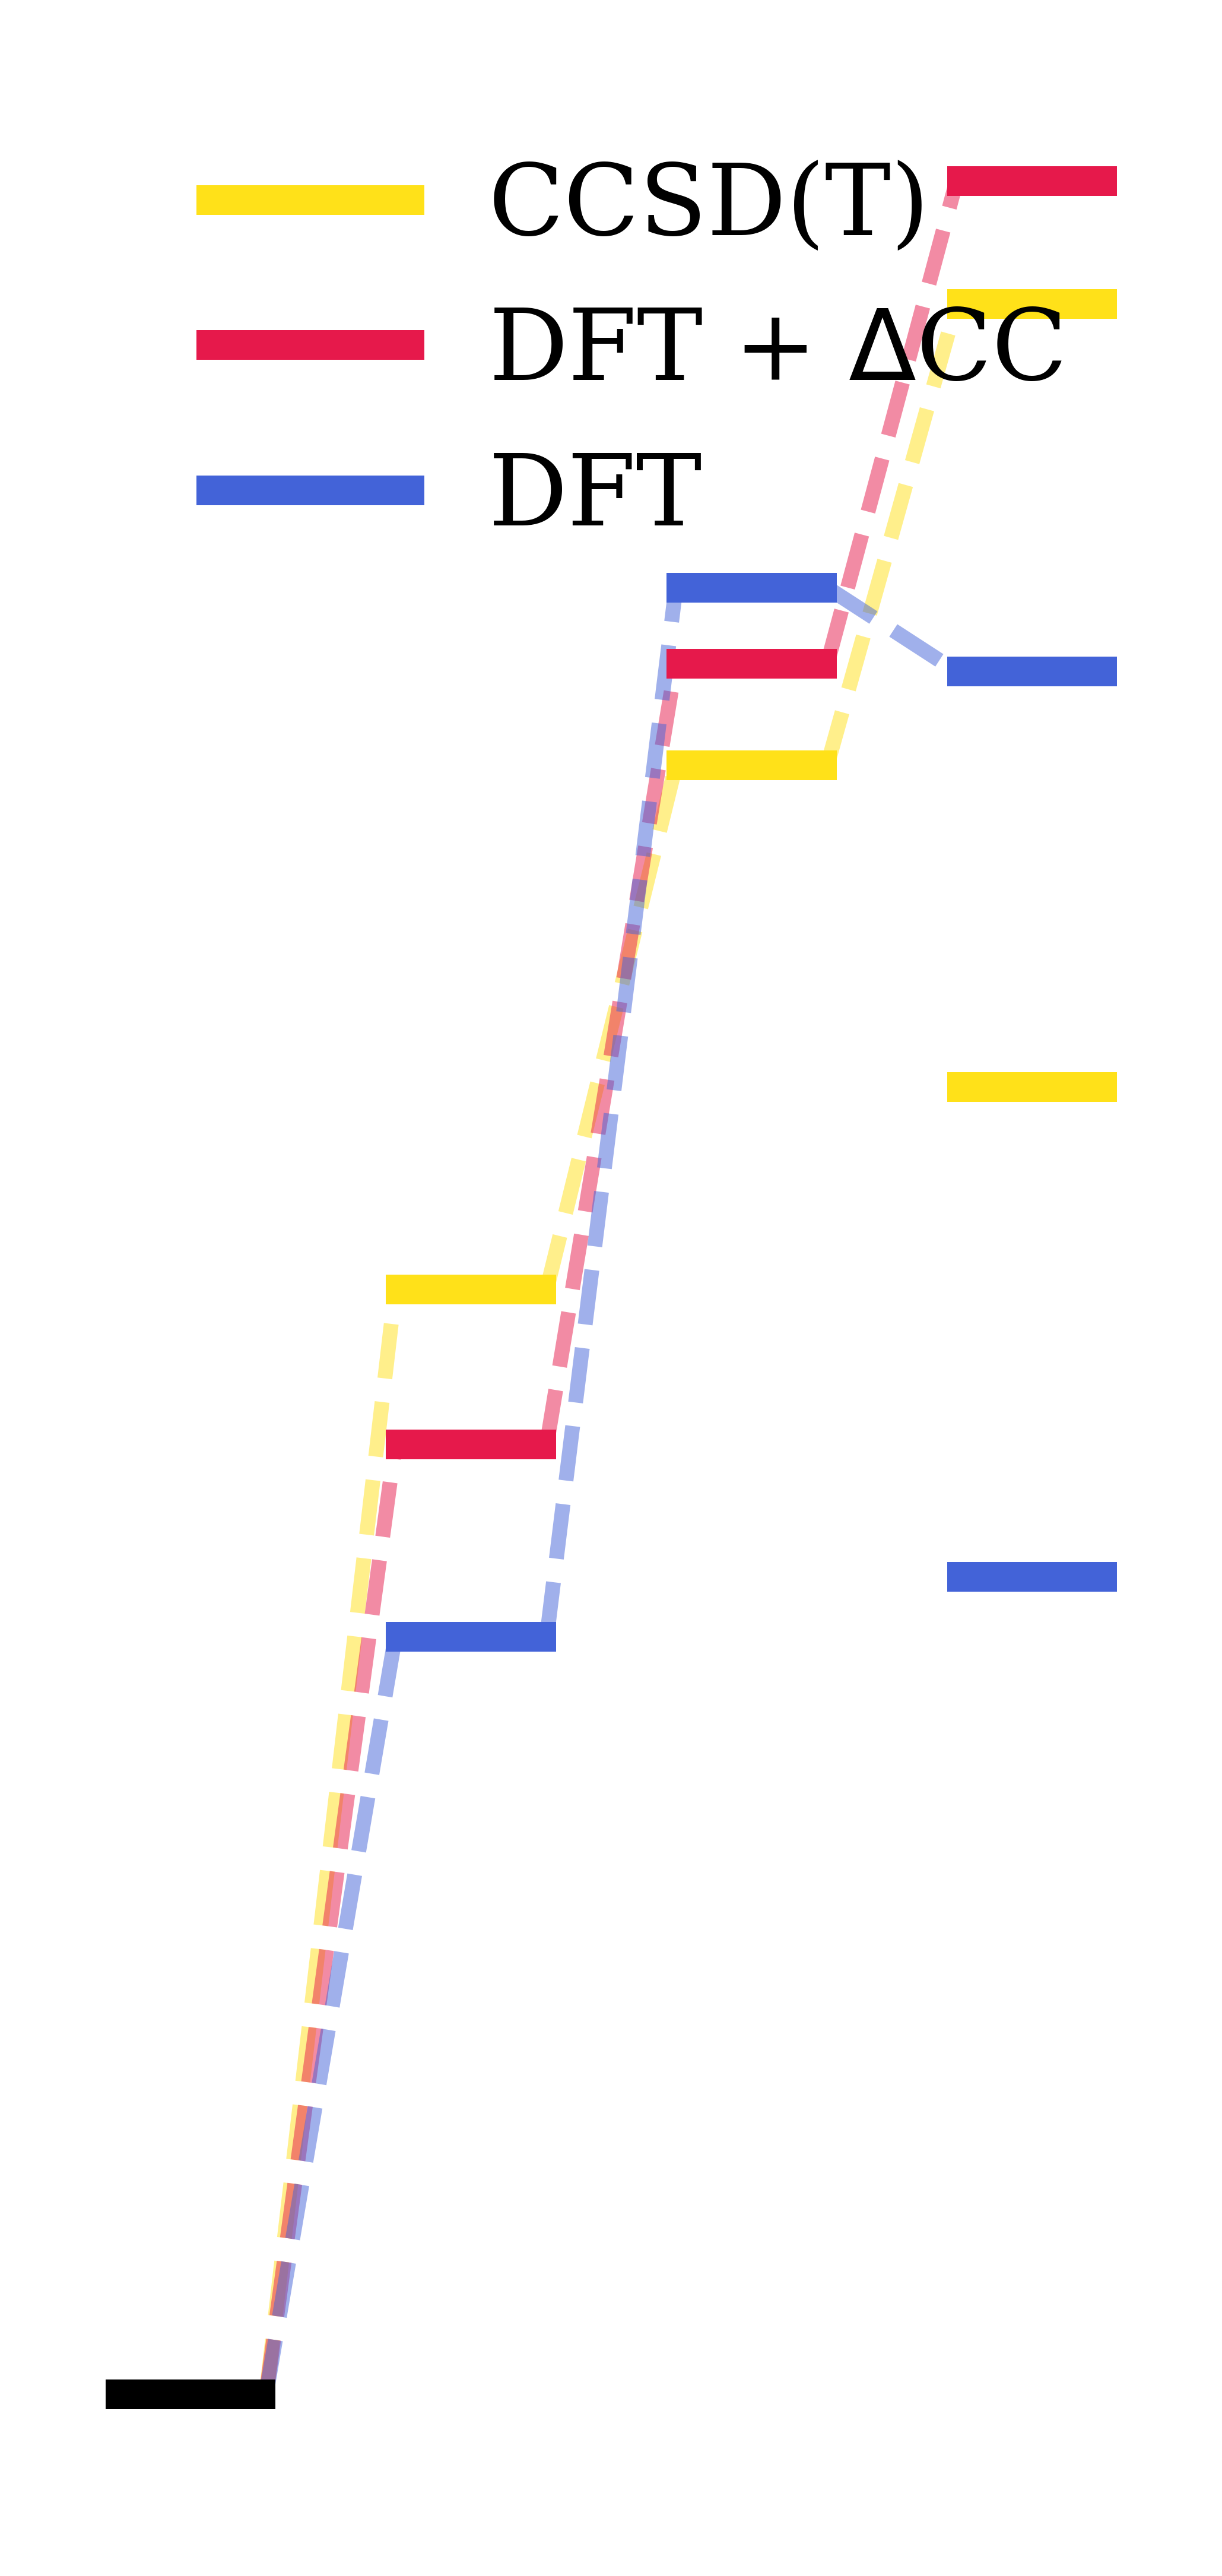

In [44]:
fig, axs = plt.subplots(figsize=(1.6,3.5),dpi=1200,constrained_layout=True)

functional_xc_test = 'PBE'

tetramer_start_x_pos = [1,3,5,7]

linelinewidth = 1.5
barbarwidth = 3

for i in range(4):
    if i < 3:
        width = 0.04
        # axs.plot([tetramer_start_x_pos[i]+1,tetramer_start_x_pos[i]+2],[ene_au_clus_cc[i], ene_au_clus_cc[i+1]],':',color=color_dict['orange'],alpha=0.5,linewidth=1)
        axs.plot([tetramer_start_x_pos[i]+1+width,tetramer_start_x_pos[i]+2 - width],[xc_rel_ene_list['Au']['CCSD(T)'][i], xc_rel_ene_list['Au']['CCSD(T)'][i+1]],'--',color=color_dict['yellow'],alpha=0.5,linewidth=linelinewidth)
        axs.plot([tetramer_start_x_pos[i]+1 + width,tetramer_start_x_pos[i]+2 - width],[xc_rel_ene_list['Au'][functional_xc_test + '+CC'][i], xc_rel_ene_list['Au'][functional_xc_test + '+CC'][i+1]],'--',color=color_dict['red'],alpha=0.5,linewidth=linelinewidth)
        # axs.plot([tetramer_start_x_pos[i]+1,tetramer_start_x_pos[i]+2],[ene_au_clus_dft[i], ene_au_clus_dft[i+1]],':',color=color_dict['blue'],alpha=0.5,linewidth=1)
        axs.plot([tetramer_start_x_pos[i]+1 + width,tetramer_start_x_pos[i]+2 - width],[xc_rel_ene_list['Au'][functional_xc_test][i], xc_rel_ene_list['Au'][functional_xc_test][i+1]],'--',color=color_dict['blue'],alpha=0.5,linewidth=linelinewidth)

    # axs[1].plot([])

    if i == 3:
        axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[ene_au_clus_cc[i], ene_au_clus_cc[i]],color=color_dict['yellow'],linewidth=barbarwidth)
        axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[ene_au_clus_dft[i], ene_au_clus_dft[i]],color=color_dict['blue'],linewidth=barbarwidth)
    if i == 0:
        axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[xc_rel_ene_list['Au']['CCSD(T)'][i], xc_rel_ene_list['Au']['CCSD(T)'][i]],color=color_dict['yellow'],linewidth=barbarwidth,label=r'CCSD(T)')
        axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[xc_rel_ene_list['Au'][functional_xc_test + '+CC'][i], xc_rel_ene_list['Au'][functional_xc_test + '+CC'][i]],color=color_dict['red'],linewidth=barbarwidth,label=r'DFT + $\Delta$CC')
        # axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[ene_au_clus_dft[i], ene_au_clus_dft[i]],color=color_dict['blue'],linewidth=2,label=r'Gas-phase PBE0-TSHI')

        # axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[ene_au_clus_cc[i], ene_au_clus_cc[i]],color=color_dict['yellow'],linewidth=2,label=r'Gas-phase LNO-CCSD(T)')
        axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[xc_rel_ene_list['Au'][functional_xc_test][i], xc_rel_ene_list['Au'][functional_xc_test][i]],color=color_dict['blue'],linewidth=barbarwidth,label=r'DFT')
    else:
        axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[xc_rel_ene_list['Au']['CCSD(T)'][i], xc_rel_ene_list['Au']['CCSD(T)'][i]],color=color_dict['yellow'],linewidth=barbarwidth)
        axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[xc_rel_ene_list['Au'][functional_xc_test + '+CC'][i], xc_rel_ene_list['Au'][functional_xc_test + '+CC'][i]],color=color_dict['red'],linewidth=barbarwidth)
        # axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[ene_au_clus_dft[i], ene_au_clus_dft[i]],color=color_dict['blue'],linewidth=2)

        # axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[ene_au_clus_cc[i], ene_au_clus_cc[i]],color=color_dict['yellow'],linewidth=2)
        axs.plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[xc_rel_ene_list['Au'][functional_xc_test][i], xc_rel_ene_list['Au'][functional_xc_test][i]],color=color_dict['blue'],linewidth=barbarwidth)

axs.plot([1,2],[0,0],color=color_dict['black'],linewidth=barbarwidth)

axs.legend(frameon=False)
axs.set_xticks([])
axs.set_yticks([])
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
# axs[1].set_ylim([-1500,2500])


plt.savefig('Figures/Fig_03.png')


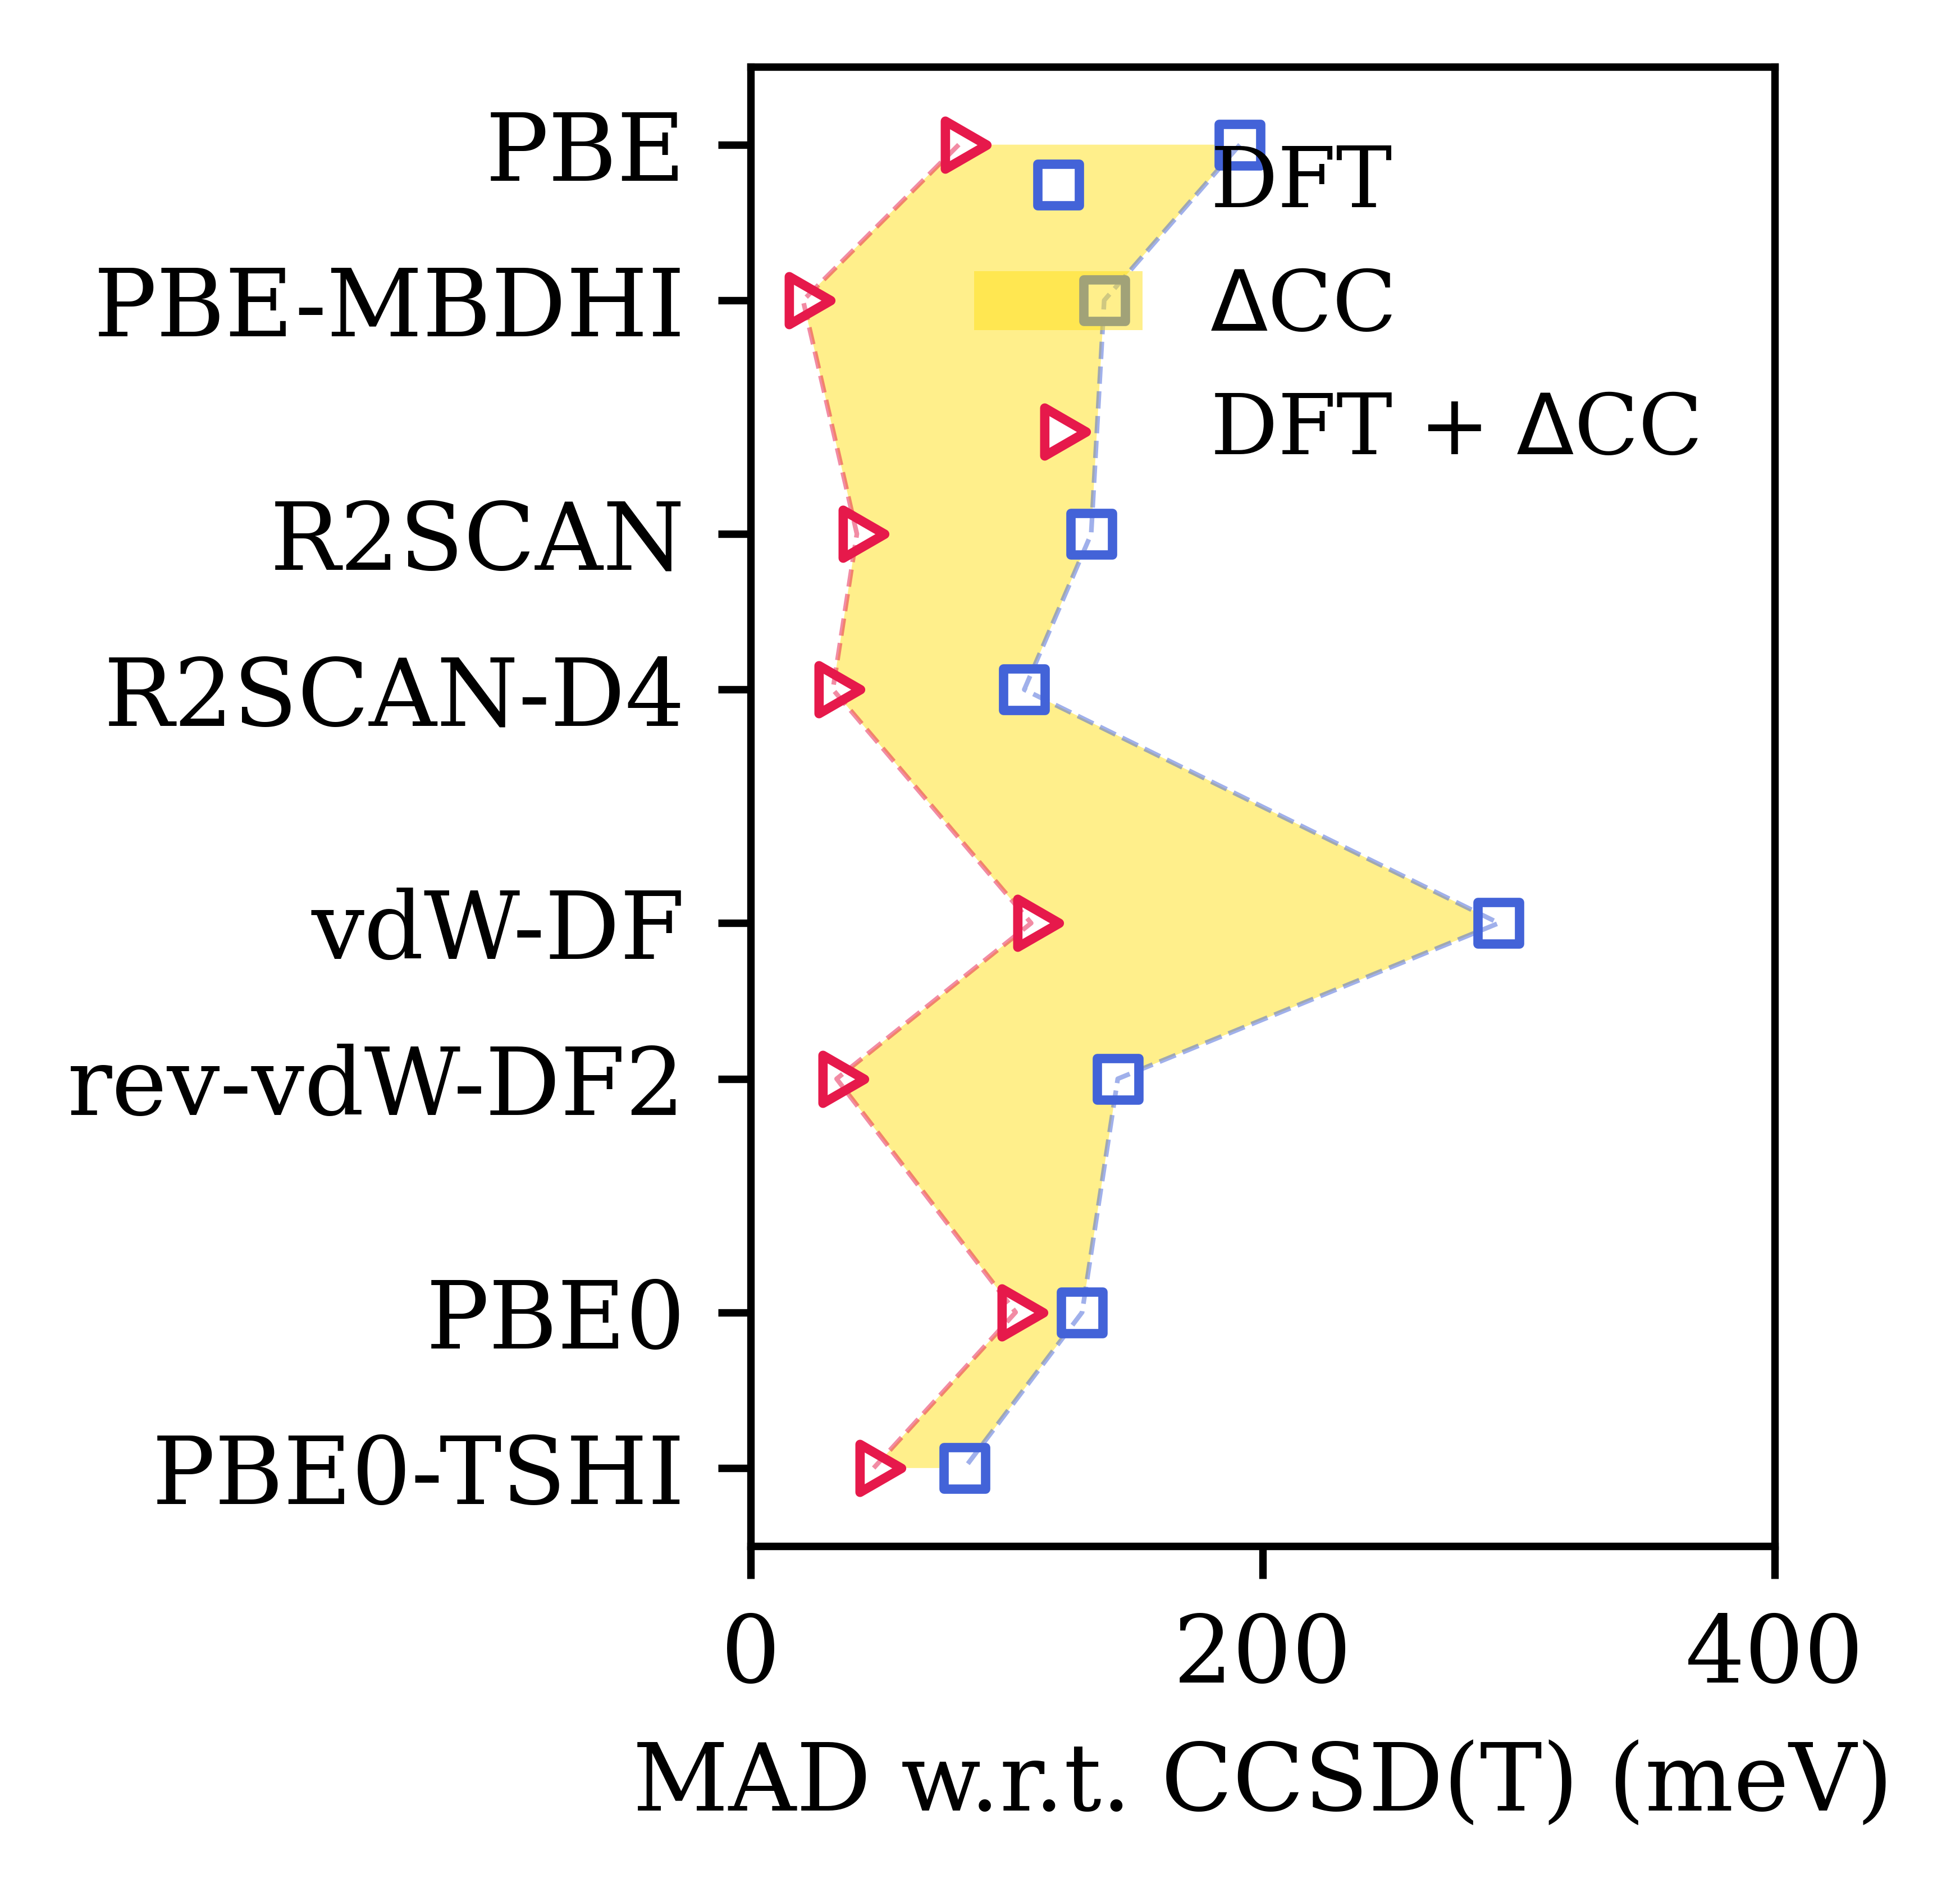

In [45]:
# fig, axs = plt.subplots(figsize=(3.375,3),dpi=1200,constrained_layout=True)


# funct_line = ['PBE','PBE-MBDHI','R2SCAN','R2SCAN-D4','vdW-DF','rev-vdW-DF2','PBE0','PBE0-TSHI']
# funct_line_y = [1,2,3.5,4.5,6,7,8.5,9.5]

# xc_tetramer_mad = []
# xc_cc_tetramer_mad = [] 

# for i in funct_line:
#     xc_tetramer_mad += [xc_rel_ene_mad['Au'][i]]
#     xc_cc_tetramer_mad += [xc_rel_ene_mad['Au'][i + '+CC']]

# axs.plot(xc_tetramer_mad,funct_line_y,'-', color=color_dict['blue'],label='DFT')
# axs.plot(xc_cc_tetramer_mad,funct_line_y,'-',color=color_dict['red'],label=r'DFT + $\Delta$CC')
# axs.fill_betweenx(funct_line_y,xc_tetramer_mad,xc_cc_tetramer_mad,color=color_dict['yellow'])

# axs.set_yticks(funct_line_y)
# axs.set_yticklabels(funct_line) #[0.5,3.5,6.5,9.5])
# # axs[0].set_xticklabels(['PBE','vdW-DF','R2SCAN','PBE0-TSHI'])
# axs.set_xlabel('MAD w.r.t. CCSD(T) (meV)')
# # axs.set_ylim([0,350])
# axs.legend()
# axs.set_ylim([10,0.5])
# axs.set_xlim([0,300])

# plt.savefig('Figures/Fig_03_2.png')

fig, axs = plt.subplots(figsize=(2.75,2.7),dpi=1200,constrained_layout=True)


funct_line = ['PBE','PBE-MBDHI','R2SCAN','R2SCAN-D4','vdW-DF','rev-vdW-DF2','PBE0','PBE0-TSHI']
funct_line_y = [1,2,3.5,4.5,6,7,8.5,9.5]

xc_tetramer_mad = []
xc_cc_tetramer_mad = [] 

for i in funct_line:
    xc_tetramer_mad += [xc_rel_ene_mad['Au'][i]]
    xc_cc_tetramer_mad += [xc_rel_ene_mad['Au'][i + '+CC']]


axs.fill_betweenx(funct_line_y,xc_tetramer_mad,xc_cc_tetramer_mad,color=color_dict['yellow'],alpha=0.5,edgecolor='none',label=r'$\Delta$CC')
axs.plot(xc_tetramer_mad,funct_line_y,'--', color=color_dict['blue'],linewidth=0.5,alpha=0.5)
axs.plot(xc_cc_tetramer_mad,funct_line_y,'--',color=color_dict['red'],linewidth=0.5,alpha=0.5)
axs.scatter(xc_tetramer_mad,funct_line_y,marker='s', s=20,color=color_dict['blue'],facecolor='white',label='DFT')
axs.scatter(xc_cc_tetramer_mad,funct_line_y,marker=(3,0,30),s=35,color=color_dict['red'],facecolor='white',label=r'DFT + $\Delta$CC')


axs.set_yticks(funct_line_y)
axs.set_yticklabels(funct_line) #[0.5,3.5,6.5,9.5])
# axs[0].set_xticklabels(['PBE','vdW-DF','R2SCAN','PBE0-TSHI'])
axs.set_xlabel('MAD w.r.t. CCSD(T) (meV)')
# axs.set_ylim([0,350])
axs.legend()
axs.set_ylim([10,0.5])
axs.set_xlim([0,400])

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0,2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],frameon=False,fontsize=9)




plt.savefig('Figures/Fig_03_2_2.png')

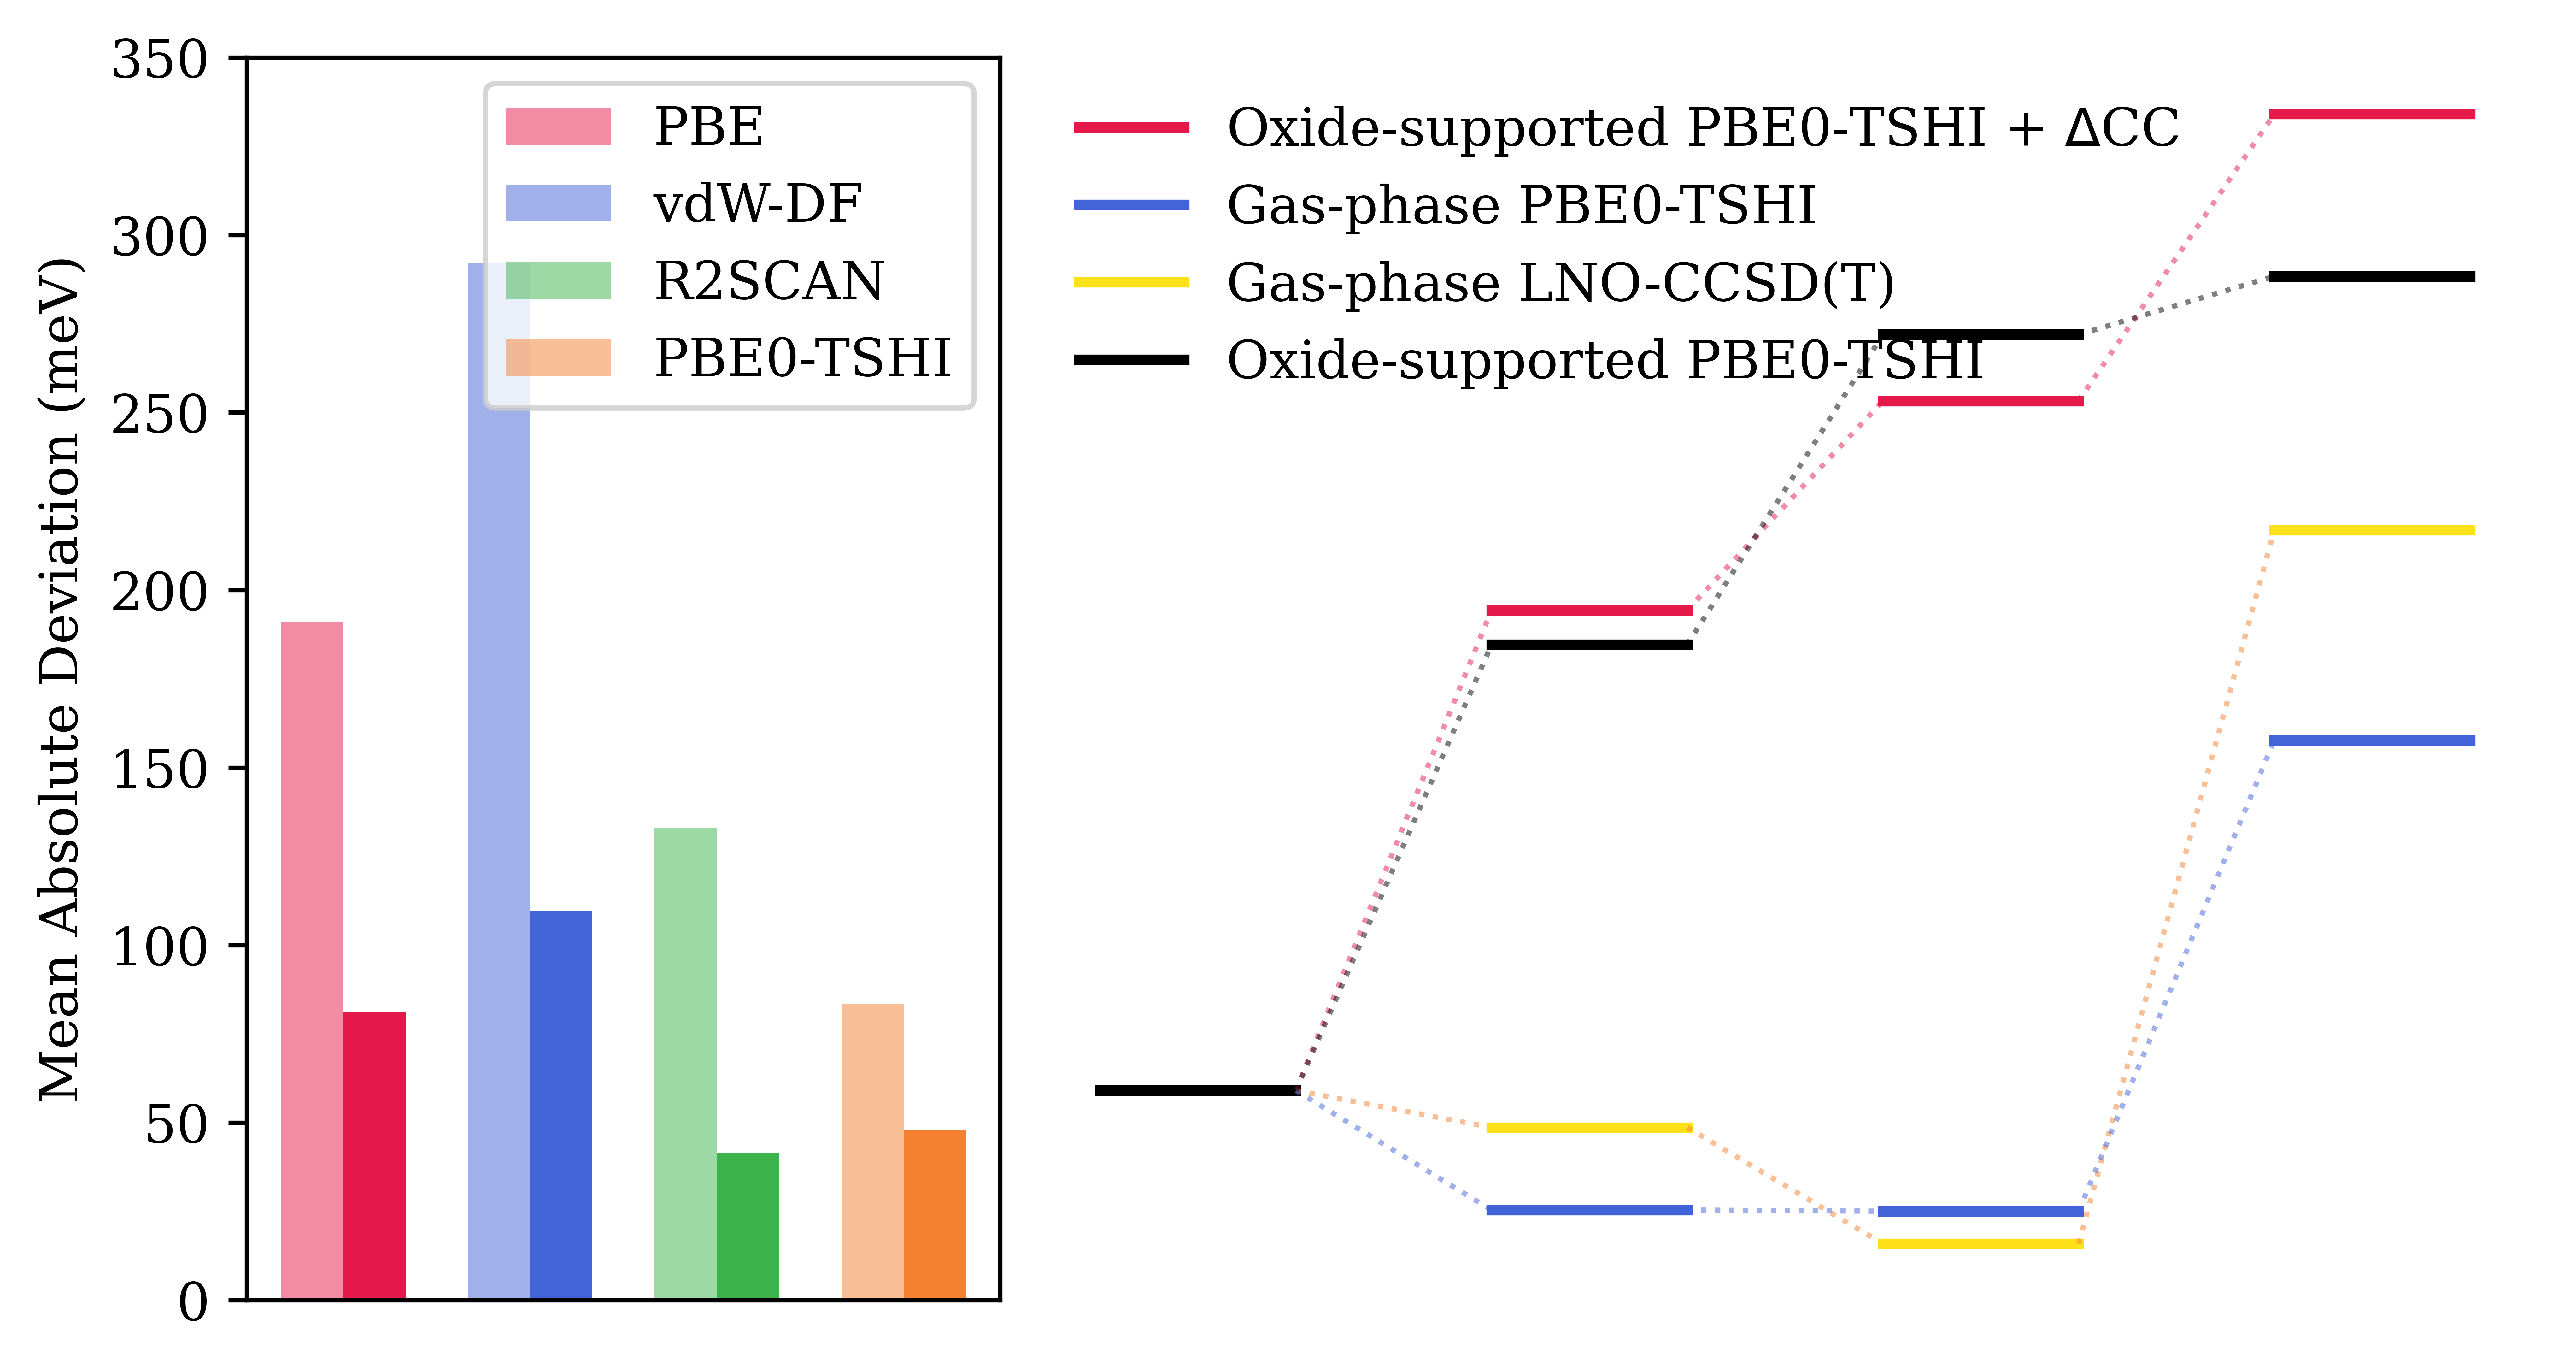

In [46]:
fig, axs = plt.subplots(1,2,figsize=(6.69,3.5),dpi=1200,gridspec_kw={'width_ratios':[1,2]},constrained_layout=True)



axs[0].bar(0,xc_rel_ene_mad['Au']['PBE'],width=1,color=color_dict['red'],alpha=0.5,label='PBE')
axs[0].bar(1,xc_rel_ene_mad['Au']['PBE+CC'],width=1,color=color_dict['red'])

axs[0].bar(3,xc_rel_ene_mad['Au']['vdW-DF'],width=1,color=color_dict['blue'],alpha=0.5,label='vdW-DF')
axs[0].bar(4,xc_rel_ene_mad['Au']['vdW-DF+CC'],width=1,color=color_dict['blue'])

axs[0].bar(6,xc_rel_ene_mad['Au']['R2SCAN'],width=1,color=color_dict['green'],alpha=0.5,label='R2SCAN')
axs[0].bar(7,xc_rel_ene_mad['Au']['R2SCAN+CC'],width=1,color=color_dict['green'])

axs[0].bar(9,xc_rel_ene_mad['Au']['PBE0-TSHI'],width=1,color=color_dict['orange'],alpha=0.5,label='PBE0-TSHI')
axs[0].bar(10,xc_rel_ene_mad['Au']['PBE0-TSHI+CC'],width=1,color=color_dict['orange'])


tetramer_start_x_pos = [1,3,5,7]

for i in range(4):
    # axs[1].plot([])
    if i == 0:
        axs[1].plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[xc_rel_ene_list['Au']['PBE0-TSHI+CC'][i], xc_rel_ene_list['Au']['PBE0-TSHI+CC'][i]],color=color_dict['red'],linewidth=2,label=r'Oxide-supported PBE0-TSHI + $\Delta$CC')
        axs[1].plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[ene_au_clus_dft[i], ene_au_clus_dft[i]],color=color_dict['blue'],linewidth=2,label=r'Gas-phase PBE0-TSHI')

        axs[1].plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[ene_au_clus_cc[i], ene_au_clus_cc[i]],color=color_dict['yellow'],linewidth=2,label=r'Gas-phase LNO-CCSD(T)')
        axs[1].plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[xc_rel_ene_list['Au']['PBE0-TSHI'][i], xc_rel_ene_list['Au']['PBE0-TSHI'][i]],color=color_dict['black'],linewidth=2,label=r'Oxide-supported PBE0-TSHI')
    else:

        axs[1].plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[xc_rel_ene_list['Au']['PBE0-TSHI+CC'][i], xc_rel_ene_list['Au']['PBE0-TSHI+CC'][i]],color=color_dict['red'],linewidth=2)
        axs[1].plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[ene_au_clus_dft[i], ene_au_clus_dft[i]],color=color_dict['blue'],linewidth=2)

        axs[1].plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[ene_au_clus_cc[i], ene_au_clus_cc[i]],color=color_dict['yellow'],linewidth=2)
        axs[1].plot([tetramer_start_x_pos[i],tetramer_start_x_pos[i]+1],[xc_rel_ene_list['Au']['PBE0-TSHI'][i], xc_rel_ene_list['Au']['PBE0-TSHI'][i]],color=color_dict['black'],linewidth=2)
    if i < 3:
        axs[1].plot([tetramer_start_x_pos[i]+1,tetramer_start_x_pos[i]+2],[ene_au_clus_cc[i], ene_au_clus_cc[i+1]],':',color=color_dict['orange'],alpha=0.5,linewidth=1)
        axs[1].plot([tetramer_start_x_pos[i]+1,tetramer_start_x_pos[i]+2],[xc_rel_ene_list['Au']['PBE0-TSHI+CC'][i], xc_rel_ene_list['Au']['PBE0-TSHI+CC'][i+1]],':',color=color_dict['red'],alpha=0.5,linewidth=1)
        axs[1].plot([tetramer_start_x_pos[i]+1,tetramer_start_x_pos[i]+2],[ene_au_clus_dft[i], ene_au_clus_dft[i+1]],':',color=color_dict['blue'],alpha=0.5,linewidth=1)
        axs[1].plot([tetramer_start_x_pos[i]+1,tetramer_start_x_pos[i]+2],[xc_rel_ene_list['Au']['PBE0-TSHI'][i], xc_rel_ene_list['Au']['PBE0-TSHI'][i+1]],':',color=color_dict['black'],alpha=0.5,linewidth=1)


axs[1].legend(frameon=False)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].spines['left'].set_visible(False)
# axs[1].set_ylim([-1500,2500])

axs[0].set_xticks([]) #[0.5,3.5,6.5,9.5])
# axs[0].set_xticklabels(['PBE','vdW-DF','R2SCAN','PBE0-TSHI'])
axs[0].set_ylabel('Mean Absolute Deviation (meV)')
axs[0].set_ylim([0,350])
axs[0].legend()

plt.savefig('Figures/M4_MgO_Rel_Ene.png')


In [47]:
xc_rel_ene_mad

{'Au': {'PBE': 191.06407706360358,
  'PBE-D2': 193.40230730556925,
  'PBE-D2-Ne': 193.40230730556925,
  'PBE-DDSC': 178.16508459637396,
  'PBE-D3': 179.75538792953364,
  'PBE-TS': 215.63227459628968,
  'PBE-TSHI': 141.31067039698357,
  'PBE-D4': 163.03302126303413,
  'PBE-MBDHI': 138.0514870635475,
  'PBE-MBDFI': 211.06740126302418,
  'revPBE': 258.59724706361266,
  'revPBE-D3': 281.09701126291645,
  'revPBE-D4': 242.59198792954024,
  'PBEsol': 89.18553706361176,
  'PBEsol-D3': 65.52047397229273,
  'PBEsol-D4': 46.971940396941626,
  'vdW-DF': 292.19391126290054,
  'vdW-DF2': 375.88512459622007,
  'optB86b-vdW': 141.12983459622944,
  'rev-vdW-DF2': 143.34955792953636,
  'R2SCAN': 132.96652706357102,
  'R2SCAN-D3': 92.3206637302324,
  'R2SCAN-D4': 106.82794373024554,
  'SCAN-rVV10': 129.17605269435873,
  'PBE0': 129.42346706363898,
  'PBE0-D3': 103.62605397230918,
  'PBE0-D4': 74.66800459624926,
  'PBE0-TSHI': 83.52135039700006,
  'HSE06': 135.25812039693412,
  'HSE06-D4': 75.99693792947

In [48]:

for i in ['Au']:
    for j in [8]:           
        for l in [1,2,3,4]:
        
            # if (j == 3 and i == 'Ag') or (j == 3 and i == 'Cu'):
            #     continue
            
            ene_hf = []
            ene_ccsdt = []

            for m in [1,3,2]:
                root_folder = 'Data/01-Gas_Cluster/cWFT/LCCSDT_From_PBE/{0}{1}/{2}/{3}/mrcc.out'.format(i,j,l,m)
                root_folder_b2plyp = 'Data/01-Gas_Cluster/cWFT/B2PLYP/{0}{1}/{2}/{3}/mrcc.out'.format(i,j,l,m)

                ene_hf += [find_energy(root_folder,code_format='mrcc',typ='hf')]
                ene_ccsdt += [find_energy(root_folder,code_format='mrcc',typ='lccsdt')]
            if l == 1:
                dummy0 = np.array(ene_hf) + np.array(ene_ccsdt)
            print((np.array(ene_hf) + np.array(ene_ccsdt) - dummy0)*Hartree*1000)


[0. 0. 0.]
[-17.43977483 -58.44029364 144.88314716]
[287.91853615 249.73064344 293.0212022 ]
[ -6.54160544 -51.98238299 197.87474079]


In [49]:
xc_rel_ene_list

{'Au': {'PBE': [0.0,
   486.7349700000432,
   1160.8814200001234,
   1107.1049399999993],
  'PBE-D2': [0.0, 768.9688200000546, 693.7822700001561, 1174.8827400001574],
  'PBE-D2-Ne': [0.0, 768.9688200000546, 693.7822700001561, 1174.8827400001574],
  'PBE-DDSC': [0.0, 582.5388999999177, 953.6318399998436, 1029.176939999843],
  'PBE-D3': [0.0, 626.2172500000815, 919.0310799999679, 1015.3284400000757],
  'PBE-TS': [0.0, 659.1272999999092, 958.4179700000277, 835.4008399999202],
  'PBE-TSHI': [0.0, 593.3748099998866, 1092.7974999999606, 1081.641399999853],
  'PBE-D4': [0.0, 591.5500899998278, 960.8705999999074, 1058.3231799998885],
  'PBE-MBDHI': [0.0, 572.0272200001091, 1070.9409700000379, 1090.910010000016],
  'PBE-MBDFI': [0.0, 612.3963799998364, 823.03912999987, 1031.205219999947],
  'revPBE': [0.0, 400.44956999986425, 1218.852409999954, 1048.7618199999815],
  'revPBE-D3': [0.0, 658.4569399999509, 733.2221300000583, 864.8728299999675],
  'revPBE-D4': [0.0, 560.9632499999861, 851.38933000

In [50]:
xc_functional_list = ['PBE','PBE-D2','PBE-D2-Ne','PBE-DDSC','PBE-D3','PBE-TS','PBE-TSHI','PBE-D4','PBE-MBDHI','PBE-MBDFI','revPBE','revPBE-D3','revPBE-D4','PBEsol','PBEsol-D3','PBEsol-D4','vdW-DF','vdW-DF2','optB86b-vdW','rev-vdW-DF2','R2SCAN','R2SCAN-D3','R2SCAN-D4','SCAN-rVV10','PBE0','PBE0-D3','PBE0-D4','PBE0-TSHI','HSE06','HSE06-D4','B3LYP','B3LYP-D2','B3LYP-D2-Ne','B3LYP-D3','B3LYP-D4']

full_methods_list = xc_functional_list + ['B2PLYP','HF','MP2','CCSD','CCSD(T)']

xc_rel_ene_list = { x: { y: {z : [] for z in full_methods_list} for y in [4,6,8]}  for x in ['Au','Ag','Cu']}
xc_bind_ene_list = { x: { y: {z : [] for z in full_methods_list} for y in [4,6,8]}  for x in ['Au','Ag','Cu']}

xc_rel_ene_mad = { x: { y: {z : [] for z in full_methods_list} for y in [4,6,8,'Total']}  for x in ['Au','Ag','Cu','Total']}
xc_bind_ene_mad = { x: { y: {z : [] for z in full_methods_list} for y in [4,6,8]}  for x in ['Au','Ag','Cu']}


for i in ['Au','Ag','Cu']:
    for j in [4,6,8]:
        for k in xc_functional_list:
            if k == 'optB86b-vdW':
                func_name = 'optB86b-vdw'
            elif k == 'rev-vdW-DF2':
                func_name = 'rev-vdw-DF2'
            elif k == 'PBE-D2-Ne':
                func_name = 'PBE-D2'.lower()
            elif k == 'B3LYP-D2-Ne':
                func_name = 'B3LYP-D2'.lower()
    
            else:
                func_name = k.lower()
            
            ene_0 = find_energy('Data/01-Gas_Cluster/DFT/{0}{1}/1/{2}/AD/OUTCAR'.format(i,j,func_name),code_format='vasp')
            for l in [1,2,3,4]:
                ene_ad= find_energy('Data/01-Gas_Cluster/DFT/{0}{1}/{3}/{2}/AD/OUTCAR'.format(i,j,func_name,l),code_format='vasp')

                xc_rel_ene_list[i][j][k] += [(ene_ad - ene_0)*1000]
                xc_bind_ene_list[i][j][k] += [(ene_ad)*1000]
            
        for l in [1,2,3,4]:
        
            # if (j == 3 and i == 'Ag') or (j == 3 and i == 'Cu'):
            #     continue
            
            ene_hf = []
            ene_mp2 = []
            ene_ccsd = []
            ene_ccsdt = []
            ene_dft = []
            ene_b2plyp = [] 
            for m in [1,3,2]:
                root_folder = 'Data/01-Gas_Cluster/cWFT/LCCSDT_From_PBE/{0}{1}/{2}/{3}/mrcc.out'.format(i,j,l,m)
                root_folder_b2plyp = 'Data/01-Gas_Cluster/cWFT/B2PLYP/{0}{1}/{2}/{3}/mrcc.out'.format(i,j,l,m)

                ene_hf += [find_energy(root_folder,code_format='mrcc',typ='hf')]
                ene_mp2 += [find_energy(root_folder,code_format='mrcc',typ='lmp2')]
                ene_ccsd += [find_energy(root_folder,code_format='mrcc',typ='lccsd')]
                ene_ccsdt += [find_energy(root_folder,code_format='mrcc',typ='lccsdt')]
                ene_dft += [find_energy(root_folder_b2plyp,code_format='mrcc',typ='hf')]
                ene_b2plyp += [find_energy(root_folder_b2plyp,code_format='mrcc',typ='B2PLYP')]


            dummy_dict ={
                'MP2': extrapolate.get_cbs(ene_hf[0],ene_mp2[0],ene_hf[1],ene_mp2[1],X=3,Y=4,family='acc',\
                convert_Hartree=False ,shift=0.0,output=False),
                'CCSD': extrapolate.get_cbs(ene_hf[0],ene_ccsd[0],ene_hf[1],ene_ccsd[1],X=3,Y=4,family='acc',\
                convert_Hartree=False ,shift=0.0,output=False),
                'CCSD(T)': extrapolate.get_cbs(ene_hf[0],ene_ccsdt[0],ene_hf[1],ene_ccsdt[1],X=3,Y=4,family='acc',\
                convert_Hartree=False ,shift=0.0,output=False),
                'B2PLYP': extrapolate.get_cbs(ene_dft[0],ene_b2plyp[0],ene_dft[1],ene_b2plyp[1],X=3,Y=4,family='acc',\
                convert_Hartree=False ,shift=0.0,output=False)
            }
            # dummy_mp2 = extrapolate.get_cbs(ene_hf[0],ene_mp2[0],ene_hf[1],ene_mp2[1],X=3,Y=4,family='acc',\
            #     convert_Hartree=False ,shift=0.0,output=False)
            # dummy_ccsd = extrapolate.get_cbs(ene_hf[0],ene_ccsd[0],ene_hf[1],ene_ccsd[1],X=3,Y=4,family='acc',\
            #     convert_Hartree=False ,shift=0.0,output=False)
            # dummy_ccsdt = extrapolate.get_cbs(ene_hf[0],ene_ccsdt[0],ene_hf[1],ene_ccsdt[1],X=3,Y=4,family='acc',\
            #     convert_Hartree=False ,shift=0.0,output=False)
            # dummy_b2plyp = extrapolate.get_cbs(ene_dft[0],ene_b2plyp[0],ene_dft[1],ene_b2plyp[1],X=3,Y=4,family='acc',\
            #     convert_Hartree=False ,shift=0.0,output=False)



            xc_bind_ene_list[i][j]['HF'] += [dummy_dict['MP2'][0]]
            xc_bind_ene_list[i][j]['MP2'] += [dummy_dict['MP2'][-1] + ene_mp2[-1] - ene_mp2[0]]
            xc_bind_ene_list[i][j]['CCSD'] += [dummy_dict['CCSD'][-1] + ene_ccsd[-1] - ene_ccsd[0]]
            xc_bind_ene_list[i][j]['CCSD(T)'] += [dummy_dict['CCSD(T)'][-1] + ene_ccsdt[-1] - ene_ccsdt[0]]
            xc_bind_ene_list[i][j]['B2PLYP'] += [dummy_dict['B2PLYP'][-1] + ene_b2plyp[-1] - ene_b2plyp[0]]

            # xc_rel_ene_list[i][j]['HF'] += [(dummy_dict['MP2'][0] - xc_bind_ene_list[i][j]['HF'][0])*1000]

            for m in ['HF','MP2','CCSD','CCSD(T)','B2PLYP']:
                xc_rel_ene_list[i][j][m] += [(xc_bind_ene_list[i][j][m][-1]- xc_bind_ene_list[i][j][m][0])*1000*Hartree]



In [51]:
for j in xc_functional_list + ['B2PLYP','HF','MP2','CCSD']:
    for i in ['Au','Ag','Cu']:
        for k in [4,6,8]:
            xc_rel_ene_mad[i][k][j] = np.sum([abs(xc_rel_ene_list[i][k][j][l] - xc_rel_ene_list[i][k]['CCSD(T)'][l]) for l in list(range(1,4))])/3
        xc_rel_ene_mad[i]['Total'][j] = np.sum([xc_rel_ene_mad[i][l][j] for l in [4,6,8]])/3
        xc_rel_ene_mad['Total'][4][j] = np.sum([xc_rel_ene_mad[l][4][j] for l in ['Au','Ag','Cu']])/3
        xc_rel_ene_mad['Total'][6][j] = np.sum([xc_rel_ene_mad[l][6][j] for l in ['Au','Ag','Cu']])/3
        xc_rel_ene_mad['Total'][8][j] = np.sum([xc_rel_ene_mad[l][8][j] for l in ['Au','Ag','Cu']])/3

    # print(np.sum([xc_rel_ene_mad[l]['Total'][j] for l in ['Au','Ag','Cu']])/3,np.sum([xc_rel_ene_mad['Total'][l][j] for l in [4,6,8]])/3)

    xc_rel_ene_mad['Total']['Total'][j] = np.sum([xc_rel_ene_mad[l]['Total'][j] for l in ['Au','Ag','Cu']])/3
    # m2_mgo_xc_bind_ene_mad['Total'][j] = (m2_mgo_xc_bind_ene_mad['Au'][j] + m2_mgo_xc_bind_ene_mad['Ag'][j] + m2_mgo_xc_bind_ene_mad['Cu'][j])/3

/home/shixubenjamin/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [52]:
xc_rel_ene_mad['Total']['Total']

{'PBE': 199.43398666323392,
 'PBE-D2': 152.60638467597502,
 'PBE-D2-Ne': 152.60638467597502,
 'PBE-DDSC': 142.8988798130196,
 'PBE-D3': 129.56217055376024,
 'PBE-TS': 189.92743629286306,
 'PBE-TSHI': 190.6739798225913,
 'PBE-D4': 120.14120630571028,
 'PBE-MBDHI': 123.35296408348857,
 'PBE-MBDFI': 111.02067037978479,
 'revPBE': 312.723706861233,
 'revPBE-D3': 155.31159468818427,
 'revPBE-D4': 146.25141915575836,
 'PBEsol': 89.44712345398818,
 'PBEsol-D3': 89.98219685352588,
 'PBEsol-D4': 88.86049981648841,
 'vdW-DF': 359.24416908345546,
 'vdW-DF2': 451.92321332990036,
 'optB86b-vdW': 103.35732420609799,
 'rev-vdW-DF2': 138.53399737573778,
 'R2SCAN': 126.3996846217335,
 'R2SCAN-D3': 119.14804091803369,
 'R2SCAN-D4': 121.22378573285239,
 'SCAN-rVV10': 137.73896955577598,
 'PBE0': 190.5027425730198,
 'PBE0-D3': 117.57896886931591,
 'PBE0-D4': 122.46989849894567,
 'PBE0-TSHI': 182.7515133137601,
 'HSE06': 190.60895295953006,
 'HSE06-D4': 123.80139925582618,
 'B3LYP': 406.0457122187895,
 'B3

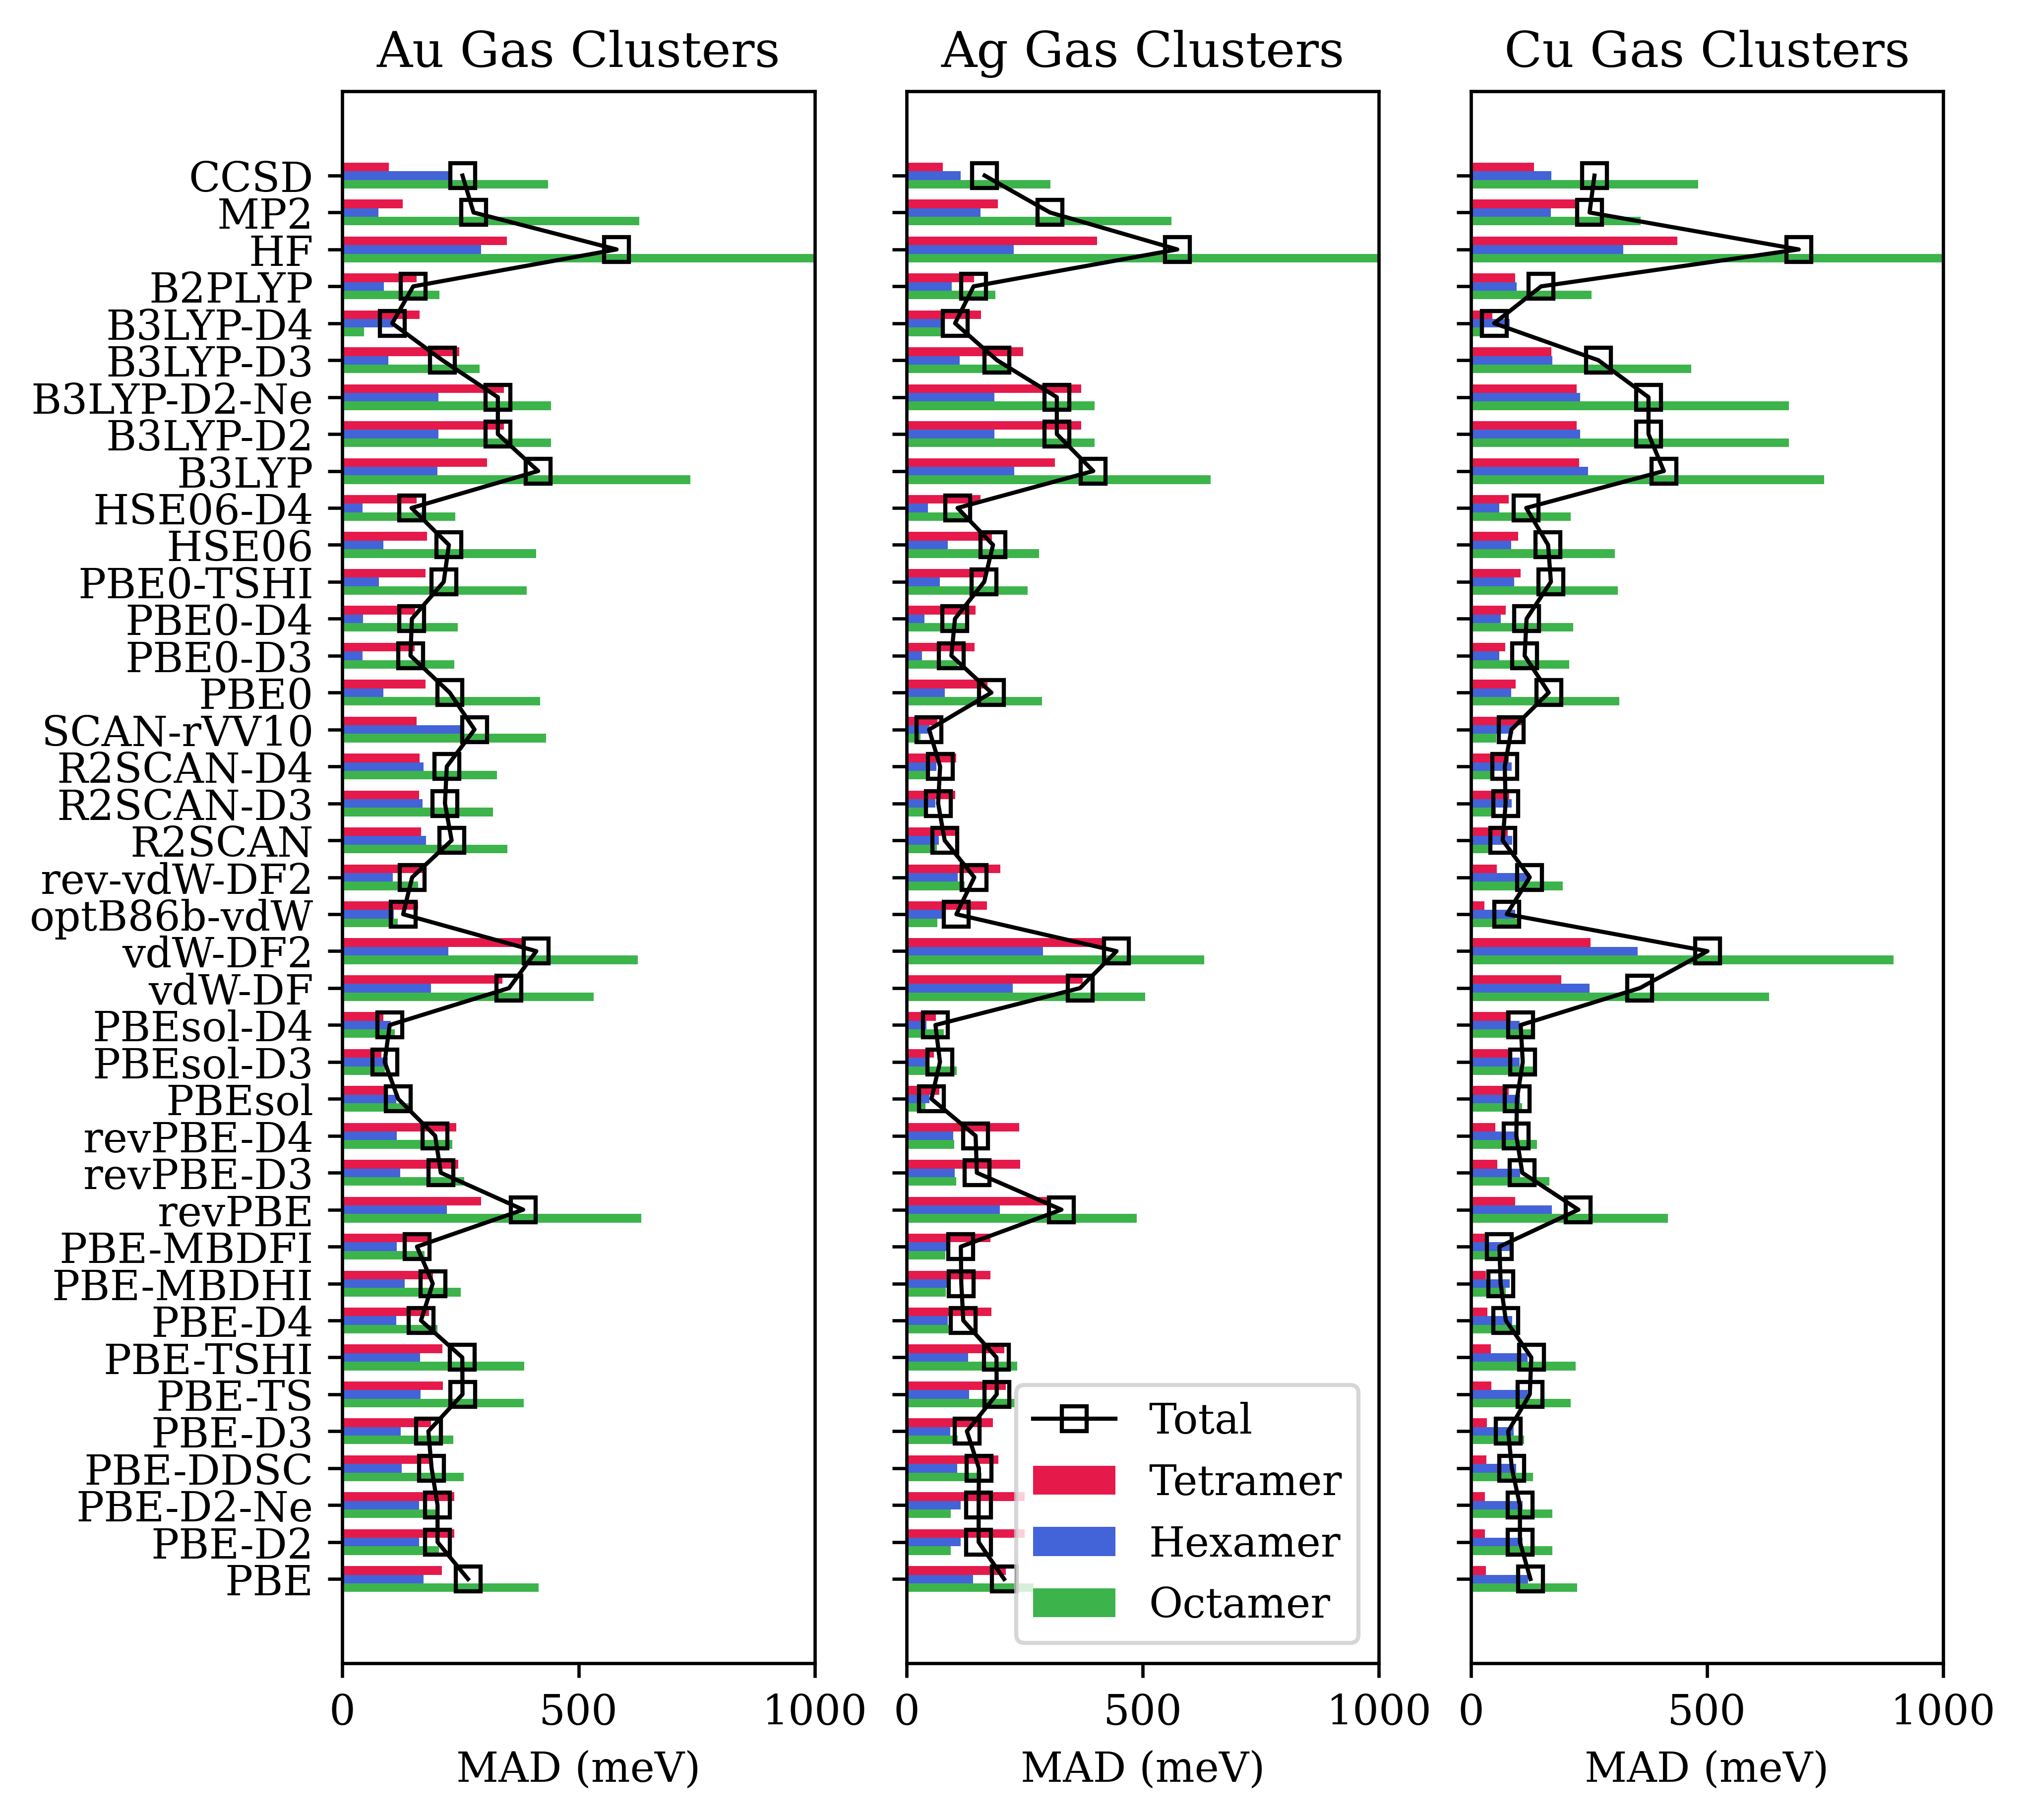

In [53]:
fig, axs = plt.subplots(1,3,figsize=(6.69,6),dpi=600, sharey=True,sharex=True,constrained_layout=True)


eov_method_sorted_list = xc_functional_list + ['B2PLYP','HF','MP2','CCSD']

# axs.
eov_method_sorted_list_val = np.array(list(range(len(eov_method_sorted_list))))

width=0.35

counter = 0
for i in ['Au','Ag','Cu']:


    axs[counter].barh(np.array(list(range(len(eov_method_sorted_list))))*1.5+width, [ (xc_rel_ene_mad[i][4][x]) for x in eov_method_sorted_list],width,label=r'Tetramer',color=color_dict['red'])
    axs[counter].barh(np.array(list(range(len(eov_method_sorted_list))))*1.5, [ (xc_rel_ene_mad[i][6][x]) for x in eov_method_sorted_list],width,label=r'Hexamer',color=color_dict['blue'])
    axs[counter].barh(np.array(list(range(len(eov_method_sorted_list))))*1.5 -width, [ (xc_rel_ene_mad[i][8][x]) for x in eov_method_sorted_list],width,label=r'Octamer',color=color_dict['green'])

    axs[counter].plot([ (xc_rel_ene_mad[i]['Total'][x]) for x in eov_method_sorted_list],np.array(list(range(len(eov_method_sorted_list))))*1.5, marker='s',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['black'], linewidth=1,label='Total')

    axs[counter].set_xlabel('MAD (meV)')

    axs[counter].set_title('{0} Gas Clusters'.format(i))

    counter += 1

# axs[1].barh(np.array(list(range(len(eov_method_sorted_list))))*1.5-width, [ (m2_bind_ene_mad['Au'][x]) for x in eov_method_sorted_list],width,label=r'Au',color=color_dict['orange'])
# axs[1].barh(np.array(list(range(len(eov_method_sorted_list))))*1.5, [ (m2_bind_ene_mad['Ag'][x]) for x in eov_method_sorted_list],width,label=r'Ag',color=color_dict['grey'])
# axs[1].barh(np.array(list(range(len(eov_method_sorted_list))))*1.5 +width, [ (m2_bind_ene_mad['Cu'][x]) for x in eov_method_sorted_list],width,label=r'Cu',color=color_dict['brown'])

# axs[1].plot(m2_tot_bind_ene_mad,np.array(list(range(len(eov_method_sorted_list))))*1.5, marker='s',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['black'], linewidth=1,label='Total')

# axs[0].barh(eov_method_sorted_list, [ (m4_rel_ene_mad['Ag'][x]) for x in eov_method_sorted_list],0.35,label=r'Ag')
# axs[0].barh(eov_method_sorted_list, [ (m4_rel_ene_mad['Cu'][x]) for x in eov_method_sorted_list],0.35,label=r'Cu')

# # axs[0].barh(eov_method_sorted_list, m4_tot_rel_ene_mad, 0.35,label=r'Error in $E_\textrm{int}^\textrm{M-M}$')
# axs[0].plot([0.02,0.04,0.06],[0,1,2])

# axs.bar(eov_method_sorted_list, m2_tot_bind_ene_mad, 0.35, bottom=m4_tot_rel_ene_mad,label=r'Error in $E_\textrm{int}^\textrm{M-S}$')
axs[1].legend()


axs[0].set_yticks(np.array(list(range(len(eov_method_sorted_list))))*1.5)
axs[0].set_yticklabels(eov_method_sorted_list)
axs[0].set_xlim([0,1000])

# plt.xticks(rotation=90)

plt.savefig('Figures/Gas_MAD_Size.png')

# plt.savefig('Figures/Combined_graph.png')


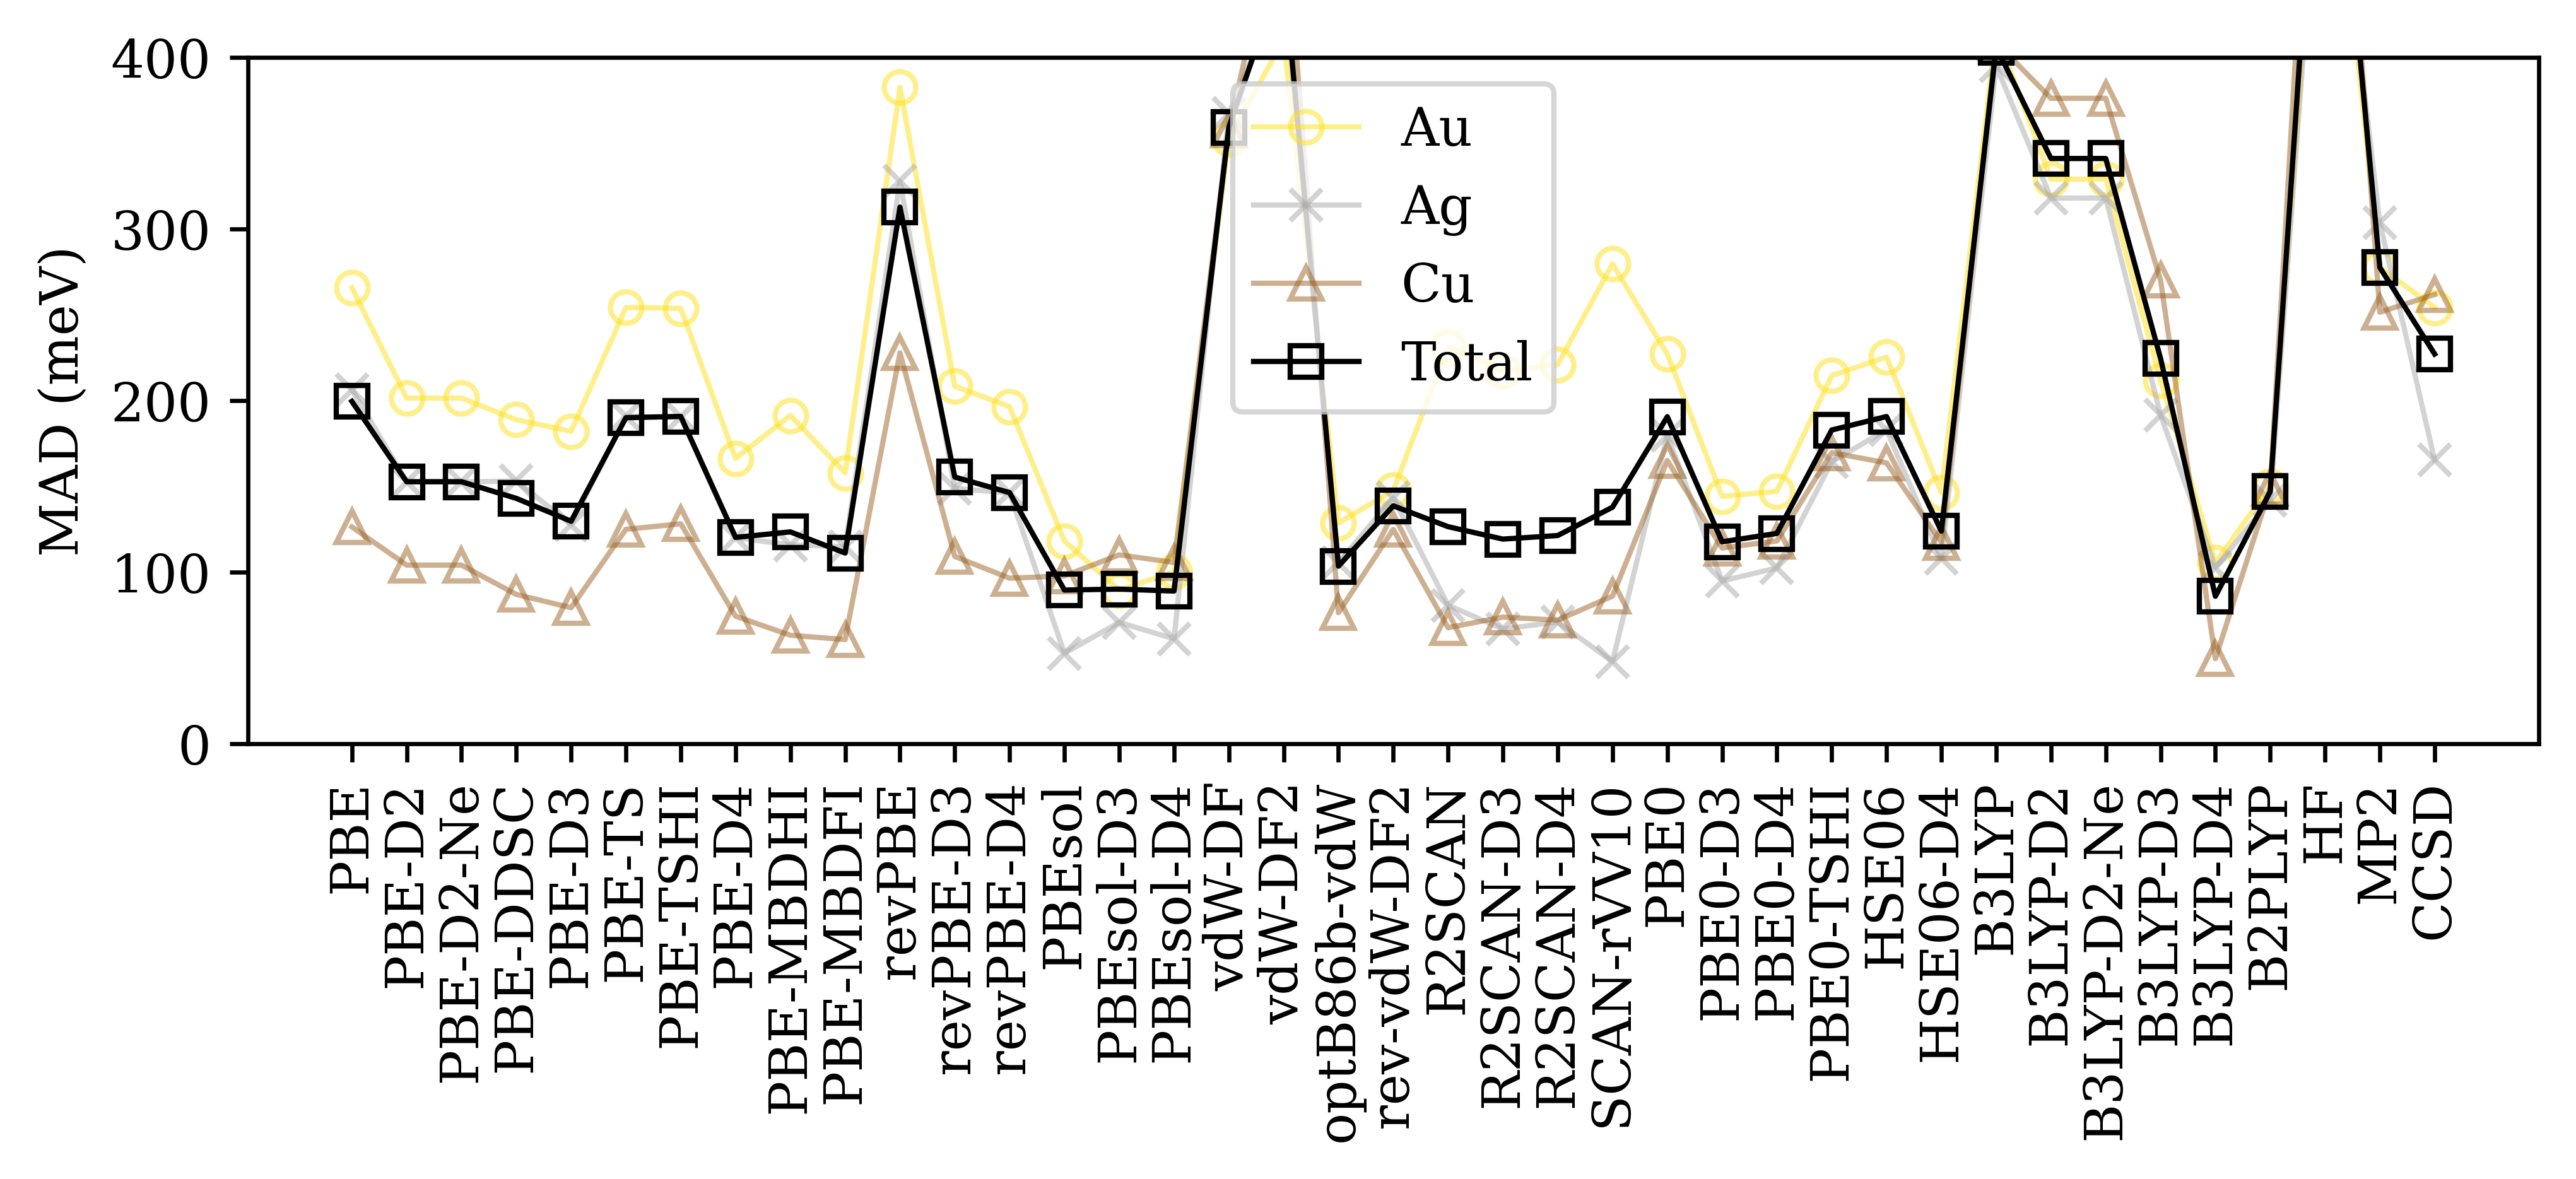

In [54]:
fig, axs = plt.subplots(figsize=(6.69,3),dpi=600, sharey=True,sharex=True,constrained_layout=True)


eov_method_sorted_list = xc_functional_list + ['B2PLYP','HF','MP2','CCSD']

# axs.
eov_method_sorted_list_val = np.array(list(range(len(eov_method_sorted_list))))

width=0.35

counter = 0
axs.plot(np.array(list(range(len(eov_method_sorted_list)))), [ (xc_rel_ene_mad['Au']['Total'][x]) for x in eov_method_sorted_list], marker='o',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['yellow'], linewidth=1,label='Au',alpha=0.5)
axs.plot(np.array(list(range(len(eov_method_sorted_list)))), [ (xc_rel_ene_mad['Ag']['Total'][x]) for x in eov_method_sorted_list], marker='x',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['grey'], linewidth=1,label='Ag',alpha=0.5)
axs.plot(np.array(list(range(len(eov_method_sorted_list)))), [ (xc_rel_ene_mad['Cu']['Total'][x]) for x in eov_method_sorted_list], marker='^',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['brown'], linewidth=1,label='Cu',alpha=0.5)
axs.plot(np.array(list(range(len(eov_method_sorted_list)))), [ (xc_rel_ene_mad['Total']['Total'][x]) for x in eov_method_sorted_list], marker='s',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['black'], linewidth=1,label='Total')

axs.legend()


axs.set_xticks(np.array(list(range(len(eov_method_sorted_list)))))
axs.set_xticklabels(eov_method_sorted_list,rotation=90)
axs.set_ylim([0,400])

axs.set_ylabel('MAD (meV)')

# plt.xticks(rotation=90)

plt.savefig('Figures/Gas_MAD_Overall.png')

# plt.savefig('Figures/Combined_graph.png')


In [55]:
eov_method_sorted_list_val = np.array(list(range(len(full_methods_list))))

for i in ['Au','Ag','Cu']:
    for j in [4,6,8]:
        erel_list = {y: [] for y in [1,2,3,4]}
        for k in full_methods_list:
            # print(k)
            counter = 0
            for k1 in [1,2,3,4]:
                erel_list[k1] += [xc_rel_ene_list[i][j][k][counter]]
                counter += 1



      

        fig, axs = plt.subplots(figsize=(6.69,5),dpi=300, constrained_layout=True)

        axs.plot(eov_method_sorted_list_val, erel_list[1] , marker='o',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['black'], linewidth=1,label='Structure 1')


        axs.plot(eov_method_sorted_list_val, erel_list[2] , marker='o',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['red'], linewidth=1,label='Structure 2')

        axs.plot([-1,42], [erel_list[2][-1]]*2 , '--',color=color_dict['red'], linewidth=1.3,alpha=0.7)


        axs.plot(eov_method_sorted_list_val, erel_list[3] , marker='o',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['blue'], linewidth=1,label='Structure 3')

        axs.plot([-1,42], [erel_list[3][-1]]*2 , '--',color=color_dict['blue'], linewidth=1.3,alpha=0.7)

        axs.plot(eov_method_sorted_list_val, erel_list[4] , marker='o',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['green'], linewidth=1,label='Structure 4')

        axs.plot([-1,42], [erel_list[4][-1]]*2 , '--',color=color_dict['green'], linewidth=1.3,alpha=0.7)


        axs.legend()

        axs.set_ylabel('Energy relative to Structure 1 (meV)')
        axs.set_title('{0}{1}'.format(i,j))

        axs.set_xticks(eov_method_sorted_list_val)
        axs.set_xticklabels(full_methods_list,rotation=90)

        axs.set_xlim([-1,40])
        # axs.set_ylim([-0.001,0.005])


        plt.savefig('Figures/Gas_Rel_Ene_{0}{1}.png'.format(i,j))
        plt.close()




In [56]:
xc_functional_list = ['PBE','PBE-D2','PBE-D2-Ne','PBE-DDSC','PBE-D3','PBE-TS','PBE-TSHI','PBE-D4','PBE-MBDHI','PBE-MBDFI','revPBE','revPBE-D3','revPBE-D4','PBEsol','PBEsol-D3','PBEsol-D4','vdW-DF','vdW-DF2','optB86b-vdW','rev-vdW-DF2','R2SCAN','R2SCAN-D3','R2SCAN-D4','SCAN-rVV10','PBE0','PBE0-D3','PBE0-D4','PBE0-TSHI','HSE06','HSE06-D4','B3LYP','B3LYP-D2','B3LYP-D2-Ne','B3LYP-D3','B3LYP-D4']

full_methods_list = xc_functional_list + ['B2PLYP','HF','MP2','CCSD','CCSD(T)']

m2_mgo_xc_bind_ene_list = { x: { y: {z : 0 for z in full_methods_list} for y in list(range(1,9))}  for x in ['Au','Ag','Cu']}
m2_mgo_xc_bind_ene_mad = { x: { y: {z : 0 for z in full_methods_list} for y in list(range(1,9)) + ['Total']}  for x in ['Au','Ag','Cu','Total']}

# m2_mgo_xc_bind_ene_mad = { x:  {z : 0 for z in full_methods_list} for x in ['Au','Ag','Cu','Total']}
# m2_mgo_xc_bind_ene_mad = { x:  {z : 0 for z in full_methods_list} for x in ['Au','Ag','Cu','Total']}


for i in ['Au','Ag','Cu']:
    for j in range(1,9): #,8]:
        for k in xc_functional_list:
            if k == 'optB86b-vdW':
                func_name = 'optB86b-vdw'
            elif k == 'rev-vdW-DF2':
                func_name = 'rev-vdw-DF2'
            # elif k == 'PBE-D2-Ne':
            #     func_name = 'PBE-D2'.lower()
            elif k == 'B3LYP-D2-Ne':
                func_name = 'B3LYP-D2'.lower()
    
            else:
                func_name = k.lower()
            
            a= find_energy('Data/02-M2_MgO/DFT/{0}2_MgO/{1}/{2}/AD_SLAB/OUTCAR'.format(i,j,func_name),code_format='vasp')
            b= find_energy('Data/02-M2_MgO/DFT/Au2_MgO/1/{0}/SLAB/OUTCAR'.format(func_name),code_format='vasp')
            c= find_energy('Data/02-M2_MgO/DFT/{0}2_MgO/{1}/{2}/AD/OUTCAR'.format(i,j,func_name),code_format='vasp')
            ene_dummy = (a-b-c)*1000
            # print(i,j,k,ene_dummy)
            m2_mgo_xc_bind_ene_list[i][j][k] = (ene_dummy)
            
    for l in range(1,9):
    
        # if (j == 3 and i == 'Ag') or (j == 3 and i == 'Cu'):
        #     continue
        
        ene_hf = []
        ene_mp2 = []
        ene_ccsd = []
        ene_ccsdt = []
        ene_dft = []
        ene_b2plyp = [] 
        for m in [1,3,2]:
            root_folder = 'Data/02-M2_MgO/cWFT/CC/{0}2_MgO/{1}/{2}'.format(i,l,m)
            # root_folder = 'Data/01-Gas_Cluster/cWFT/LCCSDT_From_PBE/{0}{1}/{2}/{3}/mrcc.out'.format(i,j,l,m)
            root_folder_b2plyp = 'Data/02-M2_MgO/cWFT/B2PLYP/{0}/B2PLYP_{1}/{2}'.format(i,m,j)

            ene_hf += [get_eads(root_folder,code_format='mrcc',typ='hf')]
            ene_mp2 += [get_eads(root_folder,code_format='mrcc',typ='lmp2')]
            ene_ccsd += [get_eads(root_folder,code_format='mrcc',typ='lccsd')]
            ene_ccsdt += [get_eads(root_folder,code_format='mrcc',typ='lccsdt')]
            ene_dft += [get_eads(root_folder_b2plyp,code_format='mrcc',typ='hf')]
            ene_b2plyp += [get_eads(root_folder_b2plyp,code_format='mrcc',typ='B2PLYP')]


        dummy_dict ={
            'MP2': extrapolate.get_cbs(ene_hf[0],ene_mp2[0],ene_hf[1],ene_mp2[1],X=3,Y=4,family='mixcc',\
            convert_Hartree=False ,shift=0.0,output=False),
            'CCSD': extrapolate.get_cbs(ene_hf[0],ene_ccsd[0],ene_hf[1],ene_ccsd[1],X=3,Y=4,family='mixcc',\
            convert_Hartree=False ,shift=0.0,output=False),
            'CCSD(T)': extrapolate.get_cbs(ene_hf[0],ene_ccsdt[0],ene_hf[1],ene_ccsdt[1],X=3,Y=4,family='mixcc',\
            convert_Hartree=False ,shift=0.0,output=False),
            'B2PLYP': extrapolate.get_cbs(ene_dft[0],ene_b2plyp[0],ene_dft[1],ene_b2plyp[1],X=3,Y=4,family='mixcc',\
            convert_Hartree=False ,shift=0.0,output=False)
        }
        # ,
        #     'B2PLYP': extrapolate.get_cbs(ene_dft[0],ene_b2plyp[0],ene_dft[1],ene_b2plyp[1],X=3,Y=4,family='mixcc',\
        #     convert_Hartree=False ,shift=0.0,output=False)
        # }
        # dummy_mp2 = extrapolate.get_cbs(ene_hf[0],ene_mp2[0],ene_hf[1],ene_mp2[1],X=3,Y=4,family='acc',\
        #     convert_Hartree=False ,shift=0.0,output=False)
        # dummy_ccsd = extrapolate.get_cbs(ene_hf[0],ene_ccsd[0],ene_hf[1],ene_ccsd[1],X=3,Y=4,family='acc',\
        #     convert_Hartree=False ,shift=0.0,output=False)
        # dummy_ccsdt = extrapolate.get_cbs(ene_hf[0],ene_ccsdt[0],ene_hf[1],ene_ccsdt[1],X=3,Y=4,family='acc',\
        #     convert_Hartree=False ,shift=0.0,output=False)
        # dummy_b2plyp = extrapolate.get_cbs(ene_dft[0],ene_b2plyp[0],ene_dft[1],ene_b2plyp[1],X=3,Y=4,family='acc',\
        #     convert_Hartree=False ,shift=0.0,output=False)



        m2_mgo_xc_bind_ene_list[i][l]['HF'] = (dummy_dict['MP2'][0])*1000*Hartree
        m2_mgo_xc_bind_ene_list[i][l]['MP2'] = (dummy_dict['MP2'][-1] + ene_mp2[-1] - ene_mp2[0])*1000*Hartree
        m2_mgo_xc_bind_ene_list[i][l]['CCSD'] = (dummy_dict['CCSD'][-1] + ene_ccsd[-1] - ene_ccsd[0])*1000*Hartree
        m2_mgo_xc_bind_ene_list[i][l]['CCSD(T)'] =  (dummy_dict['CCSD(T)'][-1] + ene_ccsdt[-1] - ene_ccsdt[0])*1000*Hartree
        m2_mgo_xc_bind_ene_list[i][l]['B2PLYP'] = (dummy_dict['B2PLYP'][-1] + ene_b2plyp[-1] - ene_b2plyp[0])*1000*Hartree

        # xc_rel_ene_list[i][j]['HF'] += [(dummy_dict['MP2'][0] - xc_bind_ene_list[i][j]['HF'][0])*1000]

        # for m in ['HF','MP2','CCSD','CCSD(T)','B2PLYP']:
        #     xc_rel_ene_list[i][j][m] += [(xc_bind_ene_list[i][j][m][-1]- xc_bind_ene_list[i][j][m][0])*1000*Hartree]



    

# for j in full_methods_list:




In [57]:
for j in xc_functional_list + ['B2PLYP','HF','MP2','CCSD']:
    for i in ['Au','Ag','Cu']:
        for k in range(1,9):
            m2_mgo_xc_bind_ene_mad[i][k][j] = abs(m2_mgo_xc_bind_ene_list[i][k][j] - m2_mgo_xc_bind_ene_list[i][k]['CCSD(T)'])
        m2_mgo_xc_bind_ene_mad[i]['Total'][j] = np.sum([abs(m2_mgo_xc_bind_ene_list[i][k][j] - m2_mgo_xc_bind_ene_list[i][k]['CCSD(T)']) for k in list(range(1,9))])/8

    m2_mgo_xc_bind_ene_mad['Total']['Total'][j] = (m2_mgo_xc_bind_ene_mad['Au']['Total'][j] + m2_mgo_xc_bind_ene_mad['Ag']['Total'][j] + m2_mgo_xc_bind_ene_mad['Cu']['Total'][j])/3
    for k in range(1,9):
        m2_mgo_xc_bind_ene_mad['Total'][k][j] = np.sum([abs(m2_mgo_xc_bind_ene_list[i][k][j] - m2_mgo_xc_bind_ene_list[i][k]['CCSD(T)']) for i in ['Au','Ag','Cu']])/3

In [58]:
for i in range(1,9):
    # print(m2_mgo_xc_bind_ene_list['Au'][i])
    print(m2_mgo_xc_bind_ene_list['Au'][i]['CCSD(T)'],m2_mgo_xc_bind_ene_list['Au'][i]['R2SCAN'],m2_mgo_xc_bind_ene_list['Au'][i]['PBE']) #,m2_mgo_xc_bind_ene_list['Au'][i]['PBE-D2-Ne'])

-1695.354415652835 -1739.464440000006 -1427.7001399999572
-229.18365119693087 -418.65793999997436 -304.5358299999576
-870.8084370990128 -999.7603999999853 -779.2797299999106
-431.2744140522763 -628.0762999999752 -368.57562000000723
-355.0307107890437 -548.6260099998646 -299.8099800000582
-879.5039751064131 -1050.2170599999658 -700.2423100000694
-587.8701353239635 -808.9518799998814 -496.2367099999758
-587.2207382248384 -733.1843400000508 -459.36902000002755


In [59]:
m2_mgo_xc_bind_ene_mad['Total']

{1: {'PBE': 194.6526956594732,
  'PBE-D2': 335.2921676740419,
  'PBE-D2-Ne': 96.63259434045904,
  'PBE-DDSC': 87.25464100726045,
  'PBE-D3': 248.43730100726808,
  'PBE-TS': 280.87790100719457,
  'PBE-TSHI': 63.27987144242434,
  'PBE-D4': 132.10372434059744,
  'PBE-MBDHI': 63.389974775776146,
  'PBE-MBDFI': 194.1071510072326,
  'revPBE': 483.7988656595751,
  'revPBE-D3': 349.145864340622,
  'revPBE-D4': 71.78195767385701,
  'PBEsol': 123.93706100715679,
  'PBEsol-D3': 561.8180810071611,
  'PBEsol-D4': 337.32840434066094,
  'vdW-DF': 289.00819232609814,
  'vdW-DF2': 307.85577565948097,
  'optB86b-vdW': 138.8520310072134,
  'rev-vdW-DF2': 30.950697673851096,
  'R2SCAN': 101.94450434053199,
  'R2SCAN-D3': 335.14910100715036,
  'R2SCAN-D4': 242.96624767395488,
  'SCAN-rVV10': 369.8011843406162,
  'PBE0': 320.44411565926146,
  'PBE0-D3': 162.21357100714053,
  'PBE0-D4': 24.475724775794674,
  'PBE0-TSHI': 83.80408565959063,
  'HSE06': 327.73396232604455,
  'HSE06-D4': 23.31297043905397,
  'B3

In [60]:
xc_rel_ene_mad

{'Au': {4: {'PBE': 210.77480577711344,
   'PBE-D2': 236.76334911044634,
   'PBE-D2-Ne': 236.76334911044634,
   'PBE-DDSC': 184.7716057771132,
   'PBE-D3': 187.18658244377949,
   'PBE-TS': 213.1104557771126,
   'PBE-TSHI': 211.51019577711259,
   'PBE-D4': 182.84895244377927,
   'PBE-MBDHI': 191.7844057771127,
   'PBE-MBDFI': 184.05932577711306,
   'revPBE': 293.94441577711285,
   'revPBE-D3': 245.7092891104463,
   'revPBE-D4': 241.46595577711253,
   'PBEsol': 93.66550059810176,
   'PBEsol-D3': 82.08574059810174,
   'PBEsol-D4': 86.34293393143504,
   'vdW-DF': 338.62512911044644,
   'vdW-DF2': 381.3207791104458,
   'optB86b-vdW': 160.0046457771132,
   'rev-vdW-DF2': 175.90877911044595,
   'R2SCAN': 166.87327577709627,
   'R2SCAN-D3': 162.74261911044516,
   'R2SCAN-D4': 163.82968244378438,
   'SCAN-rVV10': 156.83108726477465,
   'PBE0': 175.99197911044598,
   'PBE0-D3': 152.7010457771139,
   'PBE0-D4': 153.5816924437798,
   'PBE0-TSHI': 175.89659577711208,
   'HSE06': 179.31450244377947,


In [61]:
np.arange(5)

array([0, 1, 2, 3, 4])

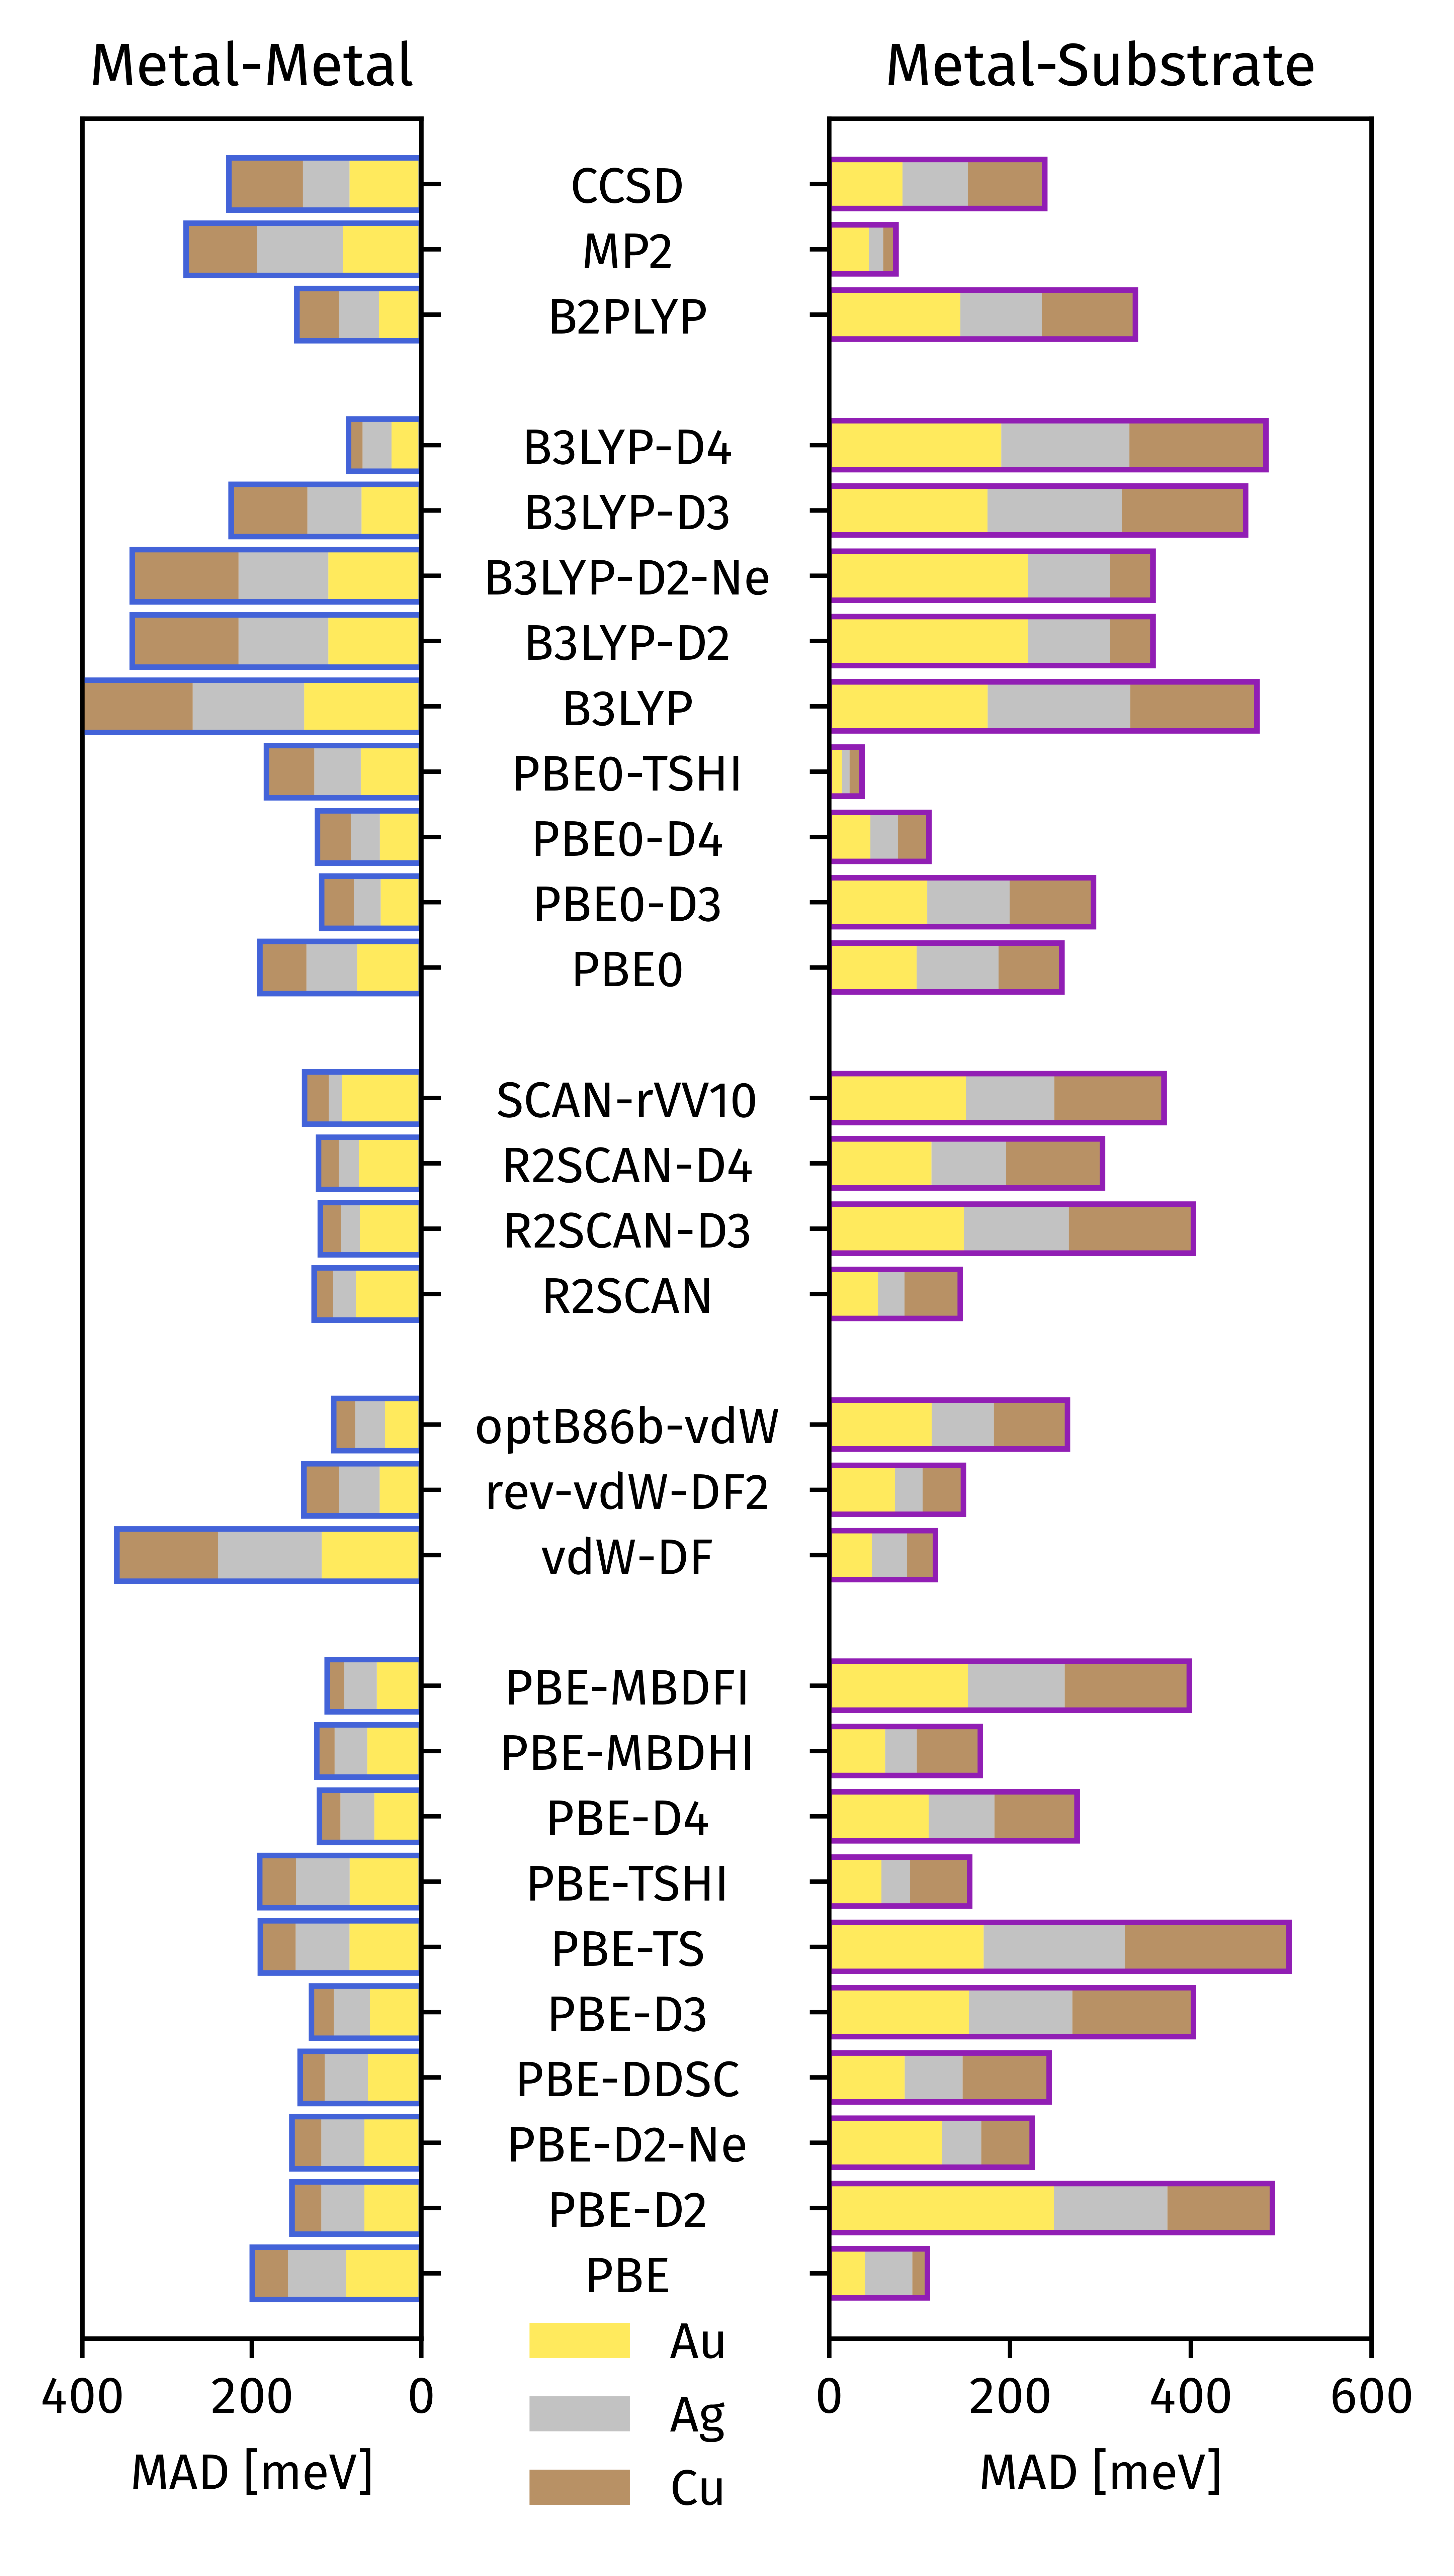

In [62]:
# Now plotting the graphs
# from jup_plot import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
# counter = 0
# axs.plot(np.array(list(range(len(eov_method_sorted_list)))), [ (xc_rel_ene_mad['Au']['Total'][x]) for x in eov_method_sorted_list], marker='o',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['yellow'], linewidth=1,label='Au',alpha=0.5)
# axs.plot(np.array(list(range(len(eov_method_sorted_list)))), [ (xc_rel_ene_mad['Ag']['Total'][x]) for x in eov_method_sorted_list], marker='x',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['grey'], linewidth=1,label='Ag',alpha=0.5)
# axs.plot(np.array(list(range(len(eov_method_sorted_list)))), [ (xc_rel_ene_mad['Cu']['Total'][x]) for x in eov_method_sorted_list], marker='^',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['brown'], linewidth=1,label='Cu',alpha=0.5)
# axs.plot(np.array(list(range(len(eov_method_sorted_list)))), [ (xc_rel_ene_mad['Total']['Total'][x]) for x in eov_method_sorted_list], marker='s',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['black'], linewidth=1,label='Total')

# axs.legend()


# axs.set_xticks(np.array(list(range(len(eov_method_sorted_list)))))
# axs.set_xticklabels(eov_method_sorted_list,rotation=90)
# axs.set_ylim([0,400])

# axs.set_ylabel('MAD (meV)')

# # plt.xticks(rotation=90)

# plt.savefig('Figures/Gas_MAD_Overall.png')
mm_to_inch=0.0393701

fig, axs = plt.subplots(1,2,figsize=(89*mm_to_inch,160*mm_to_inch),dpi=1200, gridspec_kw={'width_ratios': [1, 1.6]}, constrained_layout=True)

xc_functional_list = ['PBE','PBE-D2','PBE-D2-Ne','PBE-DDSC','PBE-D3','PBE-TS','PBE-TSHI','PBE-D4','PBE-MBDHI','PBE-MBDFI','revPBE','revPBE-D3','revPBE-D4','PBEsol','PBEsol-D3','PBEsol-D4','vdW-DF','vdW-DF2','optB86b-vdW','rev-vdW-DF2','R2SCAN','R2SCAN-D3','R2SCAN-D4','SCAN-rVV10','PBE0','PBE0-D3','PBE0-D4','PBE0-TSHI','HSE06','HSE06-D4','B3LYP','B3LYP-D2','B3LYP-D2-Ne','B3LYP-D3','B3LYP-D4']

gga_xc_list = ['PBE','PBE-D2','PBE-D2-Ne','PBE-DDSC','PBE-D3','PBE-TS','PBE-TSHI','PBE-D4','PBE-MBDHI','PBE-MBDFI']
vdw_inc_xc_list = ['vdW-DF','rev-vdW-DF2','optB86b-vdW']
metagga_xc_list = ['R2SCAN','R2SCAN-D3','R2SCAN-D4','SCAN-rVV10']
hybrid_xc_list = ['PBE0','PBE0-D3','PBE0-D4','PBE0-TSHI','B3LYP','B3LYP-D2','B3LYP-D2-Ne','B3LYP-D3','B3LYP-D4']
cwft_xc_list = ['B2PLYP','MP2','CCSD']

eov_method_sorted_list = gga_xc_list + vdw_inc_xc_list + metagga_xc_list + hybrid_xc_list + cwft_xc_list

#xc_functional_list + ['B2PLYP','HF','MP2','CCSD']

eov_method_sorted_list_val = np.concatenate((np.arange(len(gga_xc_list)), 11 + np.arange(len(vdw_inc_xc_list)), 15 + np.arange(len(metagga_xc_list)), 20 + np.arange(len(hybrid_xc_list)), 30 + np.arange(len(cwft_xc_list))))
                                              


# np.append(list(range(len(gga_xc_list))),list(range(len(gga_xc_list), len(vdw_inc_xc_list))) + list(range(len(vdw_inc_xc_list), len()))

# eov_method_sorted_list_val = np.array(list(range(len(eov_method_sorted_list))))


width = 0.5

ax1 = axs[0].twinx()






ax1.barh(eov_method_sorted_list_val*2,  [ (xc_rel_ene_mad['Au']['Total'][x])/3 for x in eov_method_sorted_list],1.5,label=r'Au', alpha=0.7,color=color_dict['yellow'])
ax1.barh(eov_method_sorted_list_val*2,  [ (xc_rel_ene_mad['Ag']['Total'][x])/3 for x in eov_method_sorted_list], 1.5, left = np.array([ (xc_rel_ene_mad['Au']['Total'][x])/3 for x in eov_method_sorted_list])  , alpha=0.7,label=r'Ag',color=color_dict['grey'])
ax1.barh(eov_method_sorted_list_val*2,  [ (xc_rel_ene_mad['Cu']['Total'][x])/3 for x in eov_method_sorted_list],1.5,left = [ (xc_rel_ene_mad['Ag']['Total'][x]+ xc_rel_ene_mad['Au']['Total'][x])/3 for x in eov_method_sorted_list], alpha=0.7,label=r'Cu',color=color_dict['brown'])

ax1.barh(eov_method_sorted_list_val*2, [(xc_rel_ene_mad['Total']['Total'][x]) for x in eov_method_sorted_list],1.6, linewidth=1,color='none',edgecolor=color_dict['blue'])

# ax1.plot([(xc_rel_ene_mad['Total']['Total'][x]) for x in eov_method_sorted_list], eov_method_sorted_list_val*2, marker='x',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['black'], linewidth=0,label='Total')



# axs[0].barh(eov_method_sorted_list_val*2+width,  [ (xc_rel_ene_mad['Au']['Total'][x]) for x in eov_method_sorted_list],width,label=r'Au',color=color_dict['yellow'])
# axs[0].barh(eov_method_sorted_list_val*2,  [ (xc_rel_ene_mad['Ag']['Total'][x]) for x in eov_method_sorted_list],width,label=r'Ag',color=color_dict['grey'])
# axs[0].barh(eov_method_sorted_list_val*2 -width,  [ (xc_rel_ene_mad['Cu']['Total'][x]) for x in eov_method_sorted_list],width,label=r'Cu',color=color_dict['brown'])
# axs[0].plot([ (xc_rel_ene_mad['Total']['Total'][x]) for x in eov_method_sorted_list], eov_method_sorted_list_val*2, marker='s',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['black'], linewidth=1,label='Total')






axs[1].barh(eov_method_sorted_list_val*2, [m2_mgo_xc_bind_ene_mad['Au']['Total'][x]/3 for x in eov_method_sorted_list],1.5,label=r'Au',alpha=0.7,color=color_dict['yellow'])
axs[1].barh(eov_method_sorted_list_val*2, [m2_mgo_xc_bind_ene_mad['Ag']['Total'][x]/3 for x in eov_method_sorted_list],1.5,left= [m2_mgo_xc_bind_ene_mad['Au']['Total'][x]/3 for x in eov_method_sorted_list],label=r'Ag',alpha=0.7,color=color_dict['grey'])
axs[1].barh(eov_method_sorted_list_val*2, [m2_mgo_xc_bind_ene_mad['Cu']['Total'][x]/3 for x in eov_method_sorted_list],1.5,left= [(m2_mgo_xc_bind_ene_mad['Au']['Total'][x] + m2_mgo_xc_bind_ene_mad['Ag']['Total'][x]) /3 for x in eov_method_sorted_list],label=r'Cu',alpha=0.7,color=color_dict['brown'])

# axs.plot(eov_method_sorted_list_val, [m2_mgo_xc_bind_ene_mad['Au'][x] for x in eov_method_sorted_list] , marker='x',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['orange'], linewidth=1,label='Au2/MgO',alpha=0.5)
# axs.plot(eov_method_sorted_list_val, [m2_mgo_xc_bind_ene_mad['Ag'][x] for x in xc_functional_list + ['HF','MP2','CCSD']] , marker='x',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['grey'], linewidth=1,label='Ag2/MgO',alpha=0.5)
# axs.plot(eov_method_sorted_list_val, [m2_mgo_xc_bind_ene_mad['Cu'][x] for x in xc_functional_list + ['HF','MP2','CCSD']] , marker='x',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['red'], linewidth=1,label='Cu2/MgO',alpha=0.5)

axs[1].barh(eov_method_sorted_list_val*2, [m2_mgo_xc_bind_ene_mad['Total']['Total'][x] for x in eov_method_sorted_list],1.5, linewidth=1, color='none',edgecolor=color_dict['purple'])

# axs[1].plot([m2_mgo_xc_bind_ene_mad['Total']['Total'][x] for x in eov_method_sorted_list] ,eov_method_sorted_list_val*2, marker='x',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['black'], linewidth=0,label='Total')





# m2_tot_bind_ene_mad = [ (xc_bind_ene_mad['Au'][x] + xc_bind_ene_mad['Ag'][x] + xc_bind_ene_mad['Cu'][x])/3 for x in eov_method_sorted_list]

ax1.set_yticks(eov_method_sorted_list_val*2)
ax1.set_yticklabels([])
axs[0].set_yticks([])
axs[0].set_yticklabels([])
axs[1].set_yticks(eov_method_sorted_list_val*2)

axs[0].set_title('Metal-Metal')
axs[1].set_title('Metal-Substrate')
axs[0].set_xlabel('MAD [meV]')
axs[1].set_xlabel('MAD [meV]')



axs[1].set_yticklabels(eov_method_sorted_list,ha='center',position=(-0.3,0))

ax1.set_xlabel('MAD from LNO-CCSD(T) (meV)')
axs[1].legend(loc='lower center', bbox_to_anchor=(-0.37, -0.1),frameon=False)
ax1.set_xlim([400,0])
axs[1].set_xlim([0,600])

ax1.set_ylim([-2,66])
axs[1].set_ylim([-2,66])



# axs.set_ylim([0,0.6])


plt.savefig('Figures/M2_MgO_Bind_ene.png')


In [63]:
print(eov_method_sorted_list_val)

[ 0  1  2  3  4  5  6  7  8  9 11 12 13 15 16 17 18 20 21 22 23 24 25 26
 27 28 30 31 32]


In [64]:
for x in eov_method_sorted_list:
    print((xc_rel_ene_mad['Ag']['Total'][x] + xc_rel_ene_mad['Au']['Total'][x] + xc_rel_ene_mad['Cu']['Total'][x])/3,xc_rel_ene_mad['Total']['Total'][x])
# print([ (xc_rel_ene_mad['Ag']['Total'][x] + xc_rel_ene_mad['Au']['Total'][x] + xc_rel_ene_mad['Cu']['Total'][x])/3 for x in eov_method_sorted_list], [xc_rel_ene_mad['Total']['Total'][x] for x in eov_method_sorted_list])

199.43398666323392 199.43398666323392
152.60638467597502 152.60638467597502
152.60638467597502 152.60638467597502
142.8988798130196 142.8988798130196
129.56217055376024 129.56217055376024
189.92743629286306 189.92743629286306
190.6739798225913 190.6739798225913
120.14120630571028 120.14120630571028
123.35296408348857 123.35296408348857
111.02067037978479 111.02067037978479
359.24416908345546 359.24416908345546
138.53399737573778 138.53399737573778
103.35732420609799 103.35732420609799
126.3996846217335 126.3996846217335
119.14804091803369 119.14804091803369
121.22378573285239 121.22378573285239
137.73896955577598 137.73896955577598
190.5027425730198 190.5027425730198
117.57896886931591 117.57896886931591
122.46989849894567 122.46989849894567
182.7515133137601 182.7515133137601
406.0457122187895 406.0457122187895
341.05869998435804 341.05869998435804
341.05869998435804 341.05869998435804
224.38409405843223 224.38409405843223
85.80822128651637 85.80822128651637
146.8251590563314 146.8251

In [65]:
[ (xc_rel_ene_mad['Au']['Total'][x]) for x in eov_method_sorted_list] 

[265.74084079217636,
 201.34905186666,
 201.34905186666,
 188.77454412550878,
 181.9631263477306,
 254.19797412550807,
 253.7328885699536,
 166.230634125508,
 191.19868190328688,
 157.7593796810647,
 352.6539707921756,
 147.56953841585525,
 128.4877250825222,
 231.15725079216804,
 217.04567190329226,
 220.90522968107598,
 279.63467684360967,
 227.0287208389544,
 144.0438841722887,
 147.02868750562158,
 214.45330861673187,
 414.3079996810652,
 329.02571186665926,
 329.02571186665926,
 211.68517742221562,
 105.42354837922828,
 149.84674123855453,
 277.5819279065124,
 254.15585716818705]

In [66]:
np.concatenate((np.arange(len(gga_xc_list)), 11 + np.arange(len(vdw_inc_xc_list)), 18 + np.arange(len(metagga_xc_list)), 27 + np.arange(len(hybrid_xc_list)), 39 + np.arange(len(cwft_xc_list))))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 18, 19, 20, 21,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 39, 40, 41])

In [67]:
eov_method_sorted_list_val

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 15, 16, 17, 18,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32])

0 PBE-D2
1 PBE-D2-Ne
2 PBE-D3
3 PBE-D4
4 PBE-DDSC
5 PBE-TS
6 PBE-TSHI
7 PBE-MBDHI
8 PBE-MBDFI


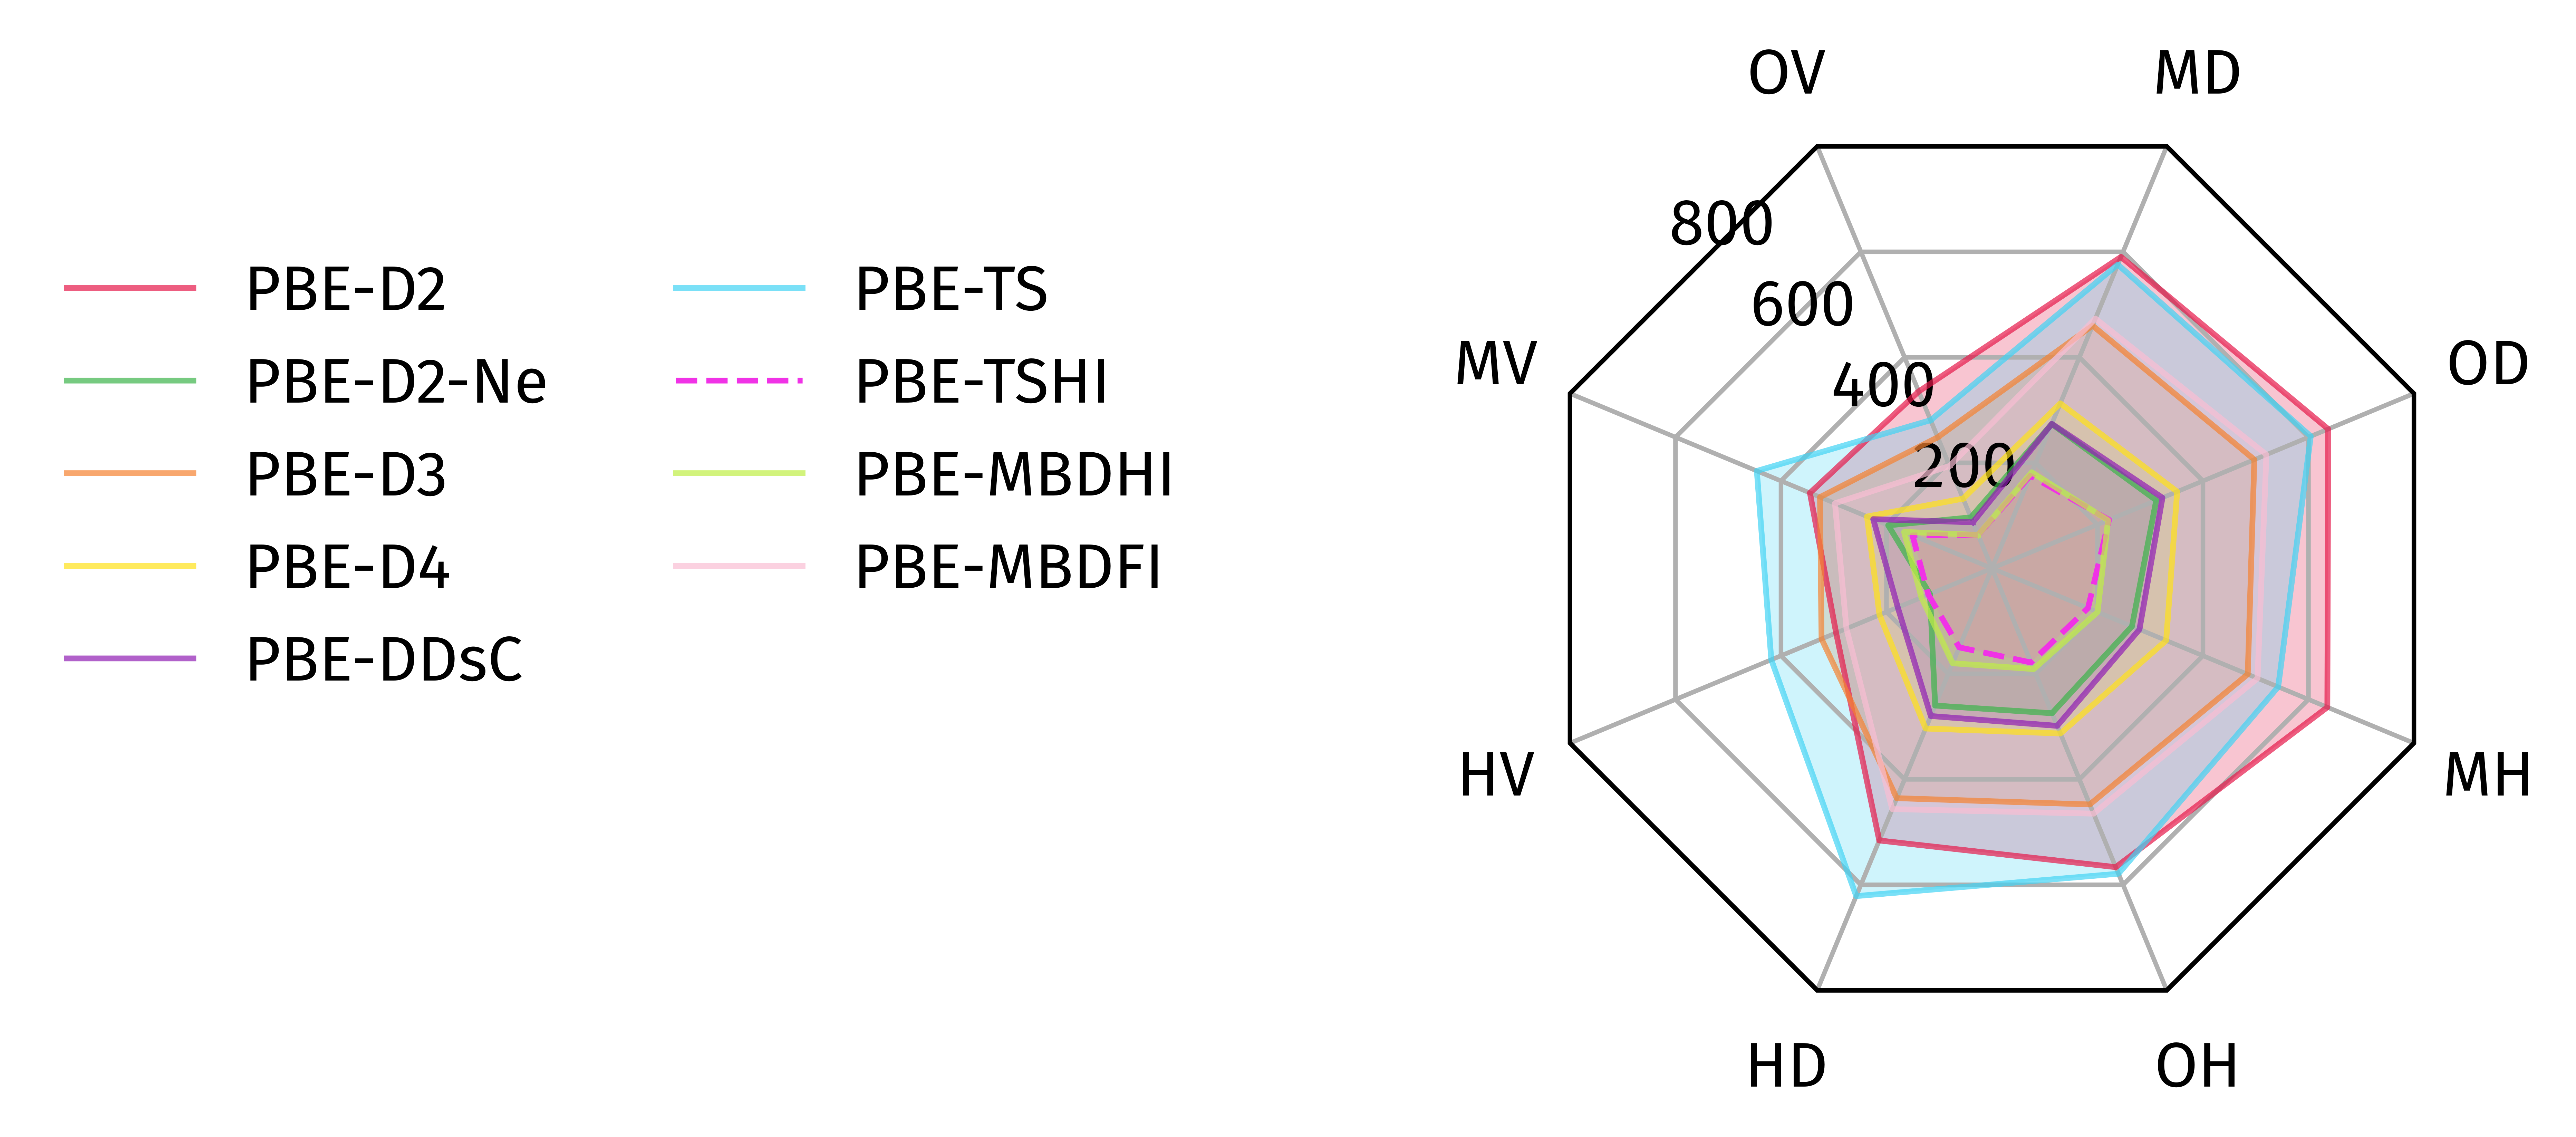

In [68]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D



def radar_factory(num_vars, frame='circle',rotation=0):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False) 

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')
            self.set_theta_offset(rotation)


        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k",orientation=rotation)
                # return RegularPolygon((0.5, 0.5), num_vars,
                #                       radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                # spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                #                     + self.transAxes)
                spine.set_transform(Affine2D().rotate(rotation).scale(.5).translate(.5, .5)
                                    + self.transAxes)
                # print(spine)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

dimer={0: 'OV', 1: 'MV', 2: 'HV', 3: 'HD',
       4: 'OH', 5: 'MH', 6: 'OD', 7: 'MD'
      }


def example_data():
    data = [
        [dimer[0], dimer[1], dimer[2], dimer[3], 
         dimer[4], dimer[5], dimer[6], dimer[7]],
        ('PBE+vdW empirical', [
            [m2_mgo_xc_bind_ene_mad['Total'][x]['PBE-D2'] for x in list(range(1,9))],
            [m2_mgo_xc_bind_ene_mad['Total'][x]['PBE-D2-Ne'] for x in list(range(1,9))],
            [m2_mgo_xc_bind_ene_mad['Total'][x]['PBE-D3'] for x in list(range(1,9))],
            [m2_mgo_xc_bind_ene_mad['Total'][x]['PBE-D4'] for x in list(range(1,9))],
            [m2_mgo_xc_bind_ene_mad['Total'][x]['PBE-DDSC'] for x in list(range(1,9))],
            [m2_mgo_xc_bind_ene_mad['Total'][x]['PBE-TS'] for x in list(range(1,9))],
            [m2_mgo_xc_bind_ene_mad['Total'][x]['PBE-TSHI'] for x in list(range(1,9))],
            [m2_mgo_xc_bind_ene_mad['Total'][x]['PBE-MBDHI'] for x in list(range(1,9))],
            [m2_mgo_xc_bind_ene_mad['Total'][x]['PBE-MBDFI'] for x in list(range(1,9))]
        ])
    ]
    return data



N = 8
theta = radar_factory(N, frame='polygon',rotation=5*np.pi/8)
# theta = [x+np.pi/8 for x in theta]
# print(theta)

data = example_data()
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(89*mm_to_inch,70*mm_to_inch),dpi=1200,subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',]
axs.set_rgrids([200,400,600,800])
# axs.set_title(r'$E_\textrm{int}^\textrm{M-S}$ error w.r.t. CCSD(T) (meV)', size=11, position=(0.5, 1.1),
                # horizontalalignment='center', verticalalignment='center')

colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8','C9']


for index, i in enumerate(['PBE-D2', 'PBE-D2-Ne', 'PBE-D3', 'PBE-D4','PBE-DDSC', 'PBE-TS', 'PBE-TSHI', 'PBE-MBDHI','PBE-MBDFI']):
    print(index,i)
    if 'TSHI' in i:
        axs.plot(theta, [m2_mgo_xc_bind_ene_mad['Total'][x][i] for x in list(range(1,9))],'--',color=colors[index],linewidth=1)
        axs.fill(theta, [m2_mgo_xc_bind_ene_mad['Total'][x][i] for x in list(range(1,9))], facecolor=colors[index], alpha=0.25, label='_nolegend_')
    else:
        axs.plot(theta, [m2_mgo_xc_bind_ene_mad['Total'][x][i] for x in list(range(1,9))],color=colors[index],linewidth=1, alpha=0.7)
        axs.fill(theta, [m2_mgo_xc_bind_ene_mad['Total'][x][i] for x in list(range(1,9))], facecolor=colors[index], alpha=0.25, label='_nolegend_')            

axs.set_varlabels(spoke_labels)
# axs.set_theta_offset(-np.pi/8)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)


# add legend relative to top-left plot
labels = ('PBE-D2', 'PBE-D2-Ne', 'PBE-D3', 'PBE-D4','PBE-DDsC', 'PBE-TS', 'PBE-TSHI', 'PBE-MBDHI', 'PBE-MBDFI')
legend = axs.legend(labels,ncol=2, fontsize=11,loc='lower center', bbox_to_anchor=(-1, 0.3),frameon=False) # loc=(0.9, .9),
                        #   labelspacing=0.1, fontsize='large')


plt.ylim([0.0,800])


plt.savefig('Figures/M2_MgO_PBE_spider_plot.png',dpi=1200,bbox_inches = "tight")

In [ ]:
[m2_mgo_xc_bind_ene_mad['Total'][x][i] for x in list(range(1,9))]

[63.38997635337913,
 166.61582877342582,
 133.75127282063906,
 179.9903120797879,
 191.0152745174563,
 200.18028961996228,
 220.1530895929609,
 182.02386198838497]

In [ ]:
[m2_mgo_xc_bind_ene_mad['Cu'][x] for x in xc_functional_list + ['HF','MP2','CCSD']]

[49.95237776070641,
 348.3262403846173,
 348.3262403846173,
 287.3608616345532,
 401.9015091345616,
 544.3520341344888,
 197.40522663444483,
 274.1348866346068,
 211.08621788458535,
 413.68319038459083,
 311.79346836556573,
 549.660705384573,
 250.42258288447718,
 188.32554788451725,
 615.7954653844881,
 392.6735053846228,
 94.65071088065703,
 99.90942588068418,
 244.5518478845173,
 135.54717663450253,
 185.11775288451202,
 413.6428866344284,
 320.36592788456767,
 364.27806788457093,
 210.19918961536166,
 278.5381991345032,
 102.4663978845545,
 41.04686910531616,
 215.28729836544187,
 92.94101971096836,
 142.17411977893596,
 142.17411977893596,
 410.450690384473,
 453.25902663446584,
 937.1746726868378,
 42.14324077261681,
 254.44042154943378]

# Supplementary Data

## Gas phase analysis

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess

In [126]:
def xc_gas_relist(xc_functional_list,remove):
    '''
    Removes certain functionals from the analysis. D2-Ne functionals are redundant for gas phase analysis. 
    '''
    # Use list comprehension to remove the strings
    xc_functional_list = [x for x in xc_functional_list if x not in remove]
    
    return xc_functional_list

In [127]:
def change_multiple_xc_names(xcs, name_pairs):
    '''
    Change multiple XC names based on the provided name_pairs.
    
    Parameters:
    - xcs: list of XC names
    - name_pairs: list of tuples where each tuple has the old name and the new name.
    
    Returns:
    - Updated list of XC names
    '''
    
    def change_xc_name(xcs, old, new): 
        '''
        Change a single XC name into a new one.
        '''
        return [new if item == old else item for item in xcs]
    
    for old, new in name_pairs:
        xcs = change_xc_name(xcs, old, new)
    
    return xcs

In [147]:
xc_functional_list = ['PBE','PBE-D2','PBE-D2-Ne','PBE-DDSC','PBE-D30','PBE-D3','PBE-TS','PBE-TSHI','PBE-D4','PBE-MBDHI',
                      'PBE-MBDFI','revPBE','REVPBE-D30','revPBE-D3','revPBE-D4','PBEsol','PBEsol-D3','PBEsol-D4','vdW-DF',
                      'vdW-DF2','optB86b-vdW','rev-vdW-DF2','TPSS','R2SCAN','R2SCAN-D3','R2SCAN-D4','R2SCAN-RVV10','SCAN-rVV10',
                      'PBE0','PBE0-D30','PBE0-D3','PBE0-D4','PBE0-TSHI','PBE0-MBDHI','PBE0-MBDFI','HSE06','HSE06-D4',
                      'B3LYP','B3LYP-D2','B3LYP-D2-Ne','B3LYP-D30','B3LYP-D3','B3LYP-D4']

xc_functional_list=xc_gas_relist(xc_functional_list,remove=['PBE-D2-Ne','B3LYP-D2-Ne'])

full_methods_list = xc_functional_list + ['B2PLYP','HF','MP2','CCSD','CCSD(T)']

xc_rel_ene_list = { x: { y: {z : [] for z in full_methods_list} for y in [4,6,8]}  for x in ['Au','Ag','Cu']}
xc_bind_ene_list = { x: { y: {z : [] for z in full_methods_list} for y in [4,6,8]}  for x in ['Au','Ag','Cu']}

xc_rel_ene_mad = { x: { y: {z : [] for z in full_methods_list} for y in [4,6,8,'Total']}  for x in ['Au','Ag','Cu','Total']}
xc_bind_ene_mad = { x: { y: {z : [] for z in full_methods_list} for y in [4,6,8]}  for x in ['Au','Ag','Cu']}


for i in ['Au','Ag','Cu']:
    for j in [4,6,8]:
        for k in xc_functional_list:
            if k == 'optB86b-vdW':
                func_name = 'optB86b-vdw'
            elif k == 'rev-vdW-DF2':
                func_name = 'rev-vdw-DF2'
            elif k == 'PBE-D2-Ne':
                func_name = 'PBE-D2'.lower()
            elif k == 'B3LYP-D2-Ne':
                func_name = 'B3LYP-D2'.lower()
    
            else:
                func_name = k.lower()
            
            #DFT data
            ene_0 = find_energy('Data/01-Gas_Cluster/DFT/{0}{1}/1/{2}/AD/OUTCAR'.format(i,j,func_name),code_format='vasp')
            ene_sa= find_energy(f'Data/00-Isolated_Atom/DFT/{i}/{func_name}/AD/OUTCAR'.format(i,j,func_name),code_format='vasp')
            for l in [1,2,3,4]:
                ene_ad= find_energy('Data/01-Gas_Cluster/DFT/{0}{1}/{3}/{2}/AD/OUTCAR'.format(i,j,func_name,l),code_format='vasp')
                xc_rel_ene_list[i][j][k] += [(ene_ad - ene_0)*1000]
                xc_bind_ene_list[i][j][k] += [(ene_sa-ene_ad/j)*1000] #gas phase binding energy [eV/atom]
        
        #WFT
        for l in [1,2,3,4]:
           
            ene_hf = []
            ene_mp2 = []
            ene_ccsd = []
            ene_ccsdt = []
            ene_dft = []
            ene_b2plyp = [] 
            for m in [1,3,2]:
                root_folder = 'Data/01-Gas_Cluster/cWFT/LCCSDT_From_PBE/{0}{1}/{2}/{3}/mrcc.out'.format(i,j,l,m)
                root_folder_b2plyp = 'Data/01-Gas_Cluster/cWFT/B2PLYP/{0}{1}/{2}/{3}/mrcc.out'.format(i,j,l,m)

                ene_hf += [find_energy(root_folder,code_format='mrcc',typ='hf')]
                ene_mp2 += [find_energy(root_folder,code_format='mrcc',typ='lmp2')]
                ene_ccsd += [find_energy(root_folder,code_format='mrcc',typ='lccsd')]
                ene_ccsdt += [find_energy(root_folder,code_format='mrcc',typ='lccsdt')]
                ene_dft += [find_energy(root_folder_b2plyp,code_format='mrcc',typ='hf')]
                ene_b2plyp += [find_energy(root_folder_b2plyp,code_format='mrcc',typ='B2PLYP')]


            dummy_dict ={
                'MP2': extrapolate.get_cbs(ene_hf[0],ene_mp2[0],ene_hf[1],ene_mp2[1],X=3,Y=4,family='acc',\
                convert_Hartree=False ,shift=0.0,output=False),
                'CCSD': extrapolate.get_cbs(ene_hf[0],ene_ccsd[0],ene_hf[1],ene_ccsd[1],X=3,Y=4,family='acc',\
                convert_Hartree=False ,shift=0.0,output=False),
                'CCSD(T)': extrapolate.get_cbs(ene_hf[0],ene_ccsdt[0],ene_hf[1],ene_ccsdt[1],X=3,Y=4,family='acc',\
                convert_Hartree=False ,shift=0.0,output=False),
                'B2PLYP': extrapolate.get_cbs(ene_dft[0],ene_b2plyp[0],ene_dft[1],ene_b2plyp[1],X=3,Y=4,family='acc',\
                convert_Hartree=False ,shift=0.0,output=False)
            }

            xc_bind_ene_list[i][j]['HF'] += [dummy_dict['MP2'][0]]
            xc_bind_ene_list[i][j]['MP2'] += [dummy_dict['MP2'][-1] + ene_mp2[-1] - ene_mp2[0]]
            xc_bind_ene_list[i][j]['CCSD'] += [dummy_dict['CCSD'][-1] + ene_ccsd[-1] - ene_ccsd[0]]
            xc_bind_ene_list[i][j]['CCSD(T)'] += [dummy_dict['CCSD(T)'][-1] + ene_ccsdt[-1] - ene_ccsdt[0]]
            xc_bind_ene_list[i][j]['B2PLYP'] += [dummy_dict['B2PLYP'][-1] + ene_b2plyp[-1] - ene_b2plyp[0]]

            # xc_rel_ene_list[i][j]['HF'] += [(dummy_dict['MP2'][0] - xc_bind_ene_list[i][j]['HF'][0])*1000]

            for m in ['HF','MP2','CCSD','CCSD(T)','B2PLYP']:
                xc_rel_ene_list[i][j][m] += [(xc_bind_ene_list[i][j][m][-1]- xc_bind_ene_list[i][j][m][0])*1000*Hartree]



In [148]:
xc_bind_ene_list['Au'][4]['PBE-D3']

[1602.9490775, 1589.2695225, 1490.7356374999997, 1320.019595]

### Table Relatvie Energy Ordering

In [132]:
def generate_data_for_systems(full_methods_list, n, m, metal, systems=["AD"]):

    '''
    m=number of isomers
    n=number of metal clusters
    '''
    xcs = full_methods_list
    
    energies = []
    for xc in xcs:
        energies+=xc_rel_ene_list[metal][n][xc]
        
    return xcs, energies

def generate_all_data(full_methods_list, n, m, metals=['Au','Ag','Cu']):
    all_energies = []

    xcs=full_methods_list
    for metal in metals:
        #we assume that all xcs used are equal
        xcs, energies = generate_data_for_systems(xcs,n, m, metal)
        all_energies.extend(energies)

    return xcs, all_energies

def to_integrated_latex_table(n, xcs, energies, metals=['Au','Ag','Cu']):
    num_metals = len(metals)
    num_isomers = len(energies) // (len(xcs) * num_metals)
    ev_to_mev = 1000.

    table = "\\begin{table}[ht]\n"
    table += "\\centering\n"
    table += f"\\caption{{Comparison of relative isomer ground state energies (meV) of gas phase {', '.join(metals)}{n} across different DFT functionals and wavefunction methods.}}\n"
    table += "\\begin{tabular}{c" + "c"*num_isomers*num_metals + "}\n"
    table += "\\hline\\hline\n"
    
    # Construct metal header
    metal_header = " & ".join([f"\\multicolumn{{{num_isomers}}}{{c}}{{{metal}}}" for metal in metals])
    table += f"DFT Functional & {metal_header} \\\\ \n"
    
    # Construct isomer numbering header with correct \\cline
    end_column = num_isomers * num_metals + 1
    table += f"\\cline{{2-{end_column}}}\n"
    
    #isomer_nums = " & ".join([" & ".join(str(i+1) for i in range(num_isomers)) for _ in metals])
    #table += f" & {isomer_nums} \\\\ \\hline\n"

    # Construct isomer numbering header
    isomer_nums = " & ".join([" & ".join(str(i+1) for i in range(num_isomers)) for _ in metals])
    table += f" & {isomer_nums} \\\\ \\hline\n"
    
    
    name_pairs = [('PBE-D3', 'PBE-D3BJ'),('PBE-D30', 'PBE-D3'),('revPBE-D3','revPBE-D3BJ'),('REVPBE-D30','revPBE-D3'),
                  ('PBEsol-D3','PBEsol-D3BJ'),('PBE0-D3','PBE0-D3BJ'),('PBE0-D30','PBE0-D3'),
                  ('B3LYP-D3','B3LYP-D3BJ'),('B3LYP-D30','B3LYP-D3')
                 ]
    xcs_rev = change_multiple_xc_names(xcs, name_pairs)

    # Add data rows
    for idx, xc in enumerate(xcs_rev):
        row_energies = []
        for metal_idx in range(num_metals):
            start = (idx + metal_idx * len(xcs)) * num_isomers
            end = start + num_isomers
            energies_for_xc_metal = energies[start:end]
            row_energies.extend([f"{int(round(e))}" for e in energies_for_xc_metal])
        table += f"{xc} & " + " & ".join(row_energies) + " \\\\ \n"
    
    # Double line at the end
    table += "\\hline\\hline\n"
    table += "\\end{tabular}\n"
    table += "\\end{table}"

    return table


In [133]:
# Usage
for n in [4,6,8]:
    m=4
    xcs, energies = generate_all_data(full_methods_list,n,m,metals=['Au','Ag','Cu'])
    latex_table = to_integrated_latex_table(n, full_methods_list, energies, metals=['Au','Ag','Cu'])

    with open(f"Tables/energy_table_gasphase_metal{n}.tex", 'w') as f:
        f.write(latex_table)

    print("Latex table written to energy_table.tex!")

Latex table written to energy_table.tex!
Latex table written to energy_table.tex!
Latex table written to energy_table.tex!


### Table Relative Binding Energy

In [153]:
def generate_data_for_systems(full_methods_list, n, m, metal, systems=["AD"]):

    '''
    m=number of isomers
    n=number of metal clusters
    '''
    xcs = full_methods_list
    
    energies = []
    for xc in xcs:
        energies+=xc_bind_ene_list[metal][n][xc]
        
    return xcs, energies

def generate_all_data(full_methods_list, n, m, metals=['Au','Ag','Cu']):
    all_energies = []

    xcs=full_methods_list
    for metal in metals:
        #we assume that all xcs used are equal
        xcs, energies = generate_data_for_systems(xcs,n, m, metal)
        all_energies.extend(energies)

    return xcs, all_energies

def to_integrated_latex_table(n, xcs, energies, metals=['Au','Ag','Cu']):
    num_metals = len(metals)
    num_isomers = len(energies) // (len(xcs) * num_metals)
    ev_to_mev = 1000.

    table = "\\begin{table}[ht]\n"
    table += "\\centering\n"
    table += f"\\caption{{Comparison of binding energies (meV/atom) of isomer gas phase clusters {', '.join(metals)}{n} across different DFT functionals.}}\n"
    table += "\\begin{tabular}{c" + "c"*num_isomers*num_metals + "}\n"
    table += "\\hline\\hline\n"
    
    # Construct metal header
    metal_header = " & ".join([f"\\multicolumn{{{num_isomers}}}{{c}}{{{metal}}}" for metal in metals])
    table += f"DFT Functional & {metal_header} \\\\ \n"
    
    # Construct isomer numbering header with correct \\cline
    end_column = num_isomers * num_metals + 1
    table += f"\\cline{{2-{end_column}}}\n"
    
    #isomer_nums = " & ".join([" & ".join(str(i+1) for i in range(num_isomers)) for _ in metals])
    #table += f" & {isomer_nums} \\\\ \\hline\n"

    # Construct isomer numbering header
    isomer_nums = " & ".join([" & ".join(str(i+1) for i in range(num_isomers)) for _ in metals])
    table += f" & {isomer_nums} \\\\ \\hline\n"
    
    
    name_pairs = [('PBE-D3', 'PBE-D3BJ'),('PBE-D30', 'PBE-D3'),('revPBE-D3','revPBE-D3BJ'),('REVPBE-D30','revPBE-D3'),
                  ('PBEsol-D3','PBEsol-D3BJ'),('PBE0-D3','PBE0-D3BJ'),('PBE0-D30','PBE0-D3'),
                  ('B3LYP-D3','B3LYP-D3BJ'),('B3LYP-D30','B3LYP-D3')
                 ]
    xcs_rev = change_multiple_xc_names(xcs, name_pairs)

    # Add data rows
    for idx, xc in enumerate(xcs_rev):
        if xc not in ['B2PLYP','HF','MP2','CCSD','CCSD(T)']: #binding energies of WFT are not calculated.
            row_energies = []
            for metal_idx in range(num_metals):
                start = (idx + metal_idx * len(xcs)) * num_isomers
                end = start + num_isomers
                energies_for_xc_metal = energies[start:end]
                row_energies.extend([f"{int(round(e))}" for e in energies_for_xc_metal])
            table += f"{xc} & " + " & ".join(row_energies) + " \\\\ \n"
    
    # Double line at the end
    table += "\\hline\\hline\n"
    table += "\\end{tabular}\n"
    table += "\\end{table}"

    return table


In [154]:
# Usage
for n in [4,6,8]:
    m=4
    xcs, energies = generate_all_data(full_methods_list,n,m,metals=['Au','Ag','Cu'])
    latex_table = to_integrated_latex_table(n, full_methods_list, energies, metals=['Au','Ag','Cu'])

    with open(f"Tables/binding_energy_table_gasphase_metal{n}.tex", 'w') as f:
        f.write(latex_table)

    print("Latex table written to binding_energy_table.tex!")

Latex table written to binding_energy_table.tex!
Latex table written to binding_energy_table.tex!
Latex table written to binding_energy_table.tex!


### Figure MAD of relative energy ordering

In [134]:
for j in xc_functional_list + ['B2PLYP','HF','MP2','CCSD']:
    for i in ['Au','Ag','Cu']:
        for k in [4,6,8]:
            xc_rel_ene_mad[i][k][j] = np.sum([abs(xc_rel_ene_list[i][k][j][l] - xc_rel_ene_list[i][k]['CCSD(T)'][l]) for l in list(range(1,4))])/3
        xc_rel_ene_mad[i]['Total'][j] = np.sum([xc_rel_ene_mad[i][l][j] for l in [4,6,8]])/3
        xc_rel_ene_mad['Total'][4][j] = np.sum([xc_rel_ene_mad[l][4][j] for l in ['Au','Ag','Cu']])/3
        xc_rel_ene_mad['Total'][6][j] = np.sum([xc_rel_ene_mad[l][6][j] for l in ['Au','Ag','Cu']])/3
        xc_rel_ene_mad['Total'][8][j] = np.sum([xc_rel_ene_mad[l][8][j] for l in ['Au','Ag','Cu']])/3

    xc_rel_ene_mad['Total']['Total'][j] = np.sum([xc_rel_ene_mad[l]['Total'][j] for l in ['Au','Ag','Cu']])/3

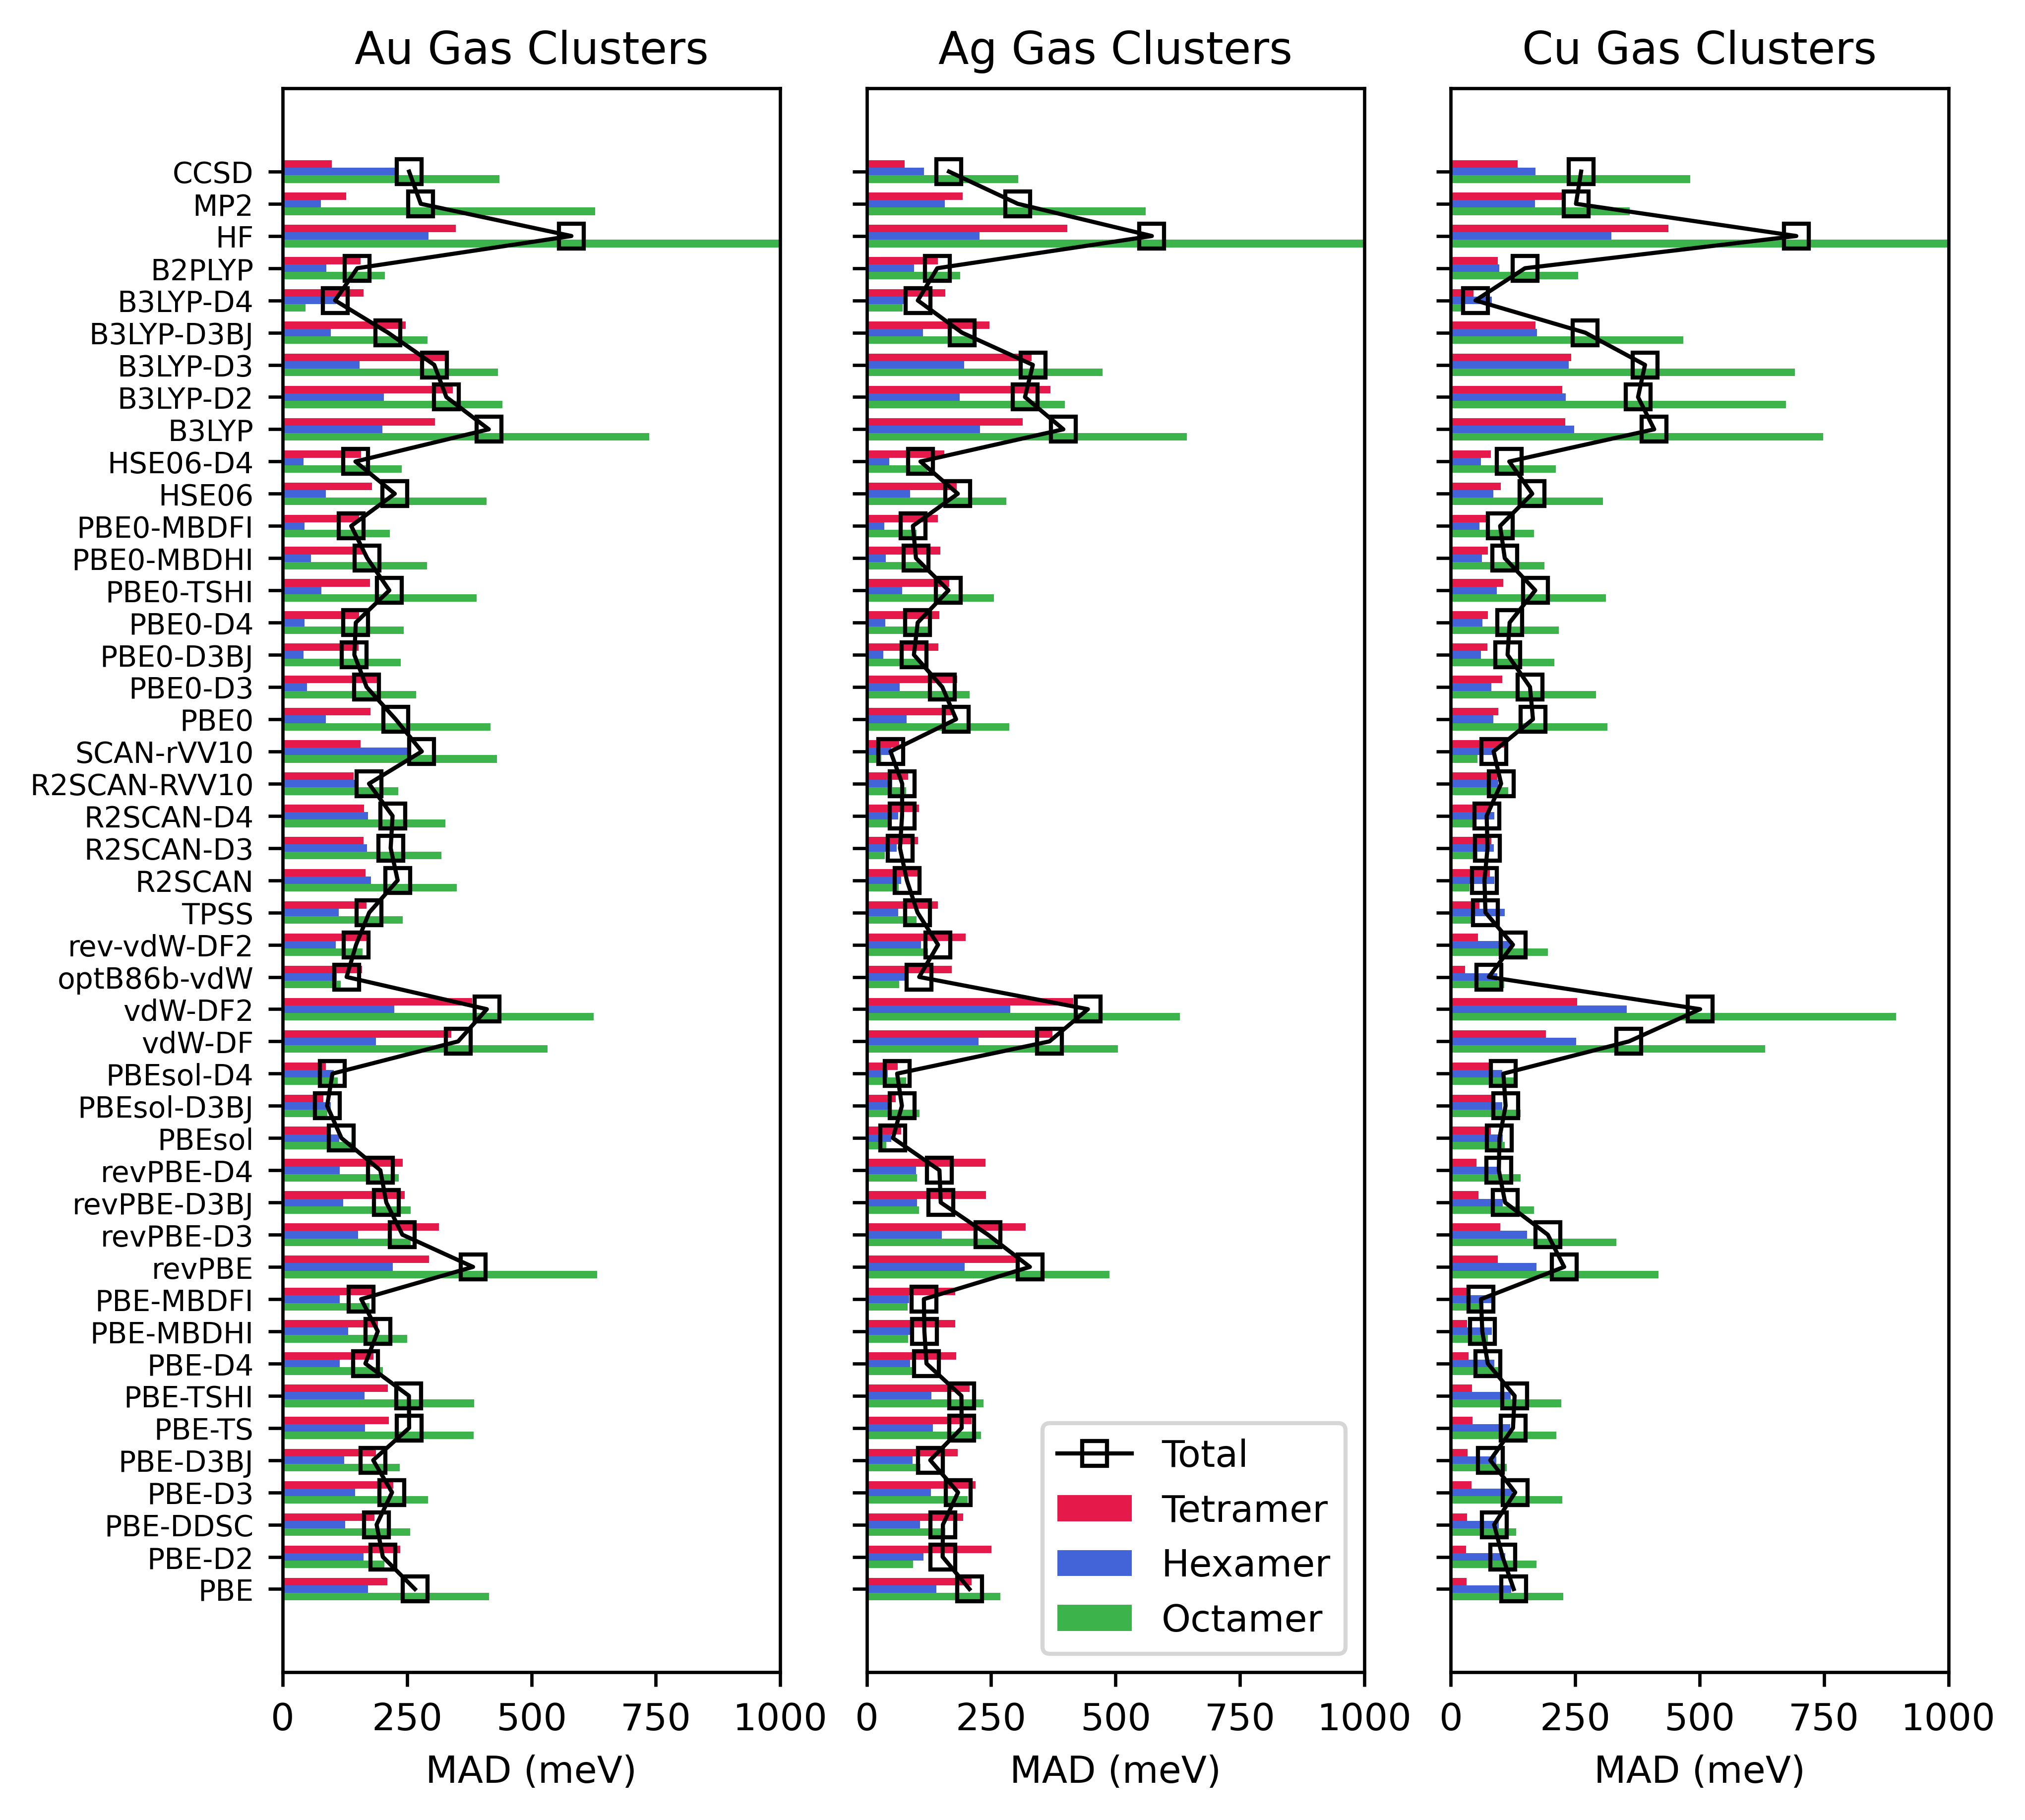

In [135]:
fig, axs = plt.subplots(1,3,figsize=(6.69,6),dpi=600, sharey=True,sharex=True,constrained_layout=True)

eov_method_sorted_list = xc_functional_list + ['B2PLYP','HF','MP2','CCSD']

# axs.
eov_method_sorted_list_val = np.array(list(range(len(eov_method_sorted_list))))

width=0.35

counter = 0
for i in ['Au','Ag','Cu']:


    axs[counter].barh(np.array(list(range(len(eov_method_sorted_list))))*1.5+width, [ (xc_rel_ene_mad[i][4][x]) for x in eov_method_sorted_list],width,label=r'Tetramer',color=color_dict['red'])
    axs[counter].barh(np.array(list(range(len(eov_method_sorted_list))))*1.5, [ (xc_rel_ene_mad[i][6][x]) for x in eov_method_sorted_list],width,label=r'Hexamer',color=color_dict['blue'])
    axs[counter].barh(np.array(list(range(len(eov_method_sorted_list))))*1.5 -width, [ (xc_rel_ene_mad[i][8][x]) for x in eov_method_sorted_list],width,label=r'Octamer',color=color_dict['green'])

    axs[counter].plot([ (xc_rel_ene_mad[i]['Total'][x]) for x in eov_method_sorted_list],np.array(list(range(len(eov_method_sorted_list))))*1.5, marker='s',markeredgewidth=1.0, markerfacecolor="None",color=color_dict['black'], linewidth=1,label='Total')

    axs[counter].set_xlabel('MAD (meV)')
    axs[counter].tick_params(axis='y', labelsize=7)  # change 10 to your desired font size

    axs[counter].set_title('{0} Gas Clusters'.format(i))

    counter += 1

axs[1].legend()
axs[0].set_yticks(np.array(list(range(len(eov_method_sorted_list))))*1.5)

name_pairs = [('PBE-D3', 'PBE-D3BJ'),('PBE-D30', 'PBE-D3'),('revPBE-D3','revPBE-D3BJ'),('REVPBE-D30','revPBE-D3'),
              ('PBEsol-D3','PBEsol-D3BJ'),('PBE0-D3','PBE0-D3BJ'),('PBE0-D30','PBE0-D3'),
              ('B3LYP-D3','B3LYP-D3BJ'),('B3LYP-D30','B3LYP-D3')
             ]
eov_method_sorted_list_rev = change_multiple_xc_names(eov_method_sorted_list, name_pairs)

axs[0].set_yticklabels(eov_method_sorted_list_rev)
axs[0].set_xlim([0,1000])

plt.savefig('Figures/Gas_MAD_Size.png')